In [177]:
from math import floor
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import colors
from time import sleep
from scipy.special import softmax

rg = np.random.RandomState(42)


In [178]:

def row_col_to_seq(row_col, num_cols):  #Converts row_column to state number format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts state to row column format
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        self.done=False
        self.steps=0
        self.max_steps=100

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def render(self,state, render_agent=False, ax=None):
        grid = np.zeros((self.num_rows, self.num_cols), dtype=int)

        for goal in self.goal_states:
            grid[goal[0], goal[1]] = 4

        if self.bad_states is not None:
            for bad_state in self.bad_states:
                grid[bad_state[0], bad_state[1]] = 3

        if self.obs_states is not None:
            for obs_state in self.obs_states:
                grid[obs_state[0], obs_state[1]] = 2

        if self.restart_states is not None:
            for restart_state in self.restart_states:

                grid[restart_state[0], restart_state[1]]=6

        if render_agent:
            grid[state[0][0],state[0][1]] = 5

        plt.clf()

        if not render_agent:
            cmap = plt.cm.colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23'])
        else:
            cmap = plt.cm.colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23', '#F0FF00','#808080'])

        if ax is None:
            fig, ax = plt.subplots()

        ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)

    def plot_Q(self, Q, message="Q plot"):
        plt.figure(figsize=(10, 10))
        plt.title(message)
        plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar()

        def x_direct(a):
            if a in [0, 1]:
                return 0
            return 1 if a == 3 else -1

        def y_direct(a):
            if a in [3, 2]:
                return 0
            return -1 if a == 0 else 1

        policy = Q.argmax(-1)
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel() + 0.5, idx[0].ravel() + 0.5, policyx.ravel(), policyy.ravel(), pivot="middle",
                color='red')
        plt.show()




    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state
    


    def reset(self):
      self.done=False
      self.steps=0
      return int(self.start_state_seq)
      

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break
        self.steps+=1

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          if next_next in self.goal_states_seq or self.steps>=self.max_steps:
              self.done=True
          else:
              self.done=False
          
          return next_next, self.R[next_next]
          
        else:
          if next_state in self.goal_states_seq or self.steps>=self.max_steps:
              self.done=True
          else:
              self.done=False
          return next_state, self.R[next_state]


In [179]:
def generate_world(windy,p_good_transition,start_state):
# specify world parameters
  wind=windy
  p_good_transition=p_good_transition
  start_state=np.array([start_state])

  num_cols = 10
  num_rows = 10
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                          [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                          [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                          [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
  restart_states = np.array([[3,7],[8,2]])
  #start_state = np.array([[0,4]])
  goal_states = np.array([[0,9],[2,2],[8,7]])

  # create model

  gw = GridWorld(num_rows=num_rows,
                  num_cols=num_cols,
                  start_state=start_state,
                  goal_states=goal_states, wind = wind)
  gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
  gw.add_rewards(step_reward=-1,
                  goal_reward=10,
                  bad_state_reward=-6,
                  restart_state_reward=-100)
  gw.add_transition_probability(p_good_transition=p_good_transition,
                                  bias=0.5)
  env = gw.create_gridworld()
  return env

def visualizing_env(env):
  print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
  print("Number of states", env.num_states)
  print("start state", env.start_state_seq)
  print("goal state(s)", env.goal_states_seq)
  env.P[0,:,0]
  env.render(state=env.start_state,ax=plt,render_agent=True) # red = obstructions, green= goal states, blue= bad states, yellow= start state, grey= restart state,


# Defining the Action Selection Policies 



# Epsilon greedy
def choose_action_epsilon(env,Q, state, epsilon, rg=rg):
    actions=np.arange(env.num_actions)
    if not Q[state[0][0], state[0][1]].any() or rg.rand()<epsilon:
        return rg.choice(actions)
    else:
        return np.argmax(Q[state[0][0],state[0][1]])

# Softmax
def choose_action_softmax(env,Q, state, tau=1, rg=rg):
    actions = np.arange(env.num_actions)
    state_rowcol=seq_to_col_row(state, env.num_cols)
    q_values = Q[state_rowcol[0][0], state_rowcol[0][1]]
    
    # Apply softmax with temperature tau
    probabilities = softmax(q_values / tau)
    
    # Choose action based on probabilities
    chosen_action = rg.choice(actions, 1, p=probabilities)[0]
    
    return chosen_action


In [180]:

# SARSA with Softmax

print_freq = 100

def sarsa_s(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    #print(alpha,epsilon,gamma,tau)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,tau)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,tau)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1], action_next] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1
       

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts

def best_policy(env,Q):

    state = env.reset()
    done = False
    steps = 0
    tot_reward = 0
    while not env.done:
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        state_row_cols= seq_to_col_row(state, env.num_cols)
        env.render(state_row_cols,ax=plt, render_agent=True)
        plt.show()
        steps += 1
        state, reward = env.step(state,Q[state_row_cols[0][0],state_row_cols[0][1]].argmax())
        tot_reward += reward
        sleep(0.2)
    print("Steps: %d, Total Reward: %d"%(steps, tot_reward))


def qlearning_s(env, Q, gamma = 1, plot_heat = False, choose_action = choose_action_softmax,epsilon0=0.1,alpha0=0.3,tau=0.2):
  
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,tau)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,tau)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1],np.argmax(Q[state_next_rowcol[0][0],state_next_rowcol[0][1]])] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            tot_reward += reward
            steps += 1
            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts






In [181]:
# sarsa with epsilon greedy 

def sarsa_e(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_epsilon,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,epsilon)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,epsilon)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1], action_next] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1
       

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts
    



# Q-Learning with epsilon-greedy

def qlearning_e(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_epsilon,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,epsilon)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,epsilon)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1],np.argmax(Q[state_next_rowcol[0][0],state_next_rowcol[0][1]])] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            tot_reward += reward
            steps += 1
            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
            
    return Q, episode_rewards, steps_to_completion,state_visit_counts



In [182]:
def plot_all(func,env):
    env=env
    num_expts = 5
    reward_avgs, steps_avgs = [], []
    rewards_all,steps_all=[],[]
    mean_rewd=[]
    Q_all= np.zeros((env.num_rows, env.num_cols, env.num_actions))
    state_visits_all= np.zeros((env.num_rows, env.num_cols))
    for i in range(num_expts):
        print("Experiment: %d"%(i+1))
        Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
        rg = np.random.RandomState(i)
        Q, rewards, steps,state_visits = func(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax,epsilon0=epsilon0,alpha0=alpha0,tau=tau)
        rewards_all.append(rewards)
        mean_rewd.append(np.mean(rewards))
        steps_all.append(steps)
        Q_all=Q_all+Q
        state_visits_all+=state_visits

    Q_avg=Q_all/num_expts
    state_visits_avg=state_visits_all/num_expts
    reward_avgs.append(np.mean(rewards_all,axis=0))
    steps_avgs.append(np.mean(steps_all,axis=0))
    mean_steps=np.mean(steps_all)
    mean_rewards=np.mean(mean_rewd)

    env.plot_Q(Q_avg)

    episodes_no=np.arange(episodes)
    reward_stds = np.std(rewards_all, axis=0)
    steps_stds = np.std(steps_all, axis=0)
    # plt.figure()
    # plt.errorbar(episodes_no, steps_avgs[0], yerr=steps_stds, label='Mean Steps', fmt='-o', ecolor='skyblue')
    # #plt.plot(episodes_no,steps_avgs[0])
    # plt.xlabel('Episode')
    # plt.ylabel('Number of steps to Goal')
    # plt.show()

    # plt.figure()
    # plt.errorbar(episodes_no, reward_avgs[0], yerr=reward_stds, label='Mean Reward', fmt='-o', ecolor='skyblue')
    # #plt.plot(episodes_no,reward_avgs[0])
    # plt.xlabel('Episode')
    # plt.ylabel('Total Reward')
    # plt.show()

    # plt.figure()
    # plt.imshow(state_visits_avg, cmap='Blues', interpolation='nearest',origin='lower')
    # plt.title('State Visit Counts Heatmap')
    # plt.colorbar(label='Visit Counts')
    # plt.xlabel('Column Index')
    # plt.ylabel('Row Index')
    # plt.grid(True, linestyle='--', alpha=0.5, color='black') 
    # plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Mean Steps
    axes[0].errorbar(episodes_no, steps_avgs[0], yerr=steps_stds, label='Mean Steps', fmt='-o', ecolor='skyblue')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Number of steps to Goal')
    axes[0].set_title('Mean Steps')

    # Plot Mean Reward
    axes[1].errorbar(episodes_no, reward_avgs[0], yerr=reward_stds, label='Mean Reward', fmt='-o', ecolor='skyblue')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Total Reward')
    axes[1].set_title('Mean Reward')

    # Plot State Visit Counts Heatmap
    heatmap = axes[2].imshow(state_visits_avg, cmap='Blues', interpolation='nearest', origin='lower')
    axes[2].set_title('State Visit Counts Heatmap')
    axes[2].set_xlabel('Column Index')
    axes[2].set_ylabel('Row Index')
    axes[2].grid(True, linestyle='--', alpha=0.5, color='black') 
    fig.colorbar(heatmap, ax=axes[2], label='Visit Counts')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()

    print('Average reward across all the runs = ',mean_rewards)
    print('Average steps across all the runs = ',mean_steps)

In [183]:
def opt_all(func,env,individual,e_s):
    env=env
    num_expts = 1
    epsilon = 0
    tau = 0
    if e_s == 0:
        alpha, gamma, epsilon = individual['alpha'], individual['gamma'], individual['epsilon_tau']
    else:
        alpha, gamma, tau = individual['alpha'], individual['gamma'], individual['epsilon_tau']
    reward_avgs, steps_avgs = [], []
    rewards_all,steps_all=[],[]
    mean_rewd=[]
    #print(alpha,gamma,epsilon,tau)
    Q_all= np.zeros((env.num_rows, env.num_cols, env.num_actions))
    state_visits_all= np.zeros((env.num_rows, env.num_cols))
    for i in range(num_expts):
        print("Experiment: %d"%(i+1))
        Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
        rg = np.random.RandomState(i)
        Q, rewards, steps,state_visits = func(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax,epsilon0=epsilon,alpha0=alpha,tau=tau)
        rewards_all.append(rewards)
        mean_rewd.append(np.mean(rewards))
        steps_all.append(steps)
        Q_all=Q_all+Q
        state_visits_all+=state_visits

    Q_avg=Q_all/num_expts
    state_visits_avg=state_visits_all/num_expts
    reward_avgs.append(np.mean(rewards_all,axis=0))
    steps_avgs.append(np.mean(steps_all,axis=0))
    mean_steps=np.mean(steps_all)
    print(mean_steps)
    mean_rewards=np.mean(mean_rewd)
    return mean_rewards,mean_steps

In [184]:
env1= generate_world(False,1,[0,4])
env2= generate_world(False,1,[3,6])
env3= generate_world(False,0.7,[0,4])
env4= generate_world(False,0.7,[3,6])
env5= generate_world(True,1,[0,4])
env6= generate_world(True,1,[3,6])

In [185]:

def initialize_population(population_size,e_s):
    population = []
    for _ in range(population_size):
        if e_s:
            individual = {
                'alpha': np.random.uniform(0.2, 0.5),
                'gamma': np.random.uniform(0.8, 1.0),
                'epsilon_tau': np.random.uniform(0.5, 1), # tau for e_s=1
                # 'tau': np.random.uniform(0.5,0.8)
            }
            population.append(individual)
        else:
            individual = {
                'alpha': np.random.uniform(0.2, 0.5),
                'gamma': np.random.uniform(0.8, 1.0),
                'epsilon_tau': np.random.uniform(0.05,0.3)
            }
            population.append(individual)
    return population

def evaluate_individual(individual, env, func,e_s):
    alpha, gamma, epsilon_tau = individual['alpha'], individual['gamma'], individual['epsilon_tau']
    #print(alpha,gamma, epsilon, tau)
    mean_rewards_ok, mean_steps_ok = opt_all(func, env,individual,e_s)
    return mean_rewards_ok, mean_steps_ok

def combined_score(individual, rewards_weight=0.5, steps_weight=0.5):
    return rewards_weight * individual['mean_rewards'] + steps_weight * (-individual['mean_steps'])



def select_parents(population, num_parents):
    # Select top individuals based on their fitness
    # sorted_population = sorted(population, key=lambda x: (x['mean_rewards'], -x['mean_steps']), reverse=True)
    sorted_population = sorted(population, key=lambda x: combined_score(x), reverse=True)
    print(sorted_population[:num_parents])
    return sorted_population[:num_parents]

def crossover(parent1, parent2):
    # Perform crossover to create a new individual
    crossover_point = np.random.choice(list(parent1.keys()))
    child = {key: parent1[key] if np.random.rand() < 0.5 else parent2[key] for key in parent1.keys()}
    return child

def mutate(individual, mutation_rate=0.2,e_s=0):
    # Perform mutation on an individual
    for key in individual.keys():
        if np.random.rand() < mutation_rate:
            if key == 'epsilon_tau' and e_s == 1:
                individual[key] = np.random.uniform(0.5,0.8)
            elif key == 'alpha':
                individual[key] = np.random.uniform(0.2,0.4)
            elif key=='gamma':
                individual[key] = np.random.uniform(0.95,1)

            else:
                individual[key] = np.random.uniform(0.1, 0.25)
    return individual

def genetic_algorithm(env, func, population_size=10, num_generations=5, num_parents=4,e_s = 0):
    # Initialize population
    #if e_s = 1, then it is softmax, e_s = 0 then it is epsilon greedy
    population = initialize_population(population_size,e_s)

    # Evolution loop
    for generation in range(num_generations):
        print(f"\nGeneration {generation + 1}")
        for individual in population:
            # Evaluate fitness of each individual
            mean_rewards_yes, mean_steps_yes = evaluate_individual(individual, env, func,e_s)
            individual['mean_rewards'] = mean_rewards_yes

            individual['mean_steps'] = mean_steps_yes

        # Select parents
        parents = select_parents(population, num_parents)
        best_individual = parents[0]
        best_hyperparameters = {key: best_individual[key] for key in ['alpha', 'gamma', 'epsilon_tau']}
        best_mean_rewards, best_mean_steps = best_individual['mean_rewards'], best_individual['mean_steps']
      
        print(best_individual)
        
        print(f"\nBest Hyperparameters: {best_hyperparameters}")
        print(f"Best Mean Rewards: {best_mean_rewards}")
        print(f"Best Mean Steps: {best_mean_steps}")

        # Create next generation
        new_population = parents.copy()
        while len(new_population) < population_size:
            parent1, parent2 = np.random.choice(parents, size=2, replace=False)
            child = crossover(parent1, parent2)
            child = mutate(child,e_s=e_s)
            new_population.append(child)

        # Update population for the next generation
        population = new_population
    
        
    # Get the best individual from the final generation
    # best_individual = max(population, key=lambda x: (x['mean_rewards'], -x['mean_steps']))
    # best_hyperparameters = {key: best_individual[key] for key in ['alpha', 'gamma', 'epsilon', 'tau']}
    # best_mean_rewards, best_mean_steps = best_individual['mean_rewards'], best_individual['mean_steps']

    return best_hyperparameters, best_mean_rewards, best_mean_steps


In [108]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env1,sarsa_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.3170467199939588, 'gamma': 0.976206195991334, 'epsilon_tau': 0.12143203077618837}, {'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223}, {'alpha': 0.31883630722212014, 'gamma': 0.8246771031749521, 'epsilon_tau': 0.2467175355133493}, {'alpha': 0.318069478007083, 'gamma': 0.8674151303849561, 'epsilon_tau': 0.1169581532447685}, {'alpha': 0.4618706490269808, 'gamma': 0.9837244550531666, 'epsilon_tau': 0.10838418250874905}, {'alpha': 0.23568890932390912, 'gamma': 0.8371279701566945, 'epsilon_tau': 0.12225663577479494}, {'alpha': 0.4425647296507864, 'gamma': 0.9486203461593805, 'epsilon_tau': 0.15310479869477106}, {'alpha': 0.24184526291360742, 'gamma': 0.9676888593816163, 'epsilon_tau': 0.09463638315557839}, {'alpha': 0.4033107636568515, 'gamma': 0.9566379881341028, 'epsilon_tau': 0.18674930208280327}, {'alpha': 0.2939885861643893, 'gamma': 0.8116320830784667, 'epsilon_tau': 0.23522481402024747}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1168.04it/s]


12.7642
-6.8724 12.7642
{'alpha': 0.3170467199939588, 'gamma': 0.976206195991334, 'epsilon_tau': 0.12143203077618837, 'mean_rewards': -6.8724} -6.8724
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 748.58it/s]


17.5572
-6.7486 17.5572
{'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7486} -6.7486
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 835.97it/s]


18.0572
-10.446 18.0572
{'alpha': 0.31883630722212014, 'gamma': 0.8246771031749521, 'epsilon_tau': 0.2467175355133493, 'mean_rewards': -10.446} -10.446
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 800.21it/s]


17.8884
-7.0772 17.8884
{'alpha': 0.318069478007083, 'gamma': 0.8674151303849561, 'epsilon_tau': 0.1169581532447685, 'mean_rewards': -7.0772} -7.0772
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1233.28it/s]


12.5594
-6.6614 12.5594
{'alpha': 0.4618706490269808, 'gamma': 0.9837244550531666, 'epsilon_tau': 0.10838418250874905, 'mean_rewards': -6.6614} -6.6614
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 741.75it/s]


18.5756
-7.8214 18.5756
{'alpha': 0.23568890932390912, 'gamma': 0.8371279701566945, 'epsilon_tau': 0.12225663577479494, 'mean_rewards': -7.8214} -7.8214
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 773.88it/s]


17.5264
-6.7016 17.5264
{'alpha': 0.4425647296507864, 'gamma': 0.9486203461593805, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.7016} -6.7016
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 752.73it/s]


17.8694
-7.0954 17.8694
{'alpha': 0.24184526291360742, 'gamma': 0.9676888593816163, 'epsilon_tau': 0.09463638315557839, 'mean_rewards': -7.0954} -7.0954
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 776.95it/s]


17.5998
-6.7852 17.5998
{'alpha': 0.4033107636568515, 'gamma': 0.9566379881341028, 'epsilon_tau': 0.18674930208280327, 'mean_rewards': -6.7852} -6.7852
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 744.05it/s]


19.699
-11.7188 19.699
{'alpha': 0.2939885861643893, 'gamma': 0.8116320830784667, 'epsilon_tau': 0.23522481402024747, 'mean_rewards': -11.7188} -11.7188
[{'alpha': 0.4618706490269808, 'gamma': 0.9837244550531666, 'epsilon_tau': 0.10838418250874905, 'mean_rewards': -6.6614, 'mean_steps': 12.5594}, {'alpha': 0.3170467199939588, 'gamma': 0.976206195991334, 'epsilon_tau': 0.12143203077618837, 'mean_rewards': -6.8724, 'mean_steps': 12.7642}, {'alpha': 0.4425647296507864, 'gamma': 0.9486203461593805, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.7016, 'mean_steps': 17.5264}, {'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7486, 'mean_steps': 17.5572}]
{'alpha': 0.4618706490269808, 'gamma': 0.9837244550531666, 'epsilon_tau': 0.10838418250874905, 'mean_rewards': -6.6614, 'mean_steps': 12.5594}

Best Hyperparameters: {'alpha': 0.4618706490269808, 'gamma': 0.9837244550531666, 'epsilon_tau': 0.10838418250874905}
Best Mean

100%|██████████| 5000/5000 [00:06<00:00, 800.81it/s]


17.4996
-6.6846 17.4996
{'alpha': 0.4618706490269808, 'gamma': 0.9837244550531666, 'epsilon_tau': 0.10838418250874905, 'mean_rewards': -6.6846, 'mean_steps': 12.5594} -6.6846
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 790.30it/s]


17.6926
-6.9 17.6926
{'alpha': 0.3170467199939588, 'gamma': 0.976206195991334, 'epsilon_tau': 0.12143203077618837, 'mean_rewards': -6.9, 'mean_steps': 12.7642} -6.9
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 788.89it/s]


17.581
-6.7682 17.581
{'alpha': 0.4425647296507864, 'gamma': 0.9486203461593805, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.7682, 'mean_steps': 17.5264} -6.7682
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1000.34it/s]


12.618
-6.7394 12.618
{'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7394, 'mean_steps': 17.5572} -6.7394
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.07it/s]


17.5274
-6.7156 17.5274
{'alpha': 0.4618706490269808, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7156, 'mean_steps': 17.5572} -6.7156
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 481.63it/s]


17.5744
-6.7674 17.5744
{'alpha': 0.40595056146305963, 'gamma': 0.986339496064964, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7674, 'mean_steps': 12.7642} -6.7674
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 514.33it/s]


12.6434
-6.763 12.6434
{'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.763, 'mean_steps': 17.5264} -6.763
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 483.34it/s]


17.6962
-6.9078 17.6962
{'alpha': 0.3170467199939588, 'gamma': 0.976206195991334, 'epsilon_tau': 0.12143203077618837, 'mean_rewards': -6.9078, 'mean_steps': 12.5594} -6.9078
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 610.55it/s]


17.5496
-6.7464 17.5496
{'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7464, 'mean_steps': 17.5264} -6.7464
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 494.08it/s]


17.504
-6.6912 17.504
{'alpha': 0.4425647296507864, 'gamma': 0.9963833890036601, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.6912, 'mean_steps': 12.7642} -6.6912
[{'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7394, 'mean_steps': 12.618}, {'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.763, 'mean_steps': 12.6434}, {'alpha': 0.4618706490269808, 'gamma': 0.9837244550531666, 'epsilon_tau': 0.10838418250874905, 'mean_rewards': -6.6846, 'mean_steps': 17.4996}, {'alpha': 0.4425647296507864, 'gamma': 0.9963833890036601, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.6912, 'mean_steps': 17.504}]
{'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7394, 'mean_steps': 12.618}

Best Hyperparameters: {'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.217071709

100%|██████████| 5000/5000 [00:10<00:00, 473.79it/s]


17.5736
-6.7652 17.5736
{'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7652, 'mean_steps': 12.618} -6.7652
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 804.51it/s] 


12.6576
-6.7816 12.6576
{'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.7816, 'mean_steps': 12.6434} -6.7816
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 546.79it/s]


17.4768
-6.6606 17.4768
{'alpha': 0.4618706490269808, 'gamma': 0.9837244550531666, 'epsilon_tau': 0.10838418250874905, 'mean_rewards': -6.6606, 'mean_steps': 17.4996} -6.6606
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 519.77it/s]


17.5454
-6.727 17.5454
{'alpha': 0.4425647296507864, 'gamma': 0.9963833890036601, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.727, 'mean_steps': 17.504} -6.727
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 822.85it/s] 


12.594
-6.7114 12.594
{'alpha': 0.4425647296507864, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7114, 'mean_steps': 0.2319321312701753} -6.7114
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 542.53it/s]


17.5508
-6.7412 17.5508
{'alpha': 0.4425647296507864, 'gamma': 0.9678556575353776, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.7412, 'mean_steps': 0.16702594625437317} -6.7412
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 912.62it/s] 


12.6104
-6.7208 12.6104
{'alpha': 0.4425647296507864, 'gamma': 0.9604773231337901, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.7208, 'mean_steps': 17.504} -6.7208
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 689.65it/s]


17.5062
-6.683 17.5062
{'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.683, 'mean_steps': 12.6434} -6.683
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 711.97it/s]


17.558
-6.7454 17.558
{'alpha': 0.40595056146305963, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.21707170941857223, 'mean_rewards': -6.7454, 'mean_steps': 12.6434} -6.7454
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1022.35it/s]


12.6192
-6.733 12.6192
{'alpha': 0.4425647296507864, 'gamma': 0.9609875838747886, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.733, 'mean_steps': 17.4996} -6.733
[{'alpha': 0.4425647296507864, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7114, 'mean_steps': 12.594}, {'alpha': 0.4425647296507864, 'gamma': 0.9604773231337901, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.7208, 'mean_steps': 12.6104}, {'alpha': 0.4425647296507864, 'gamma': 0.9609875838747886, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.733, 'mean_steps': 12.6192}, {'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.7816, 'mean_steps': 12.6576}]
{'alpha': 0.4425647296507864, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7114, 'mean_steps': 12.594}

Best Hyperparameters: {'alpha': 0.4425647296507864, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.151833322436

100%|██████████| 5000/5000 [00:08<00:00, 584.28it/s]


17.5582
-6.7416 17.5582
{'alpha': 0.4425647296507864, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7416, 'mean_steps': 12.594} -6.7416
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 529.81it/s]


17.563
-6.7448 17.563
{'alpha': 0.4425647296507864, 'gamma': 0.9604773231337901, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.7448, 'mean_steps': 12.6104} -6.7448
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 588.78it/s]


17.5658
-6.756 17.5658
{'alpha': 0.4425647296507864, 'gamma': 0.9609875838747886, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.756, 'mean_steps': 12.6192} -6.756
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 694.55it/s]


17.507
-6.6932 17.507
{'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.6932, 'mean_steps': 12.6576} -6.6932
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 665.35it/s]


17.6402
-6.839 17.6402
{'alpha': 0.3390786163366729, 'gamma': 0.9609875838747886, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.839, 'mean_steps': 12.594} -6.839
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 658.91it/s]


17.5646
-6.7462 17.5646
{'alpha': 0.4425647296507864, 'gamma': 0.9609875838747886, 'epsilon_tau': 0.13548696733011895, 'mean_rewards': -6.7462, 'mean_steps': 12.6192} -6.7462
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 555.02it/s]


17.778
-6.9968 17.778
{'alpha': 0.26349086833954044, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.9968, 'mean_steps': 12.594} -6.9968
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 971.57it/s] 


13.0452
-7.1818 13.0452
{'alpha': 0.2162272267250408, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -7.1818, 'mean_steps': 12.594} -7.1818
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 647.40it/s]


17.7266
-6.9484 17.7266
{'alpha': 0.29214515786187706, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.9484, 'mean_steps': 12.6104} -6.9484
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 661.78it/s]


17.5332
-6.6992 17.5332
{'alpha': 0.4425647296507864, 'gamma': 0.967279601384669, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.6992, 'mean_steps': 12.6104} -6.6992
[{'alpha': 0.2162272267250408, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -7.1818, 'mean_steps': 13.0452}, {'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.6932, 'mean_steps': 17.507}, {'alpha': 0.4425647296507864, 'gamma': 0.967279601384669, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.6992, 'mean_steps': 17.5332}, {'alpha': 0.4425647296507864, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7416, 'mean_steps': 17.5582}]
{'alpha': 0.2162272267250408, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -7.1818, 'mean_steps': 13.0452}

Best Hyperparameters: {'alpha': 0.2162272267250408, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.202411184

100%|██████████| 5000/5000 [00:05<00:00, 853.27it/s] 


13.1384
-7.2566 13.1384
{'alpha': 0.2162272267250408, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -7.2566, 'mean_steps': 13.0452} -7.2566
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 579.31it/s]


17.5672
-6.7528 17.5672
{'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.7528, 'mean_steps': 17.507} -6.7528
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 600.00it/s]


17.5492
-6.7328 17.5492
{'alpha': 0.4425647296507864, 'gamma': 0.967279601384669, 'epsilon_tau': 0.15310479869477106, 'mean_rewards': -6.7328, 'mean_steps': 17.5332} -6.7328
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 748.92it/s]


17.5356
-6.7036 17.5356
{'alpha': 0.4425647296507864, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7036, 'mean_steps': 17.5582} -6.7036
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 804.79it/s]


17.5538
-6.7426 17.5538
{'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7426, 'mean_steps': 17.5582} -6.7426
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 813.43it/s]


17.5246
-6.7056 17.5246
{'alpha': 0.4425647296507864, 'gamma': 0.967279601384669, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7056, 'mean_steps': 0.23526962045349892} -6.7056
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 808.68it/s]


17.5466
-6.7242 17.5466
{'alpha': 0.4425647296507864, 'gamma': 0.9783501531007358, 'epsilon_tau': 0.14035571502136795, 'mean_rewards': -6.7242, 'mean_steps': 17.5332} -6.7242
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 629.76it/s]


17.518
-6.7042 17.518
{'alpha': 0.4425647296507864, 'gamma': 0.9557391263256741, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7042, 'mean_steps': 17.5582} -6.7042
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 917.89it/s] 


12.6026
-6.7176 12.6026
{'alpha': 0.4425647296507864, 'gamma': 0.967279601384669, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.7176, 'mean_steps': 17.507} -6.7176
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 620.92it/s]

17.4894
-6.6712 17.4894
{'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.6712, 'mean_steps': 17.507} -6.6712
[{'alpha': 0.4425647296507864, 'gamma': 0.967279601384669, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.7176, 'mean_steps': 12.6026}, {'alpha': 0.2162272267250408, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -7.2566, 'mean_steps': 13.1384}, {'alpha': 0.4425647296507864, 'gamma': 0.9874104631875028, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.6712, 'mean_steps': 17.4894}, {'alpha': 0.4425647296507864, 'gamma': 0.9557391263256741, 'epsilon_tau': 0.15183332243681985, 'mean_rewards': -6.7042, 'mean_steps': 17.518}]
{'alpha': 0.4425647296507864, 'gamma': 0.967279601384669, 'epsilon_tau': 0.20241118469273983, 'mean_rewards': -6.7176, 'mean_steps': 12.6026}

Best Hyperparameters: {'alpha': 0.4425647296507864, 'gamma': 0.967279601384669, 'epsilon_tau': 0.20241118469

Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 782.56it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1241.85it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 799.96it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:06<00:00, 787.89it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:06<00:00, 784.68it/s]


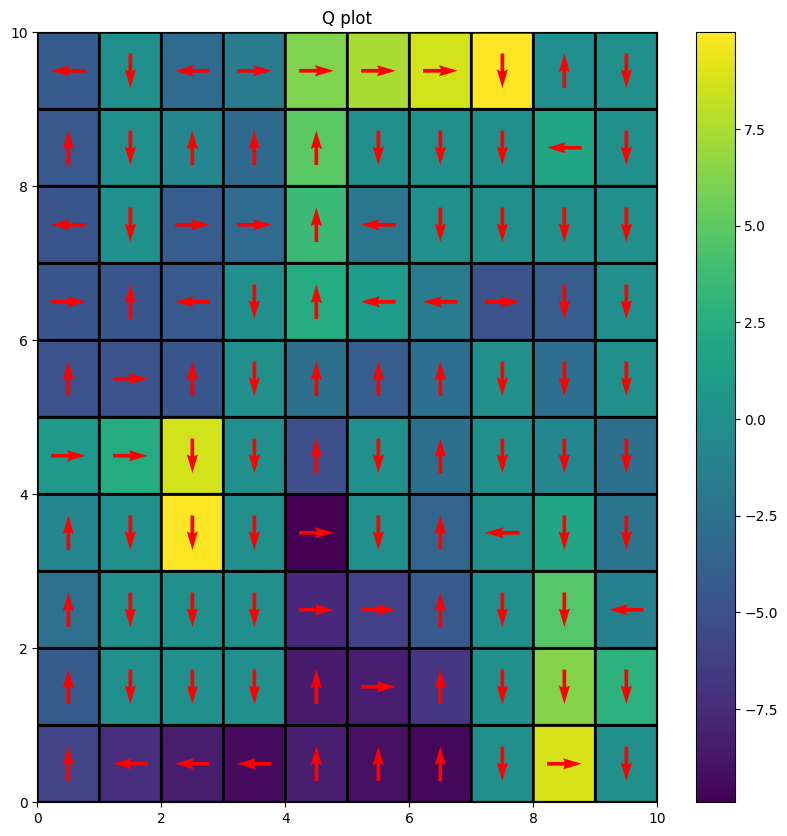

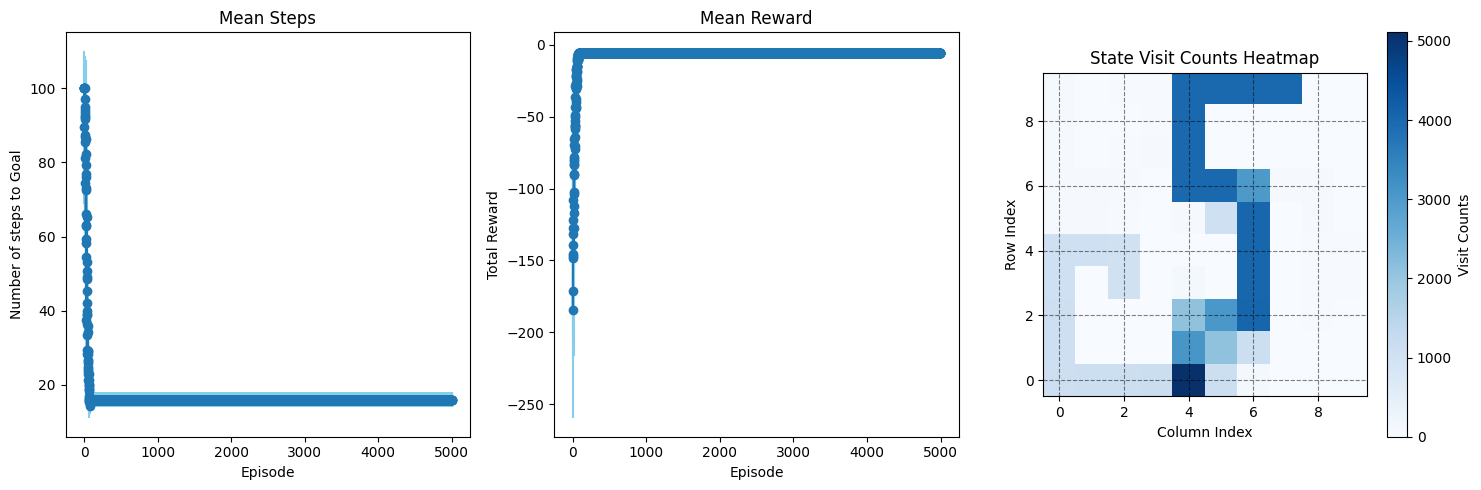

Average reward across all the runs =  -6.73728
Average steps across all the runs =  16.5628


In [109]:
alpha0=0.4425647296507864
gamma=0.967279601384669
epsilon0=0.20241118469273983
plot_all(sarsa_e,env1)

In [110]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env1,sarsa_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.3257459380379758, 'gamma': 0.9609165356460341, 'epsilon_tau': 0.8868165293354395}, {'alpha': 0.48418889267307225, 'gamma': 0.9388733464479576, 'epsilon_tau': 0.5270103941594292}, {'alpha': 0.4291863537196603, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044}, {'alpha': 0.2643941405457338, 'gamma': 0.8256529348205724, 'epsilon_tau': 0.9618215412089427}, {'alpha': 0.37669846557568165, 'gamma': 0.8203314472439833, 'epsilon_tau': 0.6137265465286841}, {'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.8082058805949395}, {'alpha': 0.4190782413638152, 'gamma': 0.805216926114149, 'epsilon_tau': 0.8477800300915961}, {'alpha': 0.41221330706960657, 'gamma': 0.9589241421637167, 'epsilon_tau': 0.7645816049105685}, {'alpha': 0.31018269490440165, 'gamma': 0.8476684966295983, 'epsilon_tau': 0.5070853070655167}, {'alpha': 0.2721138638949026, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.896987921474992}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 962.18it/s] 


16.2604
-10.4142 16.2604
{'alpha': 0.3257459380379758, 'gamma': 0.9609165356460341, 'epsilon_tau': 0.8868165293354395, 'mean_rewards': -10.4142} -10.4142
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1123.87it/s]


13.6086
-7.7384 13.6086
{'alpha': 0.48418889267307225, 'gamma': 0.9388733464479576, 'epsilon_tau': 0.5270103941594292, 'mean_rewards': -7.7384} -7.7384
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 795.41it/s]


17.5942
-6.7996 17.5942
{'alpha': 0.4291863537196603, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7996} -6.7996
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 262.82it/s]


61.6228
-55.0518 61.6228
{'alpha': 0.2643941405457338, 'gamma': 0.8256529348205724, 'epsilon_tau': 0.9618215412089427, 'mean_rewards': -55.0518} -55.0518
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 373.65it/s]


41.7678
-33.4266 41.7678
{'alpha': 0.37669846557568165, 'gamma': 0.8203314472439833, 'epsilon_tau': 0.6137265465286841, 'mean_rewards': -33.4266} -33.4266
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1121.68it/s]


13.5118
-7.6886 13.5118
{'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.8082058805949395, 'mean_rewards': -7.6886} -7.6886
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 245.10it/s]


64.0856
-57.715 64.0856
{'alpha': 0.4190782413638152, 'gamma': 0.805216926114149, 'epsilon_tau': 0.8477800300915961, 'mean_rewards': -57.715} -57.715
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 741.96it/s]


18.3266
-7.8338 18.3266
{'alpha': 0.41221330706960657, 'gamma': 0.9589241421637167, 'epsilon_tau': 0.7645816049105685, 'mean_rewards': -7.8338} -7.8338
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 616.94it/s]


24.55
-16.0472 24.55
{'alpha': 0.31018269490440165, 'gamma': 0.8476684966295983, 'epsilon_tau': 0.5070853070655167, 'mean_rewards': -16.0472} -16.0472
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1079.58it/s]


13.8698
-8.0582 13.8698
{'alpha': 0.2721138638949026, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.896987921474992, 'mean_rewards': -8.0582} -8.0582
[{'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.8082058805949395, 'mean_rewards': -7.6886, 'mean_steps': 13.5118}, {'alpha': 0.48418889267307225, 'gamma': 0.9388733464479576, 'epsilon_tau': 0.5270103941594292, 'mean_rewards': -7.7384, 'mean_steps': 13.6086}, {'alpha': 0.2721138638949026, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.896987921474992, 'mean_rewards': -8.0582, 'mean_steps': 13.8698}, {'alpha': 0.4291863537196603, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7996, 'mean_steps': 17.5942}]
{'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.8082058805949395, 'mean_rewards': -7.6886, 'mean_steps': 13.5118}

Best Hyperparameters: {'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.8082058805949395}
Best Mean Rewards: 

100%|██████████| 5000/5000 [00:04<00:00, 1060.00it/s]


13.7898
-7.9584 13.7898
{'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.8082058805949395, 'mean_rewards': -7.9584, 'mean_steps': 13.5118} -7.9584
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 761.44it/s]


17.976
-7.4566 17.976
{'alpha': 0.48418889267307225, 'gamma': 0.9388733464479576, 'epsilon_tau': 0.5270103941594292, 'mean_rewards': -7.4566, 'mean_steps': 13.6086} -7.4566
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 773.35it/s]


13.4166
-7.5736 13.4166
{'alpha': 0.2721138638949026, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.896987921474992, 'mean_rewards': -7.5736, 'mean_steps': 13.8698} -7.5736
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 854.65it/s] 


12.709
-6.854 12.709
{'alpha': 0.4291863537196603, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.854, 'mean_steps': 17.5942} -6.854
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 836.75it/s]


14.0136
-8.1884 14.0136
{'alpha': 0.2721138638949026, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.896987921474992, 'mean_rewards': -8.1884, 'mean_steps': 13.8698} -8.1884
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 994.88it/s] 


13.3106
-7.463 13.3106
{'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.463, 'mean_steps': 13.5118} -7.463
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1052.17it/s]


12.6326
-6.7606 12.6326
{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7606, 'mean_steps': 13.6086} -6.7606
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 780.84it/s] 


15.1398
-9.3032 15.1398
{'alpha': 0.2721138638949026, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.896987921474992, 'mean_rewards': -9.3032, 'mean_steps': 13.5118} -9.3032
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 596.35it/s]


13.7544
-7.9188 13.7544
{'alpha': 0.2721138638949026, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.8082058805949395, 'mean_rewards': -7.9188, 'mean_steps': 13.8698} -7.9188
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 535.44it/s]


13.8176
-7.9808 13.8176
{'alpha': 0.2721138638949026, 'gamma': 0.994020161163026, 'epsilon_tau': 0.7577234436426415, 'mean_rewards': -7.9808, 'mean_steps': 17.5942} -7.9808
[{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7606, 'mean_steps': 12.6326}, {'alpha': 0.4291863537196603, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.854, 'mean_steps': 12.709}, {'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.463, 'mean_steps': 13.3106}, {'alpha': 0.2721138638949026, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.896987921474992, 'mean_rewards': -7.5736, 'mean_steps': 13.4166}]
{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7606, 'mean_steps': 12.6326}

Best Hyperparameters: {'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044}


100%|██████████| 5000/5000 [00:08<00:00, 621.64it/s]


12.6486
-6.7746 12.6486
{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7746, 'mean_steps': 12.6326} -6.7746
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 422.01it/s]


17.6406
-6.8468 17.6406
{'alpha': 0.4291863537196603, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.8468, 'mean_steps': 12.709} -6.8468
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 662.40it/s]


13.2398
-7.3736 13.2398
{'alpha': 0.2242357535110155, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.3736, 'mean_steps': 13.3106} -7.3736
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 513.87it/s]


15.33
-9.54 15.33
{'alpha': 0.2721138638949026, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.896987921474992, 'mean_rewards': -9.54, 'mean_steps': 13.4166} -9.54
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 622.95it/s]


12.6732
-6.7808 12.6732
{'alpha': 0.4291863537196603, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7808, 'mean_steps': 13.3106} -6.7808
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 371.32it/s]


18.37
-7.6606 18.37
{'alpha': 0.2242357535110155, 'gamma': 0.9523970791788592, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.6606, 'mean_steps': 12.709} -7.6606
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 596.08it/s]


13.1974
-7.3404 13.1974
{'alpha': 0.2242357535110155, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.3404, 'mean_steps': 13.4166} -7.3404
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 639.51it/s]


13.2222
-7.3914 13.2222
{'alpha': 0.2242357535110155, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.3914, 'mean_steps': 13.3106} -7.3914
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 625.51it/s]


13.072
-7.207 13.072
{'alpha': 0.3224912111748165, 'gamma': 0.9560213718543389, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.207, 'mean_steps': 12.6326} -7.207
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 416.96it/s]


17.7414
-6.9804 17.7414
{'alpha': 0.38329476841417, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.9804, 'mean_steps': 12.709} -6.9804
[{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7746, 'mean_steps': 12.6486}, {'alpha': 0.4291863537196603, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7808, 'mean_steps': 12.6732}, {'alpha': 0.3224912111748165, 'gamma': 0.9560213718543389, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.207, 'mean_steps': 13.072}, {'alpha': 0.2242357535110155, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.3404, 'mean_steps': 13.1974}]
{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7746, 'mean_steps': 12.6486}

Best Hyperparameters: {'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044}

100%|██████████| 5000/5000 [00:07<00:00, 705.43it/s]


12.6332
-6.7626 12.6332
{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7626, 'mean_steps': 12.6486} -6.7626
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 469.29it/s]


17.6754
-6.8806 17.6754
{'alpha': 0.4291863537196603, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.8806, 'mean_steps': 12.6732} -6.8806
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 580.16it/s]


12.9418
-7.0634 12.9418
{'alpha': 0.3224912111748165, 'gamma': 0.9560213718543389, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.0634, 'mean_steps': 13.072} -7.0634
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 621.94it/s]


13.3042
-7.4804 13.3042
{'alpha': 0.2242357535110155, 'gamma': 0.9984454262136665, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.4804, 'mean_steps': 13.1974} -7.4804
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 666.56it/s]


13.2302
-7.4006 13.2302
{'alpha': 0.2242357535110155, 'gamma': 0.9985780588911105, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.4006, 'mean_steps': 13.1974} -7.4006
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 601.87it/s]


13.0296
-7.1594 13.0296
{'alpha': 0.35770665276595237, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.690694682159869, 'mean_rewards': -7.1594, 'mean_steps': 12.6732} -7.1594
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 478.94it/s]


18.019
-7.2844 18.019
{'alpha': 0.257775874715106, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.2844, 'mean_steps': 12.6732} -7.2844
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 398.16it/s]


17.8402
-7.0786 17.8402
{'alpha': 0.3224912111748165, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.0786, 'mean_steps': 13.072} -7.0786
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 672.61it/s]


12.8818
-7.0122 12.8818
{'alpha': 0.3224912111748165, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5656724064513657, 'mean_rewards': -7.0122, 'mean_steps': 12.6732} -7.0122
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 620.19it/s]


13.5218
-7.6628 13.5218
{'alpha': 0.3216950213516969, 'gamma': 0.994020161163026, 'epsilon_tau': 0.7681319537525859, 'mean_rewards': -7.6628, 'mean_steps': 12.6486} -7.6628
[{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7626, 'mean_steps': 12.6332}, {'alpha': 0.3224912111748165, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5656724064513657, 'mean_rewards': -7.0122, 'mean_steps': 12.8818}, {'alpha': 0.3224912111748165, 'gamma': 0.9560213718543389, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.0634, 'mean_steps': 12.9418}, {'alpha': 0.35770665276595237, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.690694682159869, 'mean_rewards': -7.1594, 'mean_steps': 13.0296}]
{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7626, 'mean_steps': 12.6332}

Best Hyperparameters: {'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206

100%|██████████| 5000/5000 [00:09<00:00, 554.44it/s]


12.6604
-6.7906 12.6604
{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7906, 'mean_steps': 12.6332} -6.7906
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 815.95it/s] 


12.8988
-7.0512 12.8988
{'alpha': 0.3224912111748165, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5656724064513657, 'mean_rewards': -7.0512, 'mean_steps': 12.8818} -7.0512
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 480.04it/s]


17.9616
-7.2158 17.9616
{'alpha': 0.3224912111748165, 'gamma': 0.9560213718543389, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.2158, 'mean_steps': 12.9418} -7.2158
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 584.22it/s]


13.4834
-7.6292 13.4834
{'alpha': 0.35770665276595237, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.690694682159869, 'mean_rewards': -7.6292, 'mean_steps': 13.0296} -7.6292
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 621.29it/s]


13.095
-7.228 13.095
{'alpha': 0.26439311012699257, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -7.228, 'mean_steps': 13.0296} -7.228
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 410.53it/s]


17.67
-6.8726 17.67
{'alpha': 0.48418889267307225, 'gamma': 0.9560213718543389, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.8726, 'mean_steps': 0.1152293099790059} -6.8726
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 494.84it/s]


17.8622
-7.0992 17.8622
{'alpha': 0.3224912111748165, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.690694682159869, 'mean_rewards': -7.0992, 'mean_steps': 13.0296} -7.0992
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 662.29it/s]


12.7344
-6.8684 12.7344
{'alpha': 0.48418889267307225, 'gamma': 0.9506273572572779, 'epsilon_tau': 0.5221403968656437, 'mean_rewards': -6.8684, 'mean_steps': 12.6332} -6.8684
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 614.17it/s]


12.9302
-7.0512 12.9302
{'alpha': 0.35770665276595237, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5656724064513657, 'mean_rewards': -7.0512, 'mean_steps': 13.0296} -7.0512
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 436.78it/s]

17.7864
-7.0172 17.7864
{'alpha': 0.35770665276595237, 'gamma': 0.994020161163026, 'epsilon_tau': 0.690694682159869, 'mean_rewards': -7.0172, 'mean_steps': 0.1884761297650321} -7.0172
[{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7906, 'mean_steps': 12.6604}, {'alpha': 0.48418889267307225, 'gamma': 0.9506273572572779, 'epsilon_tau': 0.5221403968656437, 'mean_rewards': -6.8684, 'mean_steps': 12.7344}, {'alpha': 0.3224912111748165, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5656724064513657, 'mean_rewards': -7.0512, 'mean_steps': 12.8988}, {'alpha': 0.35770665276595237, 'gamma': 0.9846049151795231, 'epsilon_tau': 0.5656724064513657, 'mean_rewards': -7.0512, 'mean_steps': 12.9302}]
{'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.5160495203206044, 'mean_rewards': -6.7906, 'mean_steps': 12.6604}

Best Hyperparameters: {'alpha': 0.48418889267307225, 'gamma': 0.994020161163026, 'epsilon_tau': 0.

Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 469.23it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 739.91it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 693.54it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 693.20it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:11<00:00, 422.94it/s]


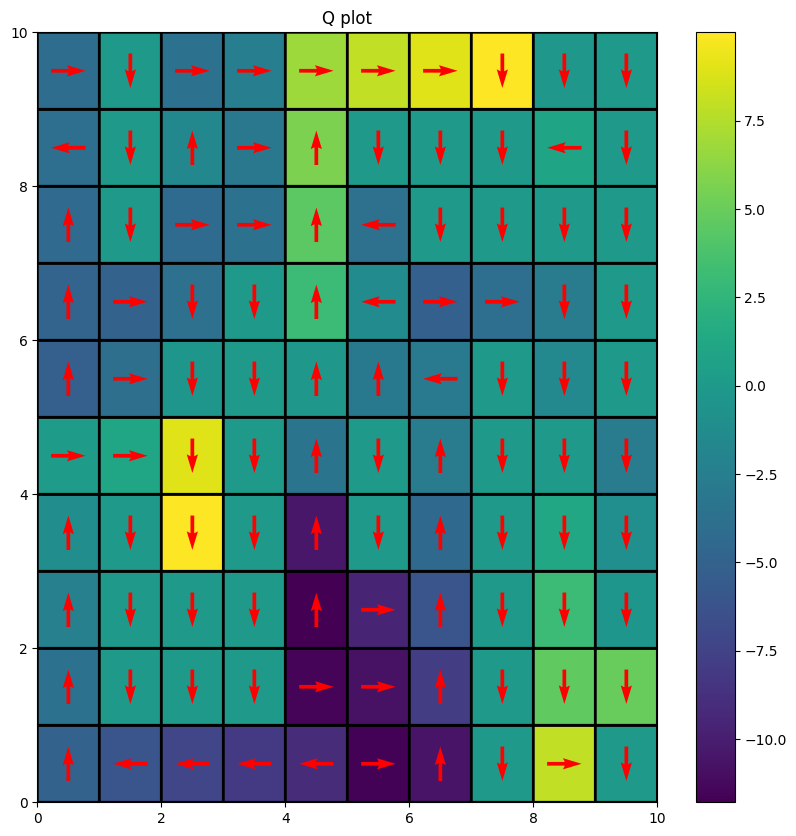

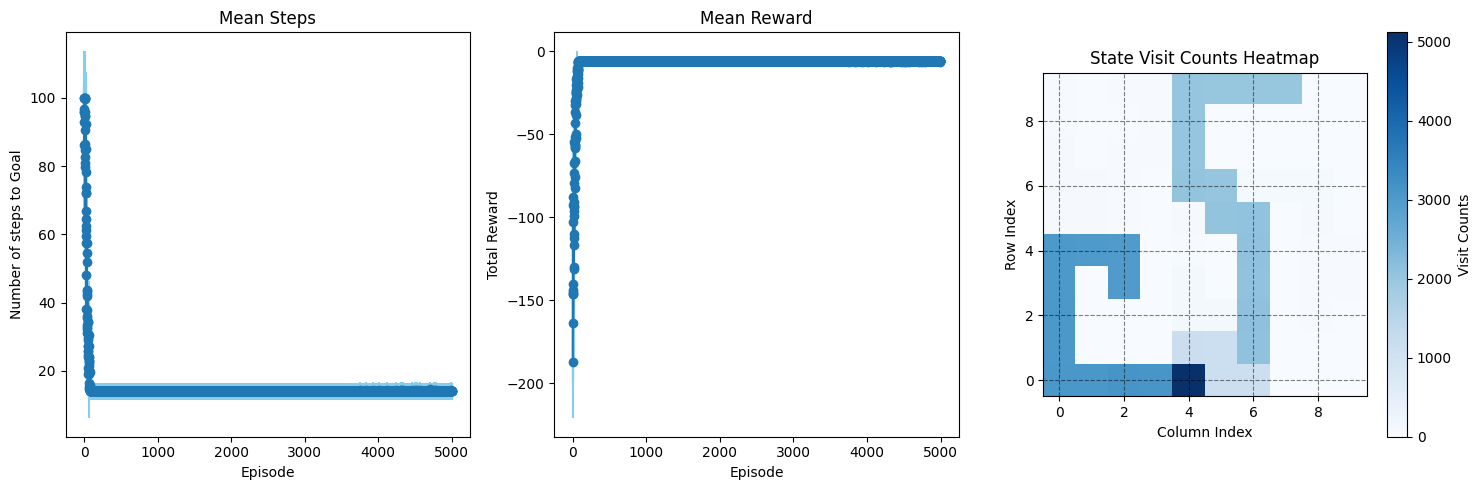

Average reward across all the runs =  -6.757039999999999
Average steps across all the runs =  14.6046


In [111]:

alpha0= 0.48418889267307225
gamma= 0.994020161163026
tau= 0.5160495203206044
plot_all(sarsa_s,env1)

In [ ]:
# visualizing_env(env3)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env3)
# plot_all(sarsa_e,env3)
# plot_all(qlearning_s,env3)
# plot_all(qlearning_e,env3)

In [112]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env1,qlearning_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.3704920428476948, 'gamma': 0.8777445380032771, 'epsilon_tau': 0.8714109514743811}, {'alpha': 0.22613312134051702, 'gamma': 0.8453694970007708, 'epsilon_tau': 0.5691502913239674}, {'alpha': 0.35206961350689736, 'gamma': 0.8083138147122412, 'epsilon_tau': 0.7925406631537992}, {'alpha': 0.4810223252532555, 'gamma': 0.8534955681107437, 'epsilon_tau': 0.8785733421817019}, {'alpha': 0.46904109128970556, 'gamma': 0.8233727492538948, 'epsilon_tau': 0.7039051746844796}, {'alpha': 0.42056994814993154, 'gamma': 0.8906392481266275, 'epsilon_tau': 0.9546827760673244}, {'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439}, {'alpha': 0.23022401909270468, 'gamma': 0.8889672761004386, 'epsilon_tau': 0.8567696331977387}, {'alpha': 0.2690320211126919, 'gamma': 0.8215739886271073, 'epsilon_tau': 0.7633509571422514}, {'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 221.28it/s]


34.63
-26.4466 34.63
{'alpha': 0.3704920428476948, 'gamma': 0.8777445380032771, 'epsilon_tau': 0.8714109514743811, 'mean_rewards': -26.4466} -26.4466
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 241.89it/s]


31.4062
-23.2982 31.4062
{'alpha': 0.22613312134051702, 'gamma': 0.8453694970007708, 'epsilon_tau': 0.5691502913239674, 'mean_rewards': -23.2982} -23.2982
Experiment: 1


100%|██████████| 5000/5000 [00:31<00:00, 159.38it/s]


52.3798
-44.7048 52.3798
{'alpha': 0.35206961350689736, 'gamma': 0.8083138147122412, 'epsilon_tau': 0.7925406631537992, 'mean_rewards': -44.7048} -44.7048
Experiment: 1


100%|██████████| 5000/5000 [00:25<00:00, 195.36it/s]


41.6306
-33.4968 41.6306
{'alpha': 0.4810223252532555, 'gamma': 0.8534955681107437, 'epsilon_tau': 0.8785733421817019, 'mean_rewards': -33.4968} -33.4968
Experiment: 1


100%|██████████| 5000/5000 [00:27<00:00, 181.75it/s]


43.4722
-35.3094 43.4722
{'alpha': 0.46904109128970556, 'gamma': 0.8233727492538948, 'epsilon_tau': 0.7039051746844796, 'mean_rewards': -35.3094} -35.3094
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 253.94it/s]


34.5728
-26.4888 34.5728
{'alpha': 0.42056994814993154, 'gamma': 0.8906392481266275, 'epsilon_tau': 0.9546827760673244, 'mean_rewards': -26.4888} -26.4888
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 444.28it/s]


18.9252
-11.7294 18.9252
{'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -11.7294} -11.7294
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 258.33it/s]


32.5044
-24.508 32.5044
{'alpha': 0.23022401909270468, 'gamma': 0.8889672761004386, 'epsilon_tau': 0.8567696331977387, 'mean_rewards': -24.508} -24.508
Experiment: 1


100%|██████████| 5000/5000 [00:26<00:00, 191.22it/s]


46.6202
-38.5544 46.6202
{'alpha': 0.2690320211126919, 'gamma': 0.8215739886271073, 'epsilon_tau': 0.7633509571422514, 'mean_rewards': -38.5544} -38.5544
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 456.37it/s]


19.486
-9.6234 19.486
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -9.6234} -9.6234
[{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -9.6234, 'mean_steps': 19.486}, {'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -11.7294, 'mean_steps': 18.9252}, {'alpha': 0.22613312134051702, 'gamma': 0.8453694970007708, 'epsilon_tau': 0.5691502913239674, 'mean_rewards': -23.2982, 'mean_steps': 31.4062}, {'alpha': 0.23022401909270468, 'gamma': 0.8889672761004386, 'epsilon_tau': 0.8567696331977387, 'mean_rewards': -24.508, 'mean_steps': 32.5044}]
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -9.6234, 'mean_steps': 19.486}

Best Hyperparameters: {'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971}
Best Mean Rewards

100%|██████████| 5000/5000 [00:10<00:00, 484.51it/s]


19.5258
-13.6646 19.5258
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -13.6646, 'mean_steps': 19.486} -13.6646
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 471.99it/s]


18.7448
-10.279 18.7448
{'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -10.279, 'mean_steps': 18.9252} -10.279
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 275.89it/s]


31.75
-23.5286 31.75
{'alpha': 0.22613312134051702, 'gamma': 0.8453694970007708, 'epsilon_tau': 0.5691502913239674, 'mean_rewards': -23.5286, 'mean_steps': 31.4062} -23.5286
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 273.41it/s]


32.0048
-23.8882 32.0048
{'alpha': 0.23022401909270468, 'gamma': 0.8889672761004386, 'epsilon_tau': 0.8567696331977387, 'mean_rewards': -23.8882, 'mean_steps': 32.5044} -23.8882
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 431.05it/s]


19.5756
-13.0212 19.5756
{'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -13.0212, 'mean_steps': 18.9252} -13.0212
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 250.65it/s]


31.1348
-23.0796 31.1348
{'alpha': 0.22613312134051702, 'gamma': 0.8453694970007708, 'epsilon_tau': 0.5691502913239674, 'mean_rewards': -23.0796, 'mean_steps': 31.4062} -23.0796
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 396.36it/s]


19.2558
-8.6394 19.2558
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -8.6394, 'mean_steps': 19.486} -8.6394
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 349.59it/s]


22.1632
-14.1658 22.1632
{'alpha': 0.3916273347611081, 'gamma': 0.8889672761004386, 'epsilon_tau': 0.5496830942808447, 'mean_rewards': -14.1658, 'mean_steps': 31.4062} -14.1658
Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 306.17it/s]


25.7938
-17.7984 25.7938
{'alpha': 0.23022401909270468, 'gamma': 0.8889672761004386, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -17.7984, 'mean_steps': 18.9252} -17.7984
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 360.78it/s]


23.1514
-15.257 23.1514
{'alpha': 0.23022401909270468, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.8567696331977387, 'mean_rewards': -15.257, 'mean_steps': 18.9252} -15.257
[{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -8.6394, 'mean_steps': 19.2558}, {'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -10.279, 'mean_steps': 18.7448}, {'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -13.0212, 'mean_steps': 19.5756}, {'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -13.6646, 'mean_steps': 19.5258}]
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -8.6394, 'mean_steps': 19.2558}

Best Hyperparameters: {'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.786385492

100%|██████████| 5000/5000 [00:13<00:00, 377.60it/s]


19.7236
-10.0052 19.7236
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -10.0052, 'mean_steps': 19.2558} -10.0052
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 411.12it/s]


18.781
-10.6004 18.781
{'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -10.6004, 'mean_steps': 18.7448} -10.6004
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 439.52it/s]


18.0312
-10.6446 18.0312
{'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -10.6446, 'mean_steps': 19.5756} -10.6446
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 457.34it/s]


16.9782
-11.1186 16.9782
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -11.1186, 'mean_steps': 19.5258} -11.1186
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 409.26it/s]


19.2338
-11.792 19.2338
{'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -11.792, 'mean_steps': 19.2558} -11.792
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 402.85it/s]


18.2464
-7.5062 18.2464
{'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.5062, 'mean_steps': 19.5258} -7.5062
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 396.04it/s]


18.5758
-7.7962 18.5758
{'alpha': 0.4170516071792555, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -7.7962, 'mean_steps': 19.2558} -7.7962
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 370.43it/s]


22.0264
-11.2506 22.0264
{'alpha': 0.4170516071792555, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -11.2506, 'mean_steps': 19.5756} -11.2506
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 501.05it/s]


17.5688
-8.7784 17.5688
{'alpha': 0.2595247488376227, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -8.7784, 'mean_steps': 19.5756} -8.7784
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 416.52it/s]


21.824
-14.1574 21.824
{'alpha': 0.3397187890559672, 'gamma': 0.9436496290834739, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -14.1574, 'mean_steps': 19.5258} -14.1574
[{'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.5062, 'mean_steps': 18.2464}, {'alpha': 0.2595247488376227, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -8.7784, 'mean_steps': 17.5688}, {'alpha': 0.4170516071792555, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -7.7962, 'mean_steps': 18.5758}, {'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -11.1186, 'mean_steps': 16.9782}]
{'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.5062, 'mean_steps': 18.2464}

Best Hyperparameters: {'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497

100%|██████████| 5000/5000 [00:07<00:00, 675.66it/s]


13.1292
-7.2546 13.1292
{'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.2546, 'mean_steps': 18.2464} -7.2546
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 399.65it/s]


19.5932
-9.6204 19.5932
{'alpha': 0.2595247488376227, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -9.6204, 'mean_steps': 17.5688} -9.6204
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 436.65it/s]


18.303
-7.513 18.303
{'alpha': 0.4170516071792555, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -7.513, 'mean_steps': 18.5758} -7.513
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 380.11it/s]


20.2318
-9.4726 20.2318
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -9.4726, 'mean_steps': 16.9782} -9.4726
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 393.81it/s]


21.0678
-10.317 21.0678
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -10.317, 'mean_steps': 0.16741104918679509} -10.317
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 617.82it/s]


14.1816
-8.3324 14.1816
{'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -8.3324, 'mean_steps': 18.5758} -8.3324
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 534.02it/s]


16.372
-9.734 16.372
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -9.734, 'mean_steps': 18.5758} -9.734
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 648.08it/s]


13.3922
-7.5152 13.3922
{'alpha': 0.2721383666874194, 'gamma': 0.969268628282644, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.5152, 'mean_steps': 18.2464} -7.5152
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 420.57it/s]


18.2042
-7.4436 18.2042
{'alpha': 0.3397187890559672, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -7.4436, 'mean_steps': 18.5758} -7.4436
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 528.97it/s]


15.9414
-8.9968 15.9414
{'alpha': 0.2595247488376227, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -8.9968, 'mean_steps': 16.9782} -8.9968
[{'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.2546, 'mean_steps': 13.1292}, {'alpha': 0.2721383666874194, 'gamma': 0.969268628282644, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.5152, 'mean_steps': 13.3922}, {'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -8.3324, 'mean_steps': 14.1816}, {'alpha': 0.2595247488376227, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -8.9968, 'mean_steps': 15.9414}]
{'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.2546, 'mean_steps': 13.1292}

Best Hyperparameters: {'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497832

100%|██████████| 5000/5000 [00:11<00:00, 432.13it/s]


18.0552
-7.3102 18.0552
{'alpha': 0.2721383666874194, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.3102, 'mean_steps': 13.1292} -7.3102
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 585.62it/s]


14.5884
-8.7364 14.5884
{'alpha': 0.2721383666874194, 'gamma': 0.969268628282644, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -8.7364, 'mean_steps': 13.3922} -8.7364
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 440.28it/s]


18.212
-7.4732 18.212
{'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -7.4732, 'mean_steps': 14.1816} -7.4732
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 471.32it/s]


18.4484
-12.6162 18.4484
{'alpha': 0.2595247488376227, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -12.6162, 'mean_steps': 15.9414} -12.6162
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 607.42it/s]


14.5638
-8.708 14.5638
{'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -8.708, 'mean_steps': 14.1816} -8.708
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 512.51it/s]


17.5986
-11.719 17.5986
{'alpha': 0.2595247488376227, 'gamma': 0.9768549382343356, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -11.719, 'mean_steps': 15.9414} -11.719
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 676.76it/s]


13.0602
-7.1944 13.0602
{'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.1944, 'mean_steps': 0.1247216480223001} -7.1944
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 552.37it/s]


16.1996
-10.3234 16.1996
{'alpha': 0.2595247488376227, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.7863854924088971, 'mean_rewards': -10.3234, 'mean_steps': 14.1816} -10.3234
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 434.44it/s]


18.4
-7.6476 18.4
{'alpha': 0.2857957030391741, 'gamma': 0.969268628282644, 'epsilon_tau': 0.5671424372999418, 'mean_rewards': -7.6476, 'mean_steps': 15.9414} -7.6476
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 629.28it/s]

13.4884
-7.612 13.4884
{'alpha': 0.2721383666874194, 'gamma': 0.969268628282644, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.612, 'mean_steps': 0.18385708301254206} -7.612
[{'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.1944, 'mean_steps': 13.0602}, {'alpha': 0.2721383666874194, 'gamma': 0.969268628282644, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.612, 'mean_steps': 13.4884}, {'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.6599282535233439, 'mean_rewards': -8.708, 'mean_steps': 14.5638}, {'alpha': 0.2721383666874194, 'gamma': 0.969268628282644, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -8.7364, 'mean_steps': 14.5884}]
{'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.5437618497832755, 'mean_rewards': -7.1944, 'mean_steps': 13.0602}

Best Hyperparameters: {'alpha': 0.2721383666874194, 'gamma': 0.9903736149273875, 'epsilon_tau': 0.54376184

Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 428.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 627.78it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 640.52it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:11<00:00, 453.53it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:07<00:00, 678.21it/s]


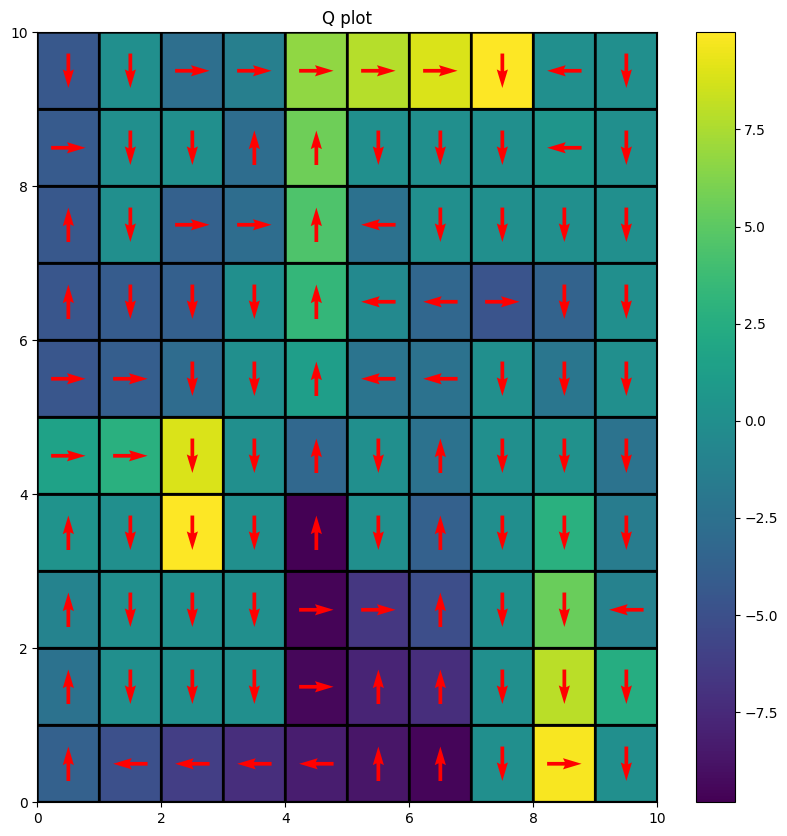

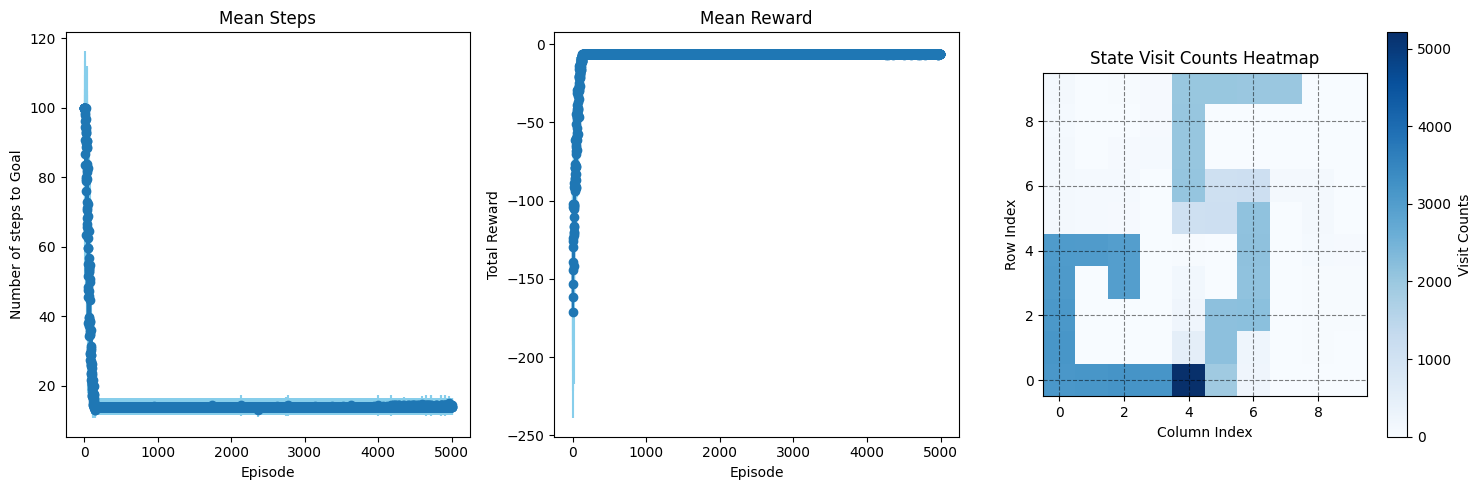

Average reward across all the runs =  -7.26288
Average steps across all the runs =  15.0772


In [113]:
alpha0=0.2721383666874194
gamma=0.9903736149273875
tau=0.5437618497832755
plot_all(qlearning_s,env1)

In [114]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env1,qlearning_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.3708409518038147, 'gamma': 0.9150837260947662, 'epsilon_tau': 0.2298626290444054}, {'alpha': 0.22093500360755283, 'gamma': 0.932308311458422, 'epsilon_tau': 0.14758169892427014}, {'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408}, {'alpha': 0.2579678911468326, 'gamma': 0.8259809971245649, 'epsilon_tau': 0.2177549762117449}, {'alpha': 0.31611572341044714, 'gamma': 0.88407994016015, 'epsilon_tau': 0.16396185848359246}, {'alpha': 0.4296221283600236, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848}, {'alpha': 0.3662219075184082, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.27958875100541963}, {'alpha': 0.41272151049799305, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697}, {'alpha': 0.21552215022094537, 'gamma': 0.8502733044687807, 'epsilon_tau': 0.055549207529132325}, {'alpha': 0.26058983210139963, 'gamma': 0.912813338915999, 'epsilon_tau': 0.2047961067882097}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 440.47it/s]


18.0428
-7.2532 18.0428
{'alpha': 0.3708409518038147, 'gamma': 0.9150837260947662, 'epsilon_tau': 0.2298626290444054, 'mean_rewards': -7.2532} -7.2532
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 459.95it/s]


18.0494
-7.298 18.0494
{'alpha': 0.22093500360755283, 'gamma': 0.932308311458422, 'epsilon_tau': 0.14758169892427014, 'mean_rewards': -7.298} -7.298
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 466.52it/s]


17.5732
-6.7496 17.5732
{'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7496} -6.7496
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 423.37it/s]


20.9004
-12.1128 20.9004
{'alpha': 0.2579678911468326, 'gamma': 0.8259809971245649, 'epsilon_tau': 0.2177549762117449, 'mean_rewards': -12.1128} -12.1128
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 461.89it/s]


18.0132
-7.2306 18.0132
{'alpha': 0.31611572341044714, 'gamma': 0.88407994016015, 'epsilon_tau': 0.16396185848359246, 'mean_rewards': -7.2306} -7.2306
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 476.56it/s]


17.5856
-6.7684 17.5856
{'alpha': 0.4296221283600236, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -6.7684} -6.7684
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 519.12it/s]


16.4818
-8.6644 16.4818
{'alpha': 0.3662219075184082, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.27958875100541963, 'mean_rewards': -8.6644} -8.6644
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 461.21it/s]


17.8762
-7.061 17.8762
{'alpha': 0.41272151049799305, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.061} -7.061
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 463.05it/s]


18.0522
-7.283 18.0522
{'alpha': 0.21552215022094537, 'gamma': 0.8502733044687807, 'epsilon_tau': 0.055549207529132325, 'mean_rewards': -7.283} -7.283
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 454.03it/s]


18.1304
-7.372 18.1304
{'alpha': 0.26058983210139963, 'gamma': 0.912813338915999, 'epsilon_tau': 0.2047961067882097, 'mean_rewards': -7.372} -7.372
[{'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7496, 'mean_steps': 17.5732}, {'alpha': 0.4296221283600236, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -6.7684, 'mean_steps': 17.5856}, {'alpha': 0.41272151049799305, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.061, 'mean_steps': 17.8762}, {'alpha': 0.3662219075184082, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.27958875100541963, 'mean_rewards': -8.6644, 'mean_steps': 16.4818}]
{'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7496, 'mean_steps': 17.5732}

Best Hyperparameters: {'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408}
Best Mean Reward

100%|██████████| 5000/5000 [00:11<00:00, 445.91it/s]


17.5826
-6.7762 17.5826
{'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7762, 'mean_steps': 17.5732} -6.7762
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 466.08it/s]


17.6196
-6.7984 17.6196
{'alpha': 0.4296221283600236, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -6.7984, 'mean_steps': 17.5856} -6.7984
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 468.70it/s]


17.8808
-7.0536 17.8808
{'alpha': 0.41272151049799305, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.0536, 'mean_steps': 17.8762} -7.0536
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 564.55it/s]


15.925
-8.6268 15.925
{'alpha': 0.3662219075184082, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.27958875100541963, 'mean_rewards': -8.6268, 'mean_steps': 16.4818} -8.6268
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 502.43it/s]


17.5184
-8.253 17.5184
{'alpha': 0.4296221283600236, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -8.253, 'mean_steps': 17.5856} -8.253
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 478.72it/s]


17.8016
-7.0236 17.8016
{'alpha': 0.2624477157807565, 'gamma': 0.973814538291852, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.0236, 'mean_steps': 17.5732} -7.0236
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 616.28it/s]


14.6404
-7.525 14.6404
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.525, 'mean_steps': 17.5856} -7.525
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 491.45it/s]


17.665
-8.8036 17.665
{'alpha': 0.3662219075184082, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.27958875100541963, 'mean_rewards': -8.8036, 'mean_steps': 0.234160079011599} -8.8036
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 482.99it/s]


17.6254
-6.8164 17.6254
{'alpha': 0.4296221283600236, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.27958875100541963, 'mean_rewards': -6.8164, 'mean_steps': 17.5856} -6.8164
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 644.45it/s]


14.0522
-7.6822 14.0522
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.6822, 'mean_steps': 17.5732} -7.6822
[{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.6822, 'mean_steps': 14.0522}, {'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.525, 'mean_steps': 14.6404}, {'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7762, 'mean_steps': 17.5826}, {'alpha': 0.4296221283600236, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -6.7984, 'mean_steps': 17.6196}]
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.6822, 'mean_steps': 14.0522}

Best Hyperparameters: {'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.2371

100%|██████████| 5000/5000 [00:08<00:00, 568.58it/s]


15.6192
-7.8332 15.6192
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.8332, 'mean_steps': 14.0522} -7.8332
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 690.47it/s]


13.4514
-7.3924 13.4514
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.3924, 'mean_steps': 14.6404} -7.3924
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 483.95it/s]


17.5456
-6.7218 17.5456
{'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7218, 'mean_steps': 17.5826} -6.7218
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 507.11it/s]


17.6452
-6.8418 17.6452
{'alpha': 0.4296221283600236, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -6.8418, 'mean_steps': 17.6196} -6.8418
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 666.55it/s]


15.879
-8.6224 15.879
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -8.6224, 'mean_steps': 14.6404} -8.6224
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 424.40it/s]


19.117
-8.3318 19.117
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -8.3318, 'mean_steps': 17.5826} -8.3318
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 455.66it/s]


18.1456
-7.421 18.1456
{'alpha': 0.20500204227825902, 'gamma': 0.9627942692949593, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.421, 'mean_steps': 14.6404} -7.421
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 452.78it/s]


18.1404
-7.4138 18.1404
{'alpha': 0.20500204227825902, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -7.4138, 'mean_steps': 0.20098399963273633} -7.4138
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 478.93it/s]


17.6388
-6.8266 17.6388
{'alpha': 0.44822960240135373, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -6.8266, 'mean_steps': 17.6196} -6.8266
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 494.58it/s]


17.9818
-7.1778 17.9818
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.1583411985071038, 'mean_rewards': -7.1778, 'mean_steps': 14.0522} -7.1778
[{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.3924, 'mean_steps': 13.4514}, {'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.8332, 'mean_steps': 15.6192}, {'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7218, 'mean_steps': 17.5456}, {'alpha': 0.44822960240135373, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -6.8266, 'mean_steps': 17.6388}]
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.3924, 'mean_steps': 13.4514}

Best Hyperparameters: {'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355

100%|██████████| 5000/5000 [00:07<00:00, 693.57it/s]


13.4344
-7.5224 13.4344
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.5224, 'mean_steps': 13.4514} -7.5224
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 504.82it/s]


16.1234
-7.9054 16.1234
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.9054, 'mean_steps': 15.6192} -7.9054
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 441.54it/s]


17.5604
-6.7386 17.5604
{'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7386, 'mean_steps': 17.5456} -6.7386
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 387.99it/s]


17.5808
-6.7656 17.5808
{'alpha': 0.44822960240135373, 'gamma': 0.9634829407092498, 'epsilon_tau': 0.2515935405684848, 'mean_rewards': -6.7656, 'mean_steps': 17.6388} -6.7656
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 530.91it/s]


14.4238
-7.5446 14.4238
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.5446, 'mean_steps': 0.17695249788382367} -7.5446
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 599.96it/s]


13.208
-7.3044 13.208
{'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.3044, 'mean_steps': 13.4514} -7.3044
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 462.90it/s]


15.9674
-8.1332 15.9674
{'alpha': 0.2498739532932981, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -8.1332, 'mean_steps': 15.6192} -8.1332
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 409.54it/s]


17.752
-6.9174 17.752
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -6.9174, 'mean_steps': 15.6192} -6.9174
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 502.18it/s]


14.627
-7.9388 14.627
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.9388, 'mean_steps': 15.6192} -7.9388
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 452.08it/s]


17.539
-6.7296 17.539
{'alpha': 0.44822960240135373, 'gamma': 0.973814538291852, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7296, 'mean_steps': 17.5456} -6.7296
[{'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.3044, 'mean_steps': 13.208}, {'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.5224, 'mean_steps': 13.4344}, {'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.5446, 'mean_steps': 14.4238}, {'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.9388, 'mean_steps': 14.627}]
{'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.3044, 'mean_steps': 13.208}

Best Hyperparameters: {'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.135534029

100%|██████████| 5000/5000 [00:09<00:00, 546.12it/s]


13.1264
-7.2398 13.1264
{'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.2398, 'mean_steps': 13.208} -7.2398
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 596.43it/s]


13.3426
-7.4228 13.3426
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.4228, 'mean_steps': 13.4344} -7.4228
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 419.94it/s]


18.3158
-7.5678 18.3158
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.5678, 'mean_steps': 14.4238} -7.5678
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 480.45it/s]


14.9632
-7.5584 14.9632
{'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.5584, 'mean_steps': 14.627} -7.5584
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 392.78it/s]


18.3316
-7.5858 18.3316
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.5858, 'mean_steps': 13.4344} -7.5858
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 453.28it/s]


17.3532
-7.8608 17.3532
{'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1747877176675381, 'mean_rewards': -7.8608, 'mean_steps': 13.4344} -7.8608
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.89it/s]


17.5982
-6.7872 17.5982
{'alpha': 0.44822960240135373, 'gamma': 0.9599967202134725, 'epsilon_tau': 0.1676203396393658, 'mean_rewards': -6.7872, 'mean_steps': 14.4238} -6.7872
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 420.61it/s]


18.0548
-7.3224 18.0548
{'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.3224, 'mean_steps': 14.4238} -7.3224
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 661.32it/s]


13.1632
-7.2616 13.1632
{'alpha': 0.20500204227825902, 'gamma': 0.9741497503546761, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.2616, 'mean_steps': 13.208} -7.2616
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 462.40it/s]

17.5358
-6.7174 17.5358
{'alpha': 0.44822960240135373, 'gamma': 0.9835134734575252, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -6.7174, 'mean_steps': 14.627} -6.7174
[{'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.2398, 'mean_steps': 13.1264}, {'alpha': 0.20500204227825902, 'gamma': 0.9741497503546761, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.2616, 'mean_steps': 13.1632}, {'alpha': 0.20500204227825902, 'gamma': 0.8728860496174067, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.4228, 'mean_steps': 13.3426}, {'alpha': 0.44822960240135373, 'gamma': 0.8776118113567035, 'epsilon_tau': 0.23713954707442408, 'mean_rewards': -7.5584, 'mean_steps': 14.9632}]
{'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.1355340297360697, 'mean_rewards': -7.2398, 'mean_steps': 13.1264}

Best Hyperparameters: {'alpha': 0.20500204227825902, 'gamma': 0.9581635997623626, 'epsilon_tau': 0.1355

Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 612.84it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 677.63it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 450.61it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:11<00:00, 450.42it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:10<00:00, 456.44it/s]


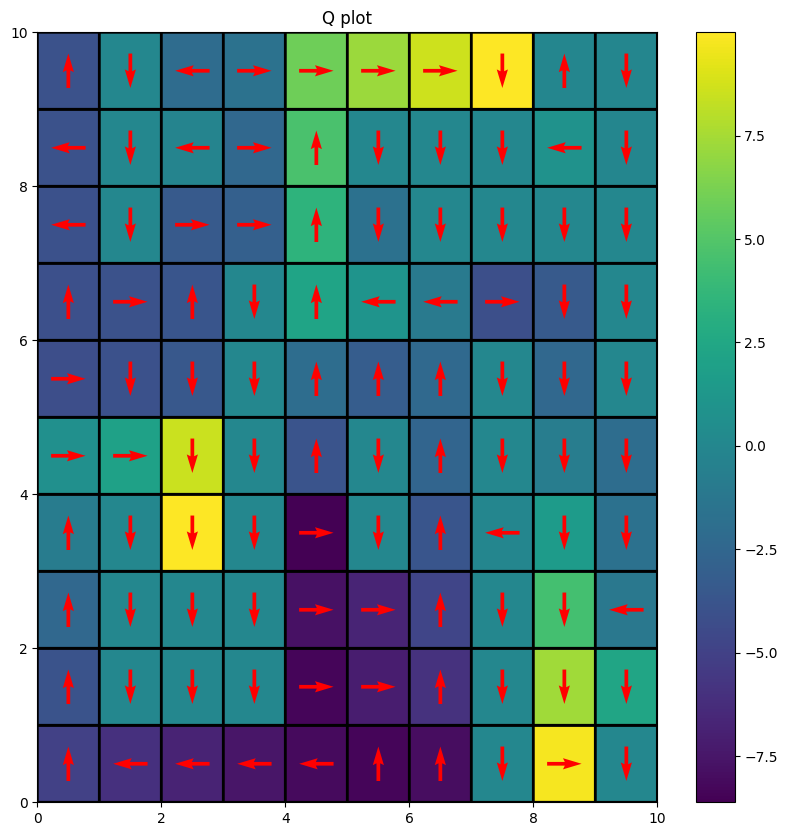

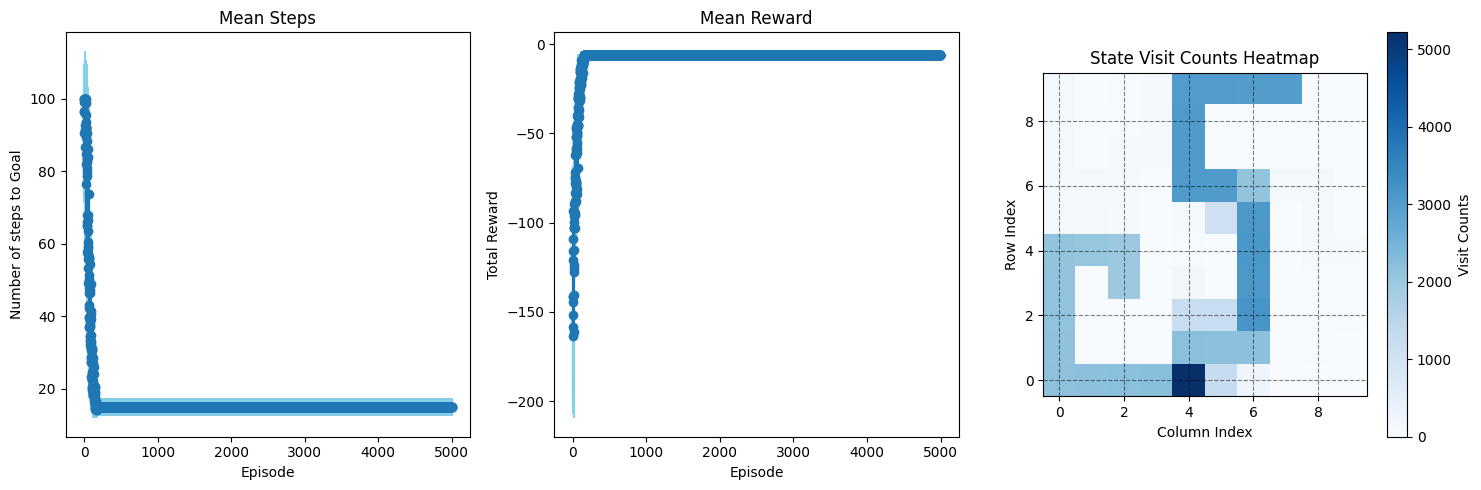

Average reward across all the runs =  -7.3116
Average steps across all the runs =  16.1124


In [115]:
alpha0= 0.20500204227825902
epsilon0= 0.1355340297360697
gamma= 0.9581635997623626
plot_all(qlearning_e,env1)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


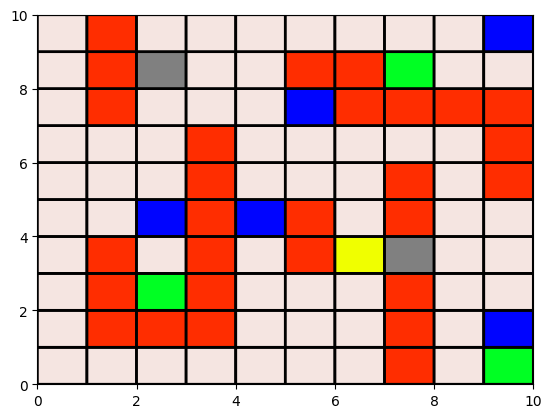

In [116]:
visualizing_env(env2)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env2)
# plot_all(sarsa_e,env2)
# plot_all(qlearning_s,env2)
# plot_all(qlearning_e,env2)

In [117]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env2,qlearning_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.4983356473222716, 'gamma': 0.8552109913356895, 'epsilon_tau': 0.17869964775806318}, {'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338}, {'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645}, {'alpha': 0.3605131140634418, 'gamma': 0.8945063047760747, 'epsilon_tau': 0.29358918210754276}, {'alpha': 0.279729406586753, 'gamma': 0.9192108143660469, 'epsilon_tau': 0.28685900992154456}, {'alpha': 0.37886585868483547, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.16260208074030824}, {'alpha': 0.2641725974347956, 'gamma': 0.9158211020503664, 'epsilon_tau': 0.14599082916295747}, {'alpha': 0.21542990362816714, 'gamma': 0.9864782235349706, 'epsilon_tau': 0.05976293046023505}, {'alpha': 0.25887111486355024, 'gamma': 0.8136934443913587, 'epsilon_tau': 0.227268248803484}, {'alpha': 0.29238498726601486, 'gamma': 0.8077087706257168, 'epsilon_tau': 0.1405311027851423}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 495.77it/s]


12.6276
-1.7914 12.6276
{'alpha': 0.4983356473222716, 'gamma': 0.8552109913356895, 'epsilon_tau': 0.17869964775806318, 'mean_rewards': -1.7914} -1.7914
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 346.41it/s]


12.5892
-1.7804 12.5892
{'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.7804} -1.7804
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 419.29it/s]


12.4864
-1.6668 12.4864
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6668} -1.6668
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 421.04it/s]


12.861
-2.0624 12.861
{'alpha': 0.3605131140634418, 'gamma': 0.8945063047760747, 'epsilon_tau': 0.29358918210754276, 'mean_rewards': -2.0624} -2.0624
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 430.59it/s]


12.7188
-1.9234 12.7188
{'alpha': 0.279729406586753, 'gamma': 0.9192108143660469, 'epsilon_tau': 0.28685900992154456, 'mean_rewards': -1.9234} -1.9234
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 426.41it/s]


12.5638
-1.7434 12.5638
{'alpha': 0.37886585868483547, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.16260208074030824, 'mean_rewards': -1.7434} -1.7434
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 424.05it/s]


12.7466
-1.9466 12.7466
{'alpha': 0.2641725974347956, 'gamma': 0.9158211020503664, 'epsilon_tau': 0.14599082916295747, 'mean_rewards': -1.9466} -1.9466
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 381.91it/s]


12.7508
-1.9522 12.7508
{'alpha': 0.21542990362816714, 'gamma': 0.9864782235349706, 'epsilon_tau': 0.05976293046023505, 'mean_rewards': -1.9522} -1.9522
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 362.67it/s]


14.366
-3.5902 14.366
{'alpha': 0.25887111486355024, 'gamma': 0.8136934443913587, 'epsilon_tau': 0.227268248803484, 'mean_rewards': -3.5902} -3.5902
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 404.72it/s]


13.1502
-2.3572 13.1502
{'alpha': 0.29238498726601486, 'gamma': 0.8077087706257168, 'epsilon_tau': 0.1405311027851423, 'mean_rewards': -2.3572} -2.3572
[{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6668, 'mean_steps': 12.4864}, {'alpha': 0.37886585868483547, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.16260208074030824, 'mean_rewards': -1.7434, 'mean_steps': 12.5638}, {'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.7804, 'mean_steps': 12.5892}, {'alpha': 0.4983356473222716, 'gamma': 0.8552109913356895, 'epsilon_tau': 0.17869964775806318, 'mean_rewards': -1.7914, 'mean_steps': 12.6276}]
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6668, 'mean_steps': 12.4864}

Best Hyperparameters: {'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645}
Best Mean 

100%|██████████| 5000/5000 [00:11<00:00, 417.91it/s]


12.4206
-1.592 12.4206
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.592, 'mean_steps': 12.4864} -1.592
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 424.60it/s]


12.5534
-1.7298 12.5534
{'alpha': 0.37886585868483547, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.16260208074030824, 'mean_rewards': -1.7298, 'mean_steps': 12.5638} -1.7298
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 413.21it/s]


12.5602
-1.7364 12.5602
{'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.7364, 'mean_steps': 12.5892} -1.7364
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 444.91it/s]


12.624
-1.7992 12.624
{'alpha': 0.4983356473222716, 'gamma': 0.8552109913356895, 'epsilon_tau': 0.17869964775806318, 'mean_rewards': -1.7992, 'mean_steps': 12.6276} -1.7992
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 405.64it/s]


12.5504
-1.7276 12.5504
{'alpha': 0.3612672086217938, 'gamma': 0.9980312069209307, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.7276, 'mean_steps': 12.5892} -1.7276
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 415.37it/s]


12.5656
-1.745 12.5656
{'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.745, 'mean_steps': 12.6276} -1.745
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 413.33it/s]


12.5898
-1.765 12.5898
{'alpha': 0.37886585868483547, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.16260208074030824, 'mean_rewards': -1.765, 'mean_steps': 12.4864} -1.765
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 414.13it/s]


12.5738
-1.7534 12.5738
{'alpha': 0.37886585868483547, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.16260208074030824, 'mean_rewards': -1.7534, 'mean_steps': 0.15750642074800347} -1.7534
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 421.43it/s]


12.6108
-1.7954 12.6108
{'alpha': 0.30856529978361047, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.7954, 'mean_steps': 12.4864} -1.7954
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 416.23it/s]


12.8698
-2.0866 12.8698
{'alpha': 0.22720916644434916, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.17869964775806318, 'mean_rewards': -2.0866, 'mean_steps': 12.6276} -2.0866
[{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.592, 'mean_steps': 12.4206}, {'alpha': 0.3612672086217938, 'gamma': 0.9980312069209307, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.7276, 'mean_steps': 12.5504}, {'alpha': 0.37886585868483547, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.16260208074030824, 'mean_rewards': -1.7298, 'mean_steps': 12.5534}, {'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.7364, 'mean_steps': 12.5602}]
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.592, 'mean_steps': 12.4206}

Best Hyperparameters: {'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412

100%|██████████| 5000/5000 [00:12<00:00, 411.47it/s]


12.4186
-1.5848 12.4186
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5848, 'mean_steps': 12.4206} -1.5848
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 408.02it/s]


12.604
-1.8038 12.604
{'alpha': 0.3612672086217938, 'gamma': 0.9980312069209307, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.8038, 'mean_steps': 12.5504} -1.8038
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 453.34it/s]


12.6132
-1.8 12.6132
{'alpha': 0.37886585868483547, 'gamma': 0.9344284817035827, 'epsilon_tau': 0.16260208074030824, 'mean_rewards': -1.8, 'mean_steps': 12.5534} -1.8
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 448.28it/s]


12.5834
-1.7692 12.5834
{'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.7692, 'mean_steps': 12.5602} -1.7692
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 406.08it/s]


12.6758
-1.8722 12.6758
{'alpha': 0.3015808210756312, 'gamma': 0.9656684194875056, 'epsilon_tau': 0.16260208074030824, 'mean_rewards': -1.8722, 'mean_steps': 12.5602} -1.8722
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 416.28it/s]


12.4514
-1.6128 12.4514
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6128, 'mean_steps': 12.4206} -1.6128
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 460.56it/s]


12.6498
-1.837 12.6498
{'alpha': 0.3612672086217938, 'gamma': 0.9510826507558177, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.837, 'mean_steps': 12.4206} -1.837
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 426.73it/s]


12.6036
-1.7954 12.6036
{'alpha': 0.37886585868483547, 'gamma': 0.9917933216898661, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.7954, 'mean_steps': 12.5534} -1.7954
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 428.04it/s]


12.6244
-1.81 12.6244
{'alpha': 0.29913119280668854, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.81, 'mean_steps': 0.20157386466064403} -1.81
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 434.35it/s]


12.4216
-1.5852 12.4216
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5852, 'mean_steps': 0.17245941758290761} -1.5852
[{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5848, 'mean_steps': 12.4186}, {'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5852, 'mean_steps': 12.4216}, {'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6128, 'mean_steps': 12.4514}, {'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.7692, 'mean_steps': 12.5834}]
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5848, 'mean_steps': 12.4186}

Best Hyperparameters: {'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau

100%|██████████| 5000/5000 [00:11<00:00, 422.66it/s]


12.461
-1.6326 12.461
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6326, 'mean_steps': 12.4186} -1.6326
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.16it/s]


12.5002
-1.6746 12.5002
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6746, 'mean_steps': 12.4216} -1.6746
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 457.33it/s]


12.5072
-1.6802 12.5072
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6802, 'mean_steps': 12.4514} -1.6802
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 408.30it/s]


12.6094
-1.8018 12.6094
{'alpha': 0.3612672086217938, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.8018, 'mean_steps': 12.5834} -1.8018
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 419.66it/s]


12.5064
-1.6896 12.5064
{'alpha': 0.4973930775523683, 'gamma': 0.9527138883463283, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6896, 'mean_steps': 12.4514} -1.6896
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 428.01it/s]


12.4784
-1.6472 12.4784
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.6472, 'mean_steps': 0.12335455883537798} -1.6472
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 425.23it/s]


12.556
-1.729 12.556
{'alpha': 0.38419989514804154, 'gamma': 0.9856635228080739, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.729, 'mean_steps': 12.4216} -1.729
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 418.56it/s]


12.3758
-1.5416 12.3758
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5416, 'mean_steps': 12.4186} -1.5416
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 415.75it/s]


12.4588
-1.624 12.4588
{'alpha': 0.4973930775523683, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.624, 'mean_steps': 0.23885524376924927} -1.624
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 422.37it/s]


12.4766
-1.6498 12.4766
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6498, 'mean_steps': 12.4216} -1.6498
[{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5416, 'mean_steps': 12.3758}, {'alpha': 0.4973930775523683, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.624, 'mean_steps': 12.4588}, {'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6326, 'mean_steps': 12.461}, {'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.6472, 'mean_steps': 12.4784}]
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5416, 'mean_steps': 12.3758}

Best Hyperparameters: {'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.2214641273

100%|██████████| 5000/5000 [00:12<00:00, 414.13it/s]


12.4316
-1.6042 12.4316
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6042, 'mean_steps': 12.3758} -1.6042
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.46it/s]


12.4512
-1.6178 12.4512
{'alpha': 0.4973930775523683, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.6178, 'mean_steps': 12.4588} -1.6178
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 428.34it/s]


12.4554
-1.6266 12.4554
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.6266, 'mean_steps': 12.461} -1.6266
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 433.57it/s]


12.4274
-1.5858 12.4274
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.5858, 'mean_steps': 12.4784} -1.5858
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 436.33it/s]


12.4142
-1.5816 12.4142
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.21560333965309628, 'mean_rewards': -1.5816, 'mean_steps': 12.3758} -1.5816
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 417.35it/s]


12.4864
-1.6684 12.4864
{'alpha': 0.4973930775523683, 'gamma': 0.9857312479505244, 'epsilon_tau': 0.20602774848780295, 'mean_rewards': -1.6684, 'mean_steps': 0.12629383190810872} -1.6684
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 420.50it/s]


12.4512
-1.621 12.4512
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.621, 'mean_steps': 12.4784} -1.621
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 418.41it/s]


12.4156
-1.5738 12.4156
{'alpha': 0.4973930775523683, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.5738, 'mean_steps': 0.1372520123686397} -1.5738
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.48it/s]


12.4772
-1.6438 12.4772
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.6438, 'mean_steps': 0.1488844143532526} -1.6438
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 422.66it/s]

12.4348
-1.5978 12.4348
{'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5978, 'mean_steps': 0.14117616859381035} -1.5978
[{'alpha': 0.4973930775523683, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.5738, 'mean_steps': 12.4156}, {'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.21560333965309628, 'mean_rewards': -1.5816, 'mean_steps': 12.4142}, {'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.5858, 'mean_steps': 12.4274}, {'alpha': 0.4973930775523683, 'gamma': 0.9741909054416034, 'epsilon_tau': 0.22146412736372645, 'mean_rewards': -1.5978, 'mean_steps': 12.4348}]
{'alpha': 0.4973930775523683, 'gamma': 0.9902045351146334, 'epsilon_tau': 0.2488316328672338, 'mean_rewards': -1.5738, 'mean_steps': 12.4156}

Best Hyperparameters: {'alpha': 0.4973930775523683, 'gamma': 0.9902045351146334, 'epsilon_tau':

In [118]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env2,qlearning_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285}, {'alpha': 0.3176564340955012, 'gamma': 0.9177652190885291, 'epsilon_tau': 0.5716455932101678}, {'alpha': 0.4983733538931348, 'gamma': 0.9519337301949358, 'epsilon_tau': 0.9734132420694055}, {'alpha': 0.2923494285366242, 'gamma': 0.8974095517802699, 'epsilon_tau': 0.7341869557226681}, {'alpha': 0.4761056239155895, 'gamma': 0.8136093895564946, 'epsilon_tau': 0.8411748724512437}, {'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.8164062420173492}, {'alpha': 0.4168597026809371, 'gamma': 0.8786781981139032, 'epsilon_tau': 0.5613472308422867}, {'alpha': 0.4474177754881337, 'gamma': 0.9000716847364112, 'epsilon_tau': 0.5179619781417465}, {'alpha': 0.4771195357253162, 'gamma': 0.9549721823460315, 'epsilon_tau': 0.8968496351884696}, {'alpha': 0.2683960318107519, 'gamma': 0.8470315039107141, 'epsilon_tau': 0.7842285069123915}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 458.41it/s]


12.5094
-1.6804 12.5094
{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.6804} -1.6804
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 420.77it/s]


14.1656
-3.4056 14.1656
{'alpha': 0.3176564340955012, 'gamma': 0.9177652190885291, 'epsilon_tau': 0.5716455932101678, 'mean_rewards': -3.4056} -3.4056
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 456.67it/s]


17.2858
-6.5 17.2858
{'alpha': 0.4983733538931348, 'gamma': 0.9519337301949358, 'epsilon_tau': 0.9734132420694055, 'mean_rewards': -6.5} -6.5
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 402.96it/s]


17.0932
-6.3592 17.0932
{'alpha': 0.2923494285366242, 'gamma': 0.8974095517802699, 'epsilon_tau': 0.7341869557226681, 'mean_rewards': -6.3592} -6.3592
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 291.59it/s]


31.974
-21.7718 31.974
{'alpha': 0.4761056239155895, 'gamma': 0.8136093895564946, 'epsilon_tau': 0.8411748724512437, 'mean_rewards': -21.7718} -21.7718
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 686.99it/s]


15.1638
-4.3554 15.1638
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.8164062420173492, 'mean_rewards': -4.3554} -4.3554
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 620.47it/s]


15.4592
-4.6652 15.4592
{'alpha': 0.4168597026809371, 'gamma': 0.8786781981139032, 'epsilon_tau': 0.5613472308422867, 'mean_rewards': -4.6652} -4.6652
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 690.55it/s]


14.1656
-3.3466 14.1656
{'alpha': 0.4474177754881337, 'gamma': 0.9000716847364112, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -3.3466} -3.3466
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 691.89it/s]


15.4676
-4.6738 15.4676
{'alpha': 0.4771195357253162, 'gamma': 0.9549721823460315, 'epsilon_tau': 0.8968496351884696, 'mean_rewards': -4.6738} -4.6738
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 422.65it/s]


24.2116
-13.5918 24.2116
{'alpha': 0.2683960318107519, 'gamma': 0.8470315039107141, 'epsilon_tau': 0.7842285069123915, 'mean_rewards': -13.5918} -13.5918
[{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.6804, 'mean_steps': 12.5094}, {'alpha': 0.4474177754881337, 'gamma': 0.9000716847364112, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -3.3466, 'mean_steps': 14.1656}, {'alpha': 0.3176564340955012, 'gamma': 0.9177652190885291, 'epsilon_tau': 0.5716455932101678, 'mean_rewards': -3.4056, 'mean_steps': 14.1656}, {'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.8164062420173492, 'mean_rewards': -4.3554, 'mean_steps': 15.1638}]
{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.6804, 'mean_steps': 12.5094}

Best Hyperparameters: {'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285}
Best Mean Rew

100%|██████████| 5000/5000 [00:05<00:00, 840.13it/s]


12.5316
-1.7126 12.5316
{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.7126, 'mean_steps': 12.5094} -1.7126
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 665.61it/s]


14.3458
-3.5224 14.3458
{'alpha': 0.4474177754881337, 'gamma': 0.9000716847364112, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -3.5224, 'mean_steps': 14.1656} -3.5224
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 750.64it/s]


14.187
-3.4066 14.187
{'alpha': 0.3176564340955012, 'gamma': 0.9177652190885291, 'epsilon_tau': 0.5716455932101678, 'mean_rewards': -3.4066, 'mean_steps': 14.1656} -3.4066
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 760.82it/s]


14.179
-3.4012 14.179
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.8164062420173492, 'mean_rewards': -3.4012, 'mean_steps': 15.1638} -3.4012
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 742.51it/s]


14.5916
-3.8568 14.5916
{'alpha': 0.2077766983392176, 'gamma': 0.9000716847364112, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -3.8568, 'mean_steps': 14.1656} -3.8568
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 784.19it/s]


14.4654
-3.6704 14.4654
{'alpha': 0.43768617836167834, 'gamma': 0.9177652190885291, 'epsilon_tau': 0.5716455932101678, 'mean_rewards': -3.6704, 'mean_steps': 14.1656} -3.6704
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 837.38it/s]


12.5544
-1.7368 12.5544
{'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7368, 'mean_steps': 14.1656} -1.7368
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 754.97it/s]


14.049
-3.2606 14.049
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.8164062420173492, 'mean_rewards': -3.2606, 'mean_steps': 15.1638} -3.2606
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 741.70it/s]


12.7386
-1.94 12.7386
{'alpha': 0.3176564340955012, 'gamma': 0.9994540915461444, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.94, 'mean_steps': 0.22208425062077264} -1.94
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 487.03it/s]


18.041
-7.2694 18.041
{'alpha': 0.43768617836167834, 'gamma': 0.9000716847364112, 'epsilon_tau': 0.8164062420173492, 'mean_rewards': -7.2694, 'mean_steps': 0.21166048422360606} -7.2694
[{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.7126, 'mean_steps': 12.5316}, {'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7368, 'mean_steps': 12.5544}, {'alpha': 0.3176564340955012, 'gamma': 0.9994540915461444, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.94, 'mean_steps': 12.7386}, {'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.8164062420173492, 'mean_rewards': -3.2606, 'mean_steps': 14.049}]
{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.7126, 'mean_steps': 12.5316}

Best Hyperparameters: {'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.502

100%|██████████| 5000/5000 [00:06<00:00, 786.08it/s]


12.6128
-1.8104 12.6128
{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.8104, 'mean_steps': 12.5316} -1.8104
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 822.02it/s]


12.5982
-1.7902 12.5982
{'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7902, 'mean_steps': 12.5544} -1.7902
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 817.98it/s]


12.7934
-2.0122 12.7934
{'alpha': 0.3176564340955012, 'gamma': 0.9994540915461444, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -2.0122, 'mean_steps': 12.7386} -2.0122
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 745.93it/s]


13.9902
-3.1916 13.9902
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.8164062420173492, 'mean_rewards': -3.1916, 'mean_steps': 14.049} -3.1916
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 909.56it/s] 


12.649
-1.837 12.649
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.837, 'mean_steps': 0.15349814750918625} -1.837
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 889.13it/s]


12.9134
-2.1458 12.9134
{'alpha': 0.28061297346451547, 'gamma': 0.9616658293164536, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -2.1458, 'mean_steps': 12.5544} -2.1458
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 696.86it/s]


14.5156
-3.703 14.5156
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.8164062420173492, 'mean_rewards': -3.703, 'mean_steps': 14.049} -3.703
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 796.90it/s]


13.0034
-2.2348 13.0034
{'alpha': 0.2873971691582718, 'gamma': 0.957834758703988, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -2.2348, 'mean_steps': 12.7386} -2.2348
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 838.60it/s]


12.5934
-1.7902 12.5934
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7902, 'mean_steps': 12.7386} -1.7902
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 819.69it/s]


12.6084
-1.7816 12.6084
{'alpha': 0.4637912979494751, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.7816, 'mean_steps': 12.5316} -1.7816
[{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7902, 'mean_steps': 12.5934}, {'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7902, 'mean_steps': 12.5982}, {'alpha': 0.4637912979494751, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.7816, 'mean_steps': 12.6084}, {'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.8104, 'mean_steps': 12.6128}]
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7902, 'mean_steps': 12.5934}

Best Hyperparameters: {'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.517961978

100%|██████████| 5000/5000 [00:06<00:00, 826.33it/s]


12.6162
-1.796 12.6162
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.796, 'mean_steps': 12.5934} -1.796
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 614.07it/s]


12.5612
-1.7418 12.5612
{'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7418, 'mean_steps': 12.5982} -1.7418
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 548.87it/s]


12.6662
-1.8458 12.6662
{'alpha': 0.4637912979494751, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.8458, 'mean_steps': 12.6084} -1.8458
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 738.65it/s]


12.5836
-1.765 12.5836
{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.765, 'mean_steps': 12.6128} -1.765
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 726.60it/s]


12.5286
-1.707 12.5286
{'alpha': 0.4637912979494751, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.707, 'mean_steps': 12.5982} -1.707
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 714.69it/s]


12.5396
-1.7208 12.5396
{'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7208, 'mean_steps': 12.6128} -1.7208
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 619.50it/s]


12.6126
-1.801 12.6126
{'alpha': 0.4474177754881337, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.801, 'mean_steps': 0.19104270468506335} -1.801
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 485.58it/s]


12.7476
-1.9254 12.7476
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.9254, 'mean_steps': 12.5934} -1.9254
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 432.06it/s]


12.6248
-1.814 12.6248
{'alpha': 0.4474177754881337, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.814, 'mean_steps': 12.6084} -1.814
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 425.67it/s]


12.6168
-1.7982 12.6168
{'alpha': 0.43768617836167834, 'gamma': 0.9632842221200467, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7982, 'mean_steps': 12.6084} -1.7982
[{'alpha': 0.4637912979494751, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.707, 'mean_steps': 12.5286}, {'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7208, 'mean_steps': 12.5396}, {'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7418, 'mean_steps': 12.5612}, {'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.765, 'mean_steps': 12.5836}]
{'alpha': 0.4637912979494751, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.707, 'mean_steps': 12.5286}

Best Hyperparameters: {'alpha': 0.4637912979494751, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.50290994606502

100%|██████████| 5000/5000 [00:11<00:00, 439.28it/s]


12.5392
-1.7282 12.5392
{'alpha': 0.4637912979494751, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.7282, 'mean_steps': 12.5286} -1.7282
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 411.06it/s]


12.5332
-1.7136 12.5332
{'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7136, 'mean_steps': 12.5396} -1.7136
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 387.78it/s]


12.576
-1.7662 12.576
{'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7662, 'mean_steps': 12.5612} -1.7662
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 417.79it/s]


12.5554
-1.73 12.5554
{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.73, 'mean_steps': 12.5836} -1.73
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.75it/s]


12.5836
-1.7684 12.5836
{'alpha': 0.4637912979494751, 'gamma': 0.9853209511431803, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.7684, 'mean_steps': 12.5286} -1.7684
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 433.32it/s]


12.54
-1.7194 12.54
{'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.6196889700925562, 'mean_rewards': -1.7194, 'mean_steps': 0.18212558558997904} -1.7194
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 405.79it/s]


13.25
-2.4816 13.25
{'alpha': 0.28900238266917944, 'gamma': 0.9696202688095961, 'epsilon_tau': 0.681988750780673, 'mean_rewards': -2.4816, 'mean_steps': 12.5286} -2.4816
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 418.47it/s]


12.593
-1.7734 12.593
{'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.6313809200680397, 'mean_rewards': -1.7734, 'mean_steps': 12.5612} -1.7734
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 437.59it/s]


12.5
-1.6758 12.5
{'alpha': 0.4637912979494751, 'gamma': 0.9863977094610662, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.6758, 'mean_steps': 12.5836} -1.6758
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 410.00it/s]

12.5628
-1.7496 12.5628
{'alpha': 0.4474177754881337, 'gamma': 0.9793639192113351, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7496, 'mean_steps': 12.5396} -1.7496
[{'alpha': 0.4637912979494751, 'gamma': 0.9863977094610662, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.6758, 'mean_steps': 12.5}, {'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5179619781417465, 'mean_rewards': -1.7136, 'mean_steps': 12.5332}, {'alpha': 0.4474177754881337, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.6196889700925562, 'mean_rewards': -1.7194, 'mean_steps': 12.54}, {'alpha': 0.4637912979494751, 'gamma': 0.9887612341072329, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.7282, 'mean_steps': 12.5392}]
{'alpha': 0.4637912979494751, 'gamma': 0.9863977094610662, 'epsilon_tau': 0.5029099460650285, 'mean_rewards': -1.6758, 'mean_steps': 12.5}

Best Hyperparameters: {'alpha': 0.4637912979494751, 'gamma': 0.9863977094610662, 'epsilon_tau': 0.5029099460650285}
Be

In [119]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env2,sarsa_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.36288024570106137, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5347914664755298}, {'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436}, {'alpha': 0.3242463246159167, 'gamma': 0.9369765934434843, 'epsilon_tau': 0.8507258235060889}, {'alpha': 0.2666749386240435, 'gamma': 0.8674371510925032, 'epsilon_tau': 0.5106947241400821}, {'alpha': 0.4269471214661189, 'gamma': 0.8791796553149605, 'epsilon_tau': 0.950962195779752}, {'alpha': 0.39723569932558767, 'gamma': 0.8424523922161987, 'epsilon_tau': 0.5795472949429047}, {'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733}, {'alpha': 0.3096667764585323, 'gamma': 0.9902008042917686, 'epsilon_tau': 0.9355266234987548}, {'alpha': 0.2818070229234404, 'gamma': 0.8330903876259739, 'epsilon_tau': 0.6898176376773011}, {'alpha': 0.3079570358935346, 'gamma': 0.952406792367365, 'epsilon_tau': 0.6757677984658599}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 646.59it/s]


12.6102
-1.8112 12.6102
{'alpha': 0.36288024570106137, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5347914664755298, 'mean_rewards': -1.8112} -1.8112
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 832.09it/s]


12.5036
-1.6846 12.5036
{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -1.6846} -1.6846
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 770.51it/s]


14.1678
-3.4106 14.1678
{'alpha': 0.3242463246159167, 'gamma': 0.9369765934434843, 'epsilon_tau': 0.8507258235060889, 'mean_rewards': -3.4106} -3.4106
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 756.46it/s]


14.5354
-3.7884 14.5354
{'alpha': 0.2666749386240435, 'gamma': 0.8674371510925032, 'epsilon_tau': 0.5106947241400821, 'mean_rewards': -3.7884} -3.7884
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 623.57it/s]


18.2916
-7.5814 18.2916
{'alpha': 0.4269471214661189, 'gamma': 0.8791796553149605, 'epsilon_tau': 0.950962195779752, 'mean_rewards': -7.5814} -7.5814
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 672.06it/s]


16.3222
-5.562 16.3222
{'alpha': 0.39723569932558767, 'gamma': 0.8424523922161987, 'epsilon_tau': 0.5795472949429047, 'mean_rewards': -5.562} -5.562
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 845.92it/s]


12.7032
-1.9074 12.7032
{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.9074} -1.9074
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 832.12it/s]


12.9082
-2.1386 12.9082
{'alpha': 0.3096667764585323, 'gamma': 0.9902008042917686, 'epsilon_tau': 0.9355266234987548, 'mean_rewards': -2.1386} -2.1386
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 554.18it/s]


20.6068
-10.0262 20.6068
{'alpha': 0.2818070229234404, 'gamma': 0.8330903876259739, 'epsilon_tau': 0.6898176376773011, 'mean_rewards': -10.0262} -10.0262
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 825.40it/s]


12.9456
-2.1626 12.9456
{'alpha': 0.3079570358935346, 'gamma': 0.952406792367365, 'epsilon_tau': 0.6757677984658599, 'mean_rewards': -2.1626} -2.1626
[{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -1.6846, 'mean_steps': 12.5036}, {'alpha': 0.36288024570106137, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5347914664755298, 'mean_rewards': -1.8112, 'mean_steps': 12.6102}, {'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.9074, 'mean_steps': 12.7032}, {'alpha': 0.3096667764585323, 'gamma': 0.9902008042917686, 'epsilon_tau': 0.9355266234987548, 'mean_rewards': -2.1386, 'mean_steps': 12.9082}]
{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -1.6846, 'mean_steps': 12.5036}

Best Hyperparameters: {'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436}
Best Mean Rewa

100%|██████████| 5000/5000 [00:05<00:00, 877.31it/s]


12.6304
-1.8216 12.6304
{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -1.8216, 'mean_steps': 12.5036} -1.8216
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 671.51it/s]


12.694
-1.911 12.694
{'alpha': 0.36288024570106137, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5347914664755298, 'mean_rewards': -1.911, 'mean_steps': 12.6102} -1.911
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 609.15it/s]


12.5752
-1.7654 12.5752
{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7654, 'mean_steps': 12.7032} -1.7654
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 739.98it/s]


12.8468
-2.092 12.8468
{'alpha': 0.3096667764585323, 'gamma': 0.9902008042917686, 'epsilon_tau': 0.9355266234987548, 'mean_rewards': -2.092, 'mean_steps': 12.9082} -2.092
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 755.59it/s]


12.8064
-2.0296 12.8064
{'alpha': 0.3096667764585323, 'gamma': 0.9820148951544483, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -2.0296, 'mean_steps': 12.9082} -2.0296
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 836.87it/s]


12.6742
-1.8772 12.6742
{'alpha': 0.36288024570106137, 'gamma': 0.9902008042917686, 'epsilon_tau': 0.5347914664755298, 'mean_rewards': -1.8772, 'mean_steps': 12.6102} -1.8772
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 850.43it/s]


12.6164
-1.812 12.6164
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.812, 'mean_steps': 12.6102} -1.812
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 810.32it/s]


12.6254
-1.831 12.6254
{'alpha': 0.38900263921936357, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.831, 'mean_steps': 12.5036} -1.831
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 830.27it/s]


12.7144
-1.928 12.7144
{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -1.928, 'mean_steps': 12.5036} -1.928
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 828.34it/s]


12.6802
-1.8926 12.6802
{'alpha': 0.36288024570106137, 'gamma': 0.9844765813932386, 'epsilon_tau': 0.5347914664755298, 'mean_rewards': -1.8926, 'mean_steps': 0.17632476021999827} -1.8926
[{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7654, 'mean_steps': 12.5752}, {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.812, 'mean_steps': 12.6164}, {'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -1.8216, 'mean_steps': 12.6304}, {'alpha': 0.38900263921936357, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.831, 'mean_steps': 12.6254}]
{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7654, 'mean_steps': 12.5752}

Best Hyperparameters: {'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0

100%|██████████| 5000/5000 [00:05<00:00, 841.89it/s]


12.555
-1.7524 12.555
{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7524, 'mean_steps': 12.5752} -1.7524
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 839.44it/s]


12.5468
-1.7238 12.5468
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7238, 'mean_steps': 12.6164} -1.7238
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 820.39it/s]


12.7368
-1.9554 12.7368
{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -1.9554, 'mean_steps': 12.6304} -1.9554
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 837.73it/s]


12.6682
-1.868 12.6682
{'alpha': 0.38900263921936357, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.868, 'mean_steps': 12.6254} -1.868
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 913.08it/s] 


12.5742
-1.7634 12.5742
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7634, 'mean_steps': 12.5752} -1.7634
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 802.67it/s]


12.9786
-2.1966 12.9786
{'alpha': 0.38900263921936357, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -2.1966, 'mean_steps': 12.6254} -2.1966
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 813.84it/s]


12.6762
-1.8794 12.6762
{'alpha': 0.38900263921936357, 'gamma': 0.9949424427962779, 'epsilon_tau': 0.5355572033347077, 'mean_rewards': -1.8794, 'mean_steps': 12.6304} -1.8794
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 807.09it/s]


12.5804
-1.7654 12.5804
{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7654, 'mean_steps': 12.6304} -1.7654
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 843.56it/s]


12.6316
-1.8236 12.6316
{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -1.8236, 'mean_steps': 12.6304} -1.8236
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 824.17it/s]


12.938
-2.1692 12.938
{'alpha': 0.3268115458456609, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.7726637313978436, 'mean_rewards': -2.1692, 'mean_steps': 12.6254} -2.1692
[{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7238, 'mean_steps': 12.5468}, {'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7524, 'mean_steps': 12.555}, {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7634, 'mean_steps': 12.5742}, {'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7654, 'mean_steps': 12.5804}]
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7238, 'mean_steps': 12.5468}

Best Hyperparameters: {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.53230339784057

100%|██████████| 5000/5000 [00:06<00:00, 826.47it/s]


12.5378
-1.721 12.5378
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.721, 'mean_steps': 12.5468} -1.721
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 845.08it/s]


12.5692
-1.7536 12.5692
{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7536, 'mean_steps': 12.555} -1.7536
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 821.19it/s]


12.5992
-1.8088 12.5992
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.8088, 'mean_steps': 12.5742} -1.8088
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 849.20it/s]


12.6702
-1.8818 12.6702
{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.8818, 'mean_steps': 12.5804} -1.8818
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 837.67it/s]


12.5832
-1.7792 12.5832
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7792, 'mean_steps': 12.5742} -1.7792
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 783.71it/s]


13.0162
-2.2702 13.0162
{'alpha': 0.2587235833461515, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -2.2702, 'mean_steps': 12.5468} -2.2702
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 791.30it/s]


12.7608
-1.9794 12.7608
{'alpha': 0.3076938498600906, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.9794, 'mean_steps': 12.5742} -1.9794
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 798.29it/s]


12.631
-1.8214 12.631
{'alpha': 0.38900263921936357, 'gamma': 0.9799337710525593, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.8214, 'mean_steps': 12.5804} -1.8214
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 837.63it/s]


12.6664
-1.8722 12.6664
{'alpha': 0.38900263921936357, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.8722, 'mean_steps': 12.5804} -1.8722
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 773.54it/s]


12.7734
-1.9934 12.7734
{'alpha': 0.33882939360401015, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.9934, 'mean_steps': 0.13147038003107003} -1.9934
[{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.721, 'mean_steps': 12.5378}, {'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7536, 'mean_steps': 12.5692}, {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7792, 'mean_steps': 12.5832}, {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.8088, 'mean_steps': 12.5992}]
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.721, 'mean_steps': 12.5378}

Best Hyperparameters: {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5

100%|██████████| 5000/5000 [00:07<00:00, 660.33it/s]


12.5172
-1.6984 12.5172
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.6984, 'mean_steps': 12.5378} -1.6984
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 827.82it/s]


12.63
-1.8238 12.63
{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.8238, 'mean_steps': 12.5692} -1.8238
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 910.22it/s] 


12.5776
-1.7752 12.5776
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7752, 'mean_steps': 12.5832} -1.7752
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 847.99it/s]


12.522
-1.7044 12.522
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7044, 'mean_steps': 12.5992} -1.7044
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 836.58it/s]


12.5592
-1.7426 12.5592
{'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7426, 'mean_steps': 12.5832} -1.7426
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 835.69it/s]


12.5856
-1.7796 12.5856
{'alpha': 0.4174701428111145, 'gamma': 0.9791045077728121, 'epsilon_tau': 0.5002777660810828, 'mean_rewards': -1.7796, 'mean_steps': 12.5692} -1.7796
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 843.67it/s]


12.5818
-1.7684 12.5818
{'alpha': 0.4174701428111145, 'gamma': 0.9544672855442764, 'epsilon_tau': 0.5488714015971624, 'mean_rewards': -1.7684, 'mean_steps': 12.5832} -1.7684
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 798.60it/s]


12.5664
-1.7628 12.5664
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7628, 'mean_steps': 12.5992} -1.7628
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 846.68it/s]


12.5584
-1.7438 12.5584
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7438, 'mean_steps': 12.5692} -1.7438
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 836.01it/s]

12.5884
-1.7776 12.5884
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7776, 'mean_steps': 12.5992} -1.7776
[{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.6984, 'mean_steps': 12.5172}, {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7044, 'mean_steps': 12.522}, {'alpha': 0.4174701428111145, 'gamma': 0.9656022578515786, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7426, 'mean_steps': 12.5592}, {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.7438, 'mean_steps': 12.5584}]
{'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405733, 'mean_rewards': -1.6984, 'mean_steps': 12.5172}

Best Hyperparameters: {'alpha': 0.4174701428111145, 'gamma': 0.9985515272293962, 'epsilon_tau': 0.5323033978405

In [120]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env2,sarsa_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.21398425977264252, 'gamma': 0.9028278455119072, 'epsilon_tau': 0.06641853678022146}, {'alpha': 0.3818075818426264, 'gamma': 0.9388676863100456, 'epsilon_tau': 0.23204042229488525}, {'alpha': 0.30652699526312055, 'gamma': 0.9187967496698348, 'epsilon_tau': 0.23737643659253954}, {'alpha': 0.49481171976814026, 'gamma': 0.85380615352035, 'epsilon_tau': 0.1323501630111592}, {'alpha': 0.37376746004548567, 'gamma': 0.8967751984772679, 'epsilon_tau': 0.18359448337109818}, {'alpha': 0.3385982306792471, 'gamma': 0.934295881175601, 'epsilon_tau': 0.06609231877417472}, {'alpha': 0.35652611562433256, 'gamma': 0.8234209256441662, 'epsilon_tau': 0.09259283853715454}, {'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987}, {'alpha': 0.20247052356152667, 'gamma': 0.9833223321638421, 'epsilon_tau': 0.10831797013974091}, {'alpha': 0.43553028927990534, 'gamma': 0.9217309581714808, 'epsilon_tau': 0.23141778059255325}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 846.38it/s]


12.822
-2.0218 12.822
{'alpha': 0.21398425977264252, 'gamma': 0.9028278455119072, 'epsilon_tau': 0.06641853678022146, 'mean_rewards': -2.0218} -2.0218
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 880.64it/s]


12.6216
-1.8224 12.6216
{'alpha': 0.3818075818426264, 'gamma': 0.9388676863100456, 'epsilon_tau': 0.23204042229488525, 'mean_rewards': -1.8224} -1.8224
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 782.40it/s]


12.6872
-1.884 12.6872
{'alpha': 0.30652699526312055, 'gamma': 0.9187967496698348, 'epsilon_tau': 0.23737643659253954, 'mean_rewards': -1.884} -1.884
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 870.21it/s]


12.4988
-1.6738 12.4988
{'alpha': 0.49481171976814026, 'gamma': 0.85380615352035, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.6738} -1.6738
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 838.69it/s]


12.5868
-1.7612 12.5868
{'alpha': 0.37376746004548567, 'gamma': 0.8967751984772679, 'epsilon_tau': 0.18359448337109818, 'mean_rewards': -1.7612} -1.7612
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 880.27it/s]


12.5832
-1.7634 12.5832
{'alpha': 0.3385982306792471, 'gamma': 0.934295881175601, 'epsilon_tau': 0.06609231877417472, 'mean_rewards': -1.7634} -1.7634
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 907.62it/s]


12.6218
-1.7986 12.6218
{'alpha': 0.35652611562433256, 'gamma': 0.8234209256441662, 'epsilon_tau': 0.09259283853715454, 'mean_rewards': -1.7986} -1.7986
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 895.53it/s]


12.44
-1.6044 12.44
{'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.6044} -1.6044
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 854.99it/s]


12.8338
-2.0488 12.8338
{'alpha': 0.20247052356152667, 'gamma': 0.9833223321638421, 'epsilon_tau': 0.10831797013974091, 'mean_rewards': -2.0488} -2.0488
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 869.22it/s]


12.5136
-1.6864 12.5136
{'alpha': 0.43553028927990534, 'gamma': 0.9217309581714808, 'epsilon_tau': 0.23141778059255325, 'mean_rewards': -1.6864} -1.6864
[{'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.6044, 'mean_steps': 12.44}, {'alpha': 0.49481171976814026, 'gamma': 0.85380615352035, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.6738, 'mean_steps': 12.4988}, {'alpha': 0.43553028927990534, 'gamma': 0.9217309581714808, 'epsilon_tau': 0.23141778059255325, 'mean_rewards': -1.6864, 'mean_steps': 12.5136}, {'alpha': 0.3385982306792471, 'gamma': 0.934295881175601, 'epsilon_tau': 0.06609231877417472, 'mean_rewards': -1.7634, 'mean_steps': 12.5832}]
{'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.6044, 'mean_steps': 12.44}

Best Hyperparameters: {'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987}
Best Mean Rewar

100%|██████████| 5000/5000 [00:05<00:00, 898.40it/s] 


12.3892
-1.5388 12.3892
{'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.5388, 'mean_steps': 12.44} -1.5388
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 920.48it/s]


12.4346
-1.5942 12.4346
{'alpha': 0.49481171976814026, 'gamma': 0.85380615352035, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5942, 'mean_steps': 12.4988} -1.5942
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 901.36it/s]


12.5208
-1.6944 12.5208
{'alpha': 0.43553028927990534, 'gamma': 0.9217309581714808, 'epsilon_tau': 0.23141778059255325, 'mean_rewards': -1.6944, 'mean_steps': 12.5136} -1.6944
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 910.56it/s]


12.608
-1.7884 12.608
{'alpha': 0.3385982306792471, 'gamma': 0.934295881175601, 'epsilon_tau': 0.06609231877417472, 'mean_rewards': -1.7884, 'mean_steps': 12.5832} -1.7884
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 888.45it/s]


12.6028
-1.7844 12.6028
{'alpha': 0.3501139468997421, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.7844, 'mean_steps': 12.44} -1.7844
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 886.54it/s]


12.528
-1.7106 12.528
{'alpha': 0.43553028927990534, 'gamma': 0.9217309581714808, 'epsilon_tau': 0.23141778059255325, 'mean_rewards': -1.7106, 'mean_steps': 0.20535944552973046} -1.7106
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 900.72it/s]


12.4186
-1.5768 12.4186
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5768, 'mean_steps': 12.5832} -1.5768
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 867.28it/s]


12.4198
-1.5914 12.4198
{'alpha': 0.49109875421388016, 'gamma': 0.9597284846908057, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.5914, 'mean_steps': 0.14365497906531643} -1.5914
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 845.21it/s]


12.6214
-1.8056 12.6214
{'alpha': 0.3385982306792471, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.8056, 'mean_steps': 12.4988} -1.8056
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 896.19it/s]


12.5366
-1.7116 12.5366
{'alpha': 0.3385982306792471, 'gamma': 0.934295881175601, 'epsilon_tau': 0.10148698739782103, 'mean_rewards': -1.7116, 'mean_steps': 12.5832} -1.7116
[{'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.5388, 'mean_steps': 12.3892}, {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5768, 'mean_steps': 12.4186}, {'alpha': 0.49109875421388016, 'gamma': 0.9597284846908057, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.5914, 'mean_steps': 12.4198}, {'alpha': 0.49481171976814026, 'gamma': 0.85380615352035, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5942, 'mean_steps': 12.4346}]
{'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.5388, 'mean_steps': 12.3892}

Best Hyperparameters: {'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.279200836

100%|██████████| 5000/5000 [00:05<00:00, 898.09it/s]


12.46
-1.635 12.46
{'alpha': 0.49109875421388016, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.635, 'mean_steps': 12.3892} -1.635
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 921.25it/s] 


12.4136
-1.5698 12.4136
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5698, 'mean_steps': 12.4186} -1.5698
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 912.30it/s] 


12.504
-1.6804 12.504
{'alpha': 0.49109875421388016, 'gamma': 0.9597284846908057, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.6804, 'mean_steps': 12.4198} -1.6804
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 959.80it/s] 


12.5676
-1.7422 12.5676
{'alpha': 0.49481171976814026, 'gamma': 0.85380615352035, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.7422, 'mean_steps': 12.4346} -1.7422
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 899.57it/s]


12.7066
-1.9142 12.7066
{'alpha': 0.28685514185618893, 'gamma': 0.9475559266441499, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.9142, 'mean_steps': 12.4186} -1.9142
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 890.97it/s]


12.5646
-1.737 12.5646
{'alpha': 0.49481171976814026, 'gamma': 0.85380615352035, 'epsilon_tau': 0.1654210563368198, 'mean_rewards': -1.737, 'mean_steps': 12.4346} -1.737
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 916.18it/s]


12.4566
-1.6354 12.4566
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.6354, 'mean_steps': 12.4186} -1.6354
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 879.35it/s]


12.8738
-2.0566 12.8738
{'alpha': 0.49481171976814026, 'gamma': 0.85380615352035, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -2.0566, 'mean_steps': 12.4346} -2.0566
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 901.46it/s]


12.3814
-1.5352 12.3814
{'alpha': 0.49109875421388016, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.5352, 'mean_steps': 12.3892} -1.5352
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 882.14it/s]


12.4242
-1.5802 12.4242
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.19906267109276943, 'mean_rewards': -1.5802, 'mean_steps': 12.4346} -1.5802
[{'alpha': 0.49109875421388016, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.5352, 'mean_steps': 12.3814}, {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5698, 'mean_steps': 12.4136}, {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.19906267109276943, 'mean_rewards': -1.5802, 'mean_steps': 12.4242}, {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.6354, 'mean_steps': 12.4566}]
{'alpha': 0.49109875421388016, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.5352, 'mean_steps': 12.3814}

Best Hyperparameters: {'alpha': 0.49109875421388016, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.2792008

100%|██████████| 5000/5000 [00:05<00:00, 911.47it/s]


12.4476
-1.622 12.4476
{'alpha': 0.49109875421388016, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.622, 'mean_steps': 12.3814} -1.622
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 863.68it/s]


12.402
-1.5702 12.402
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5702, 'mean_steps': 12.4136} -1.5702
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 835.24it/s]


12.427
-1.5938 12.427
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.19906267109276943, 'mean_rewards': -1.5938, 'mean_steps': 12.4242} -1.5938
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 862.88it/s]


12.4156
-1.574 12.4156
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.574, 'mean_steps': 12.4566} -1.574
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 885.74it/s]


12.408
-1.5742 12.408
{'alpha': 0.49481171976814026, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.5742, 'mean_steps': 12.4566} -1.5742
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 909.51it/s]


12.488
-1.6526 12.488
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.19906267109276943, 'mean_rewards': -1.6526, 'mean_steps': 12.4242} -1.6526
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 902.19it/s]


12.4426
-1.6036 12.4426
{'alpha': 0.49481171976814026, 'gamma': 0.995554016585458, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.6036, 'mean_steps': 12.4136} -1.6036
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 911.50it/s]


12.4834
-1.6532 12.4834
{'alpha': 0.49109875421388016, 'gamma': 0.934295881175601, 'epsilon_tau': 0.18960037236802452, 'mean_rewards': -1.6532, 'mean_steps': 12.3814} -1.6532
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 880.76it/s]


12.4458
-1.606 12.4458
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.2792008367458987, 'mean_rewards': -1.606, 'mean_steps': 12.3814} -1.606
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 899.10it/s]


12.4416
-1.6028 12.4416
{'alpha': 0.49481171976814026, 'gamma': 0.965055069578144, 'epsilon_tau': 0.18912828049675687, 'mean_rewards': -1.6028, 'mean_steps': 12.4566} -1.6028
[{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5702, 'mean_steps': 12.402}, {'alpha': 0.49481171976814026, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.5742, 'mean_steps': 12.408}, {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.574, 'mean_steps': 12.4156}, {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.19906267109276943, 'mean_rewards': -1.5938, 'mean_steps': 12.427}]
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5702, 'mean_steps': 12.402}

Best Hyperparameters: {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.13235016301115

100%|██████████| 5000/5000 [00:05<00:00, 908.05it/s]


12.446
-1.6074 12.446
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.6074, 'mean_steps': 12.402} -1.6074
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 985.74it/s] 


12.4766
-1.6476 12.4766
{'alpha': 0.49481171976814026, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.6476, 'mean_steps': 12.408} -1.6476
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 781.81it/s]


12.4384
-1.6018 12.4384
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.6018, 'mean_steps': 12.4156} -1.6018
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 875.90it/s]


12.4528
-1.6142 12.4528
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.19906267109276943, 'mean_rewards': -1.6142, 'mean_steps': 12.427} -1.6142
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 865.43it/s]


12.623
-1.819 12.623
{'alpha': 0.36546402965587566, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.819, 'mean_steps': 12.4156} -1.819
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 877.71it/s]


12.4538
-1.6172 12.4538
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.6172, 'mean_steps': 0.1285433343433289} -1.6172
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 886.56it/s] 


12.9532
-2.1748 12.9532
{'alpha': 0.21579001061084618, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -2.1748, 'mean_steps': 12.408} -2.1748
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 915.62it/s]


12.3934
-1.5486 12.3934
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5486, 'mean_steps': 12.402} -1.5486
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 898.26it/s]


12.3974
-1.5552 12.3974
{'alpha': 0.49481171976814026, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.5552, 'mean_steps': 12.4156} -1.5552
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 862.05it/s]

12.4634
-1.6352 12.4634
{'alpha': 0.49481171976814026, 'gamma': 0.9793703076857245, 'epsilon_tau': 0.12354134943253492, 'mean_rewards': -1.6352, 'mean_steps': 0.228663587640903} -1.6352
[{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5486, 'mean_steps': 12.3934}, {'alpha': 0.49481171976814026, 'gamma': 0.9799711655792848, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.5552, 'mean_steps': 12.3974}, {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1830213461041893, 'mean_rewards': -1.6018, 'mean_steps': 12.4384}, {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.6074, 'mean_steps': 12.446}]
{'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.1323501630111592, 'mean_rewards': -1.5486, 'mean_steps': 12.3934}

Best Hyperparameters: {'alpha': 0.49481171976814026, 'gamma': 0.934295881175601, 'epsilon_tau': 0.

In [121]:
# visualizing_env(env5)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env5)
# plot_all(sarsa_e,env5)
# plot_all(qlearning_s,env5)
# plot_all(qlearning_e,env5)

Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 723.03it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 452.35it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 412.69it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:11<00:00, 437.41it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:07<00:00, 638.65it/s]


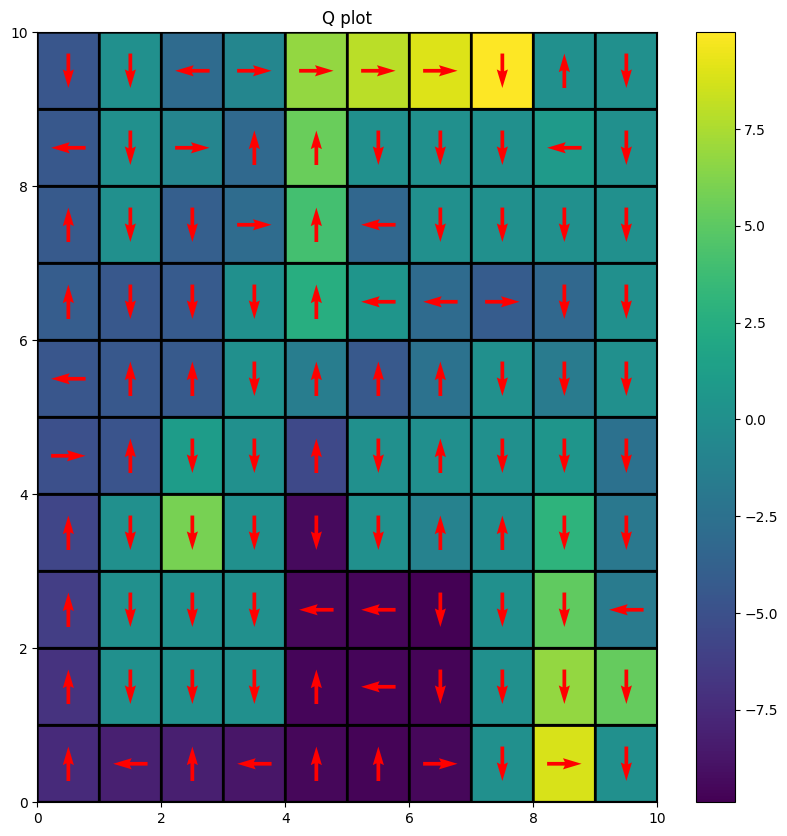

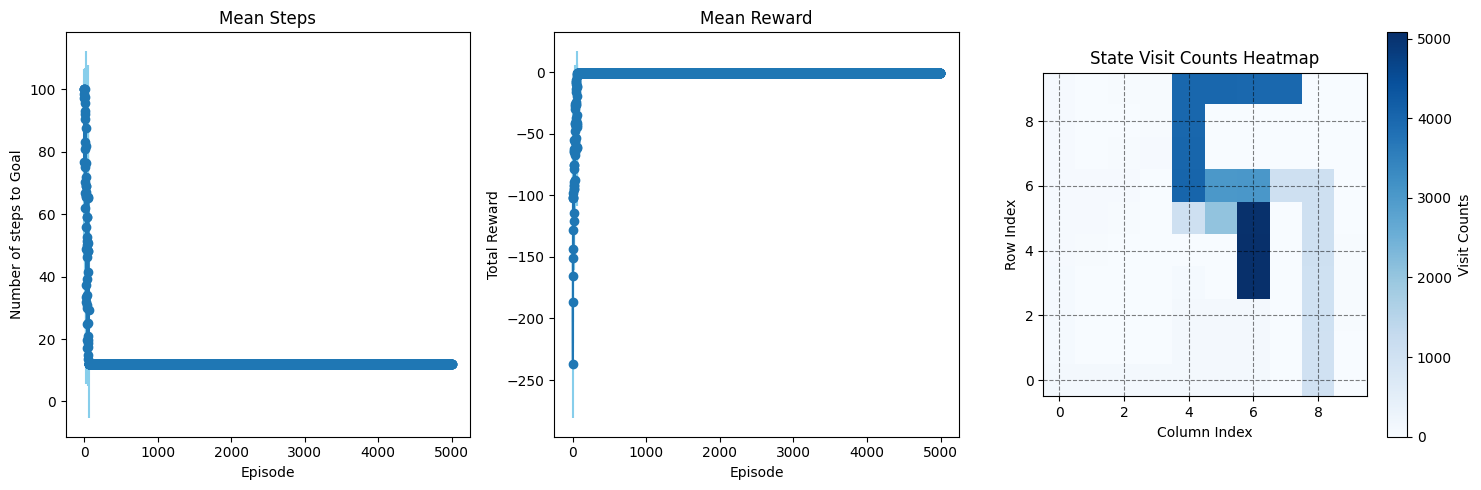

Average reward across all the runs =  -1.7781600000000002
Average steps across all the runs =  12.58348


In [123]:
alpha0= 0.4174701428111145
gamma= 0.9985515272293962
tau= 0.5323033978405733
plot_all(sarsa_s,env2)

Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 687.55it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 698.26it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 784.88it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:06<00:00, 719.85it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:06<00:00, 750.56it/s]


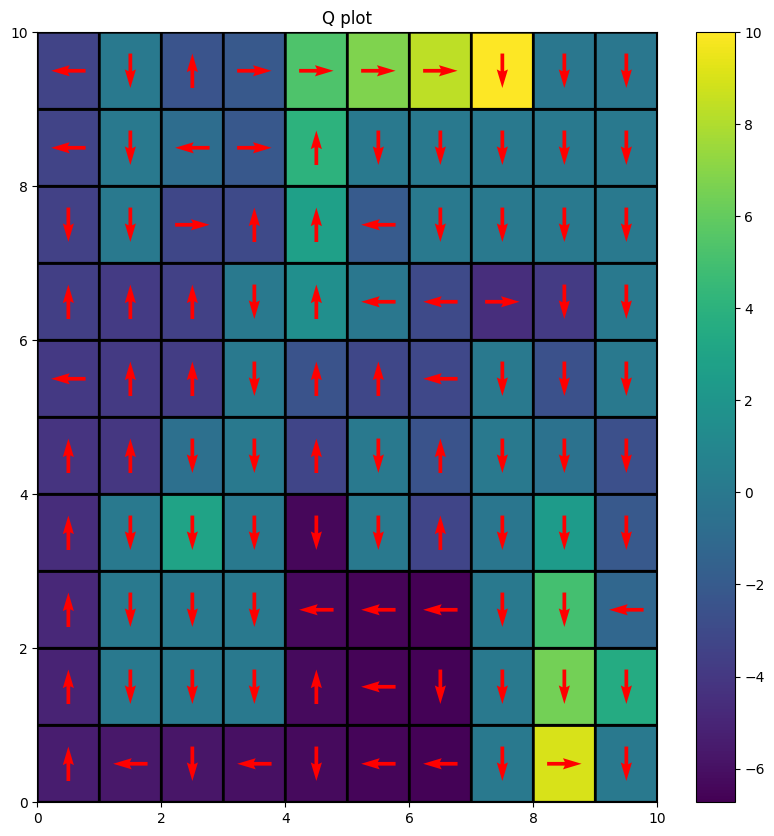

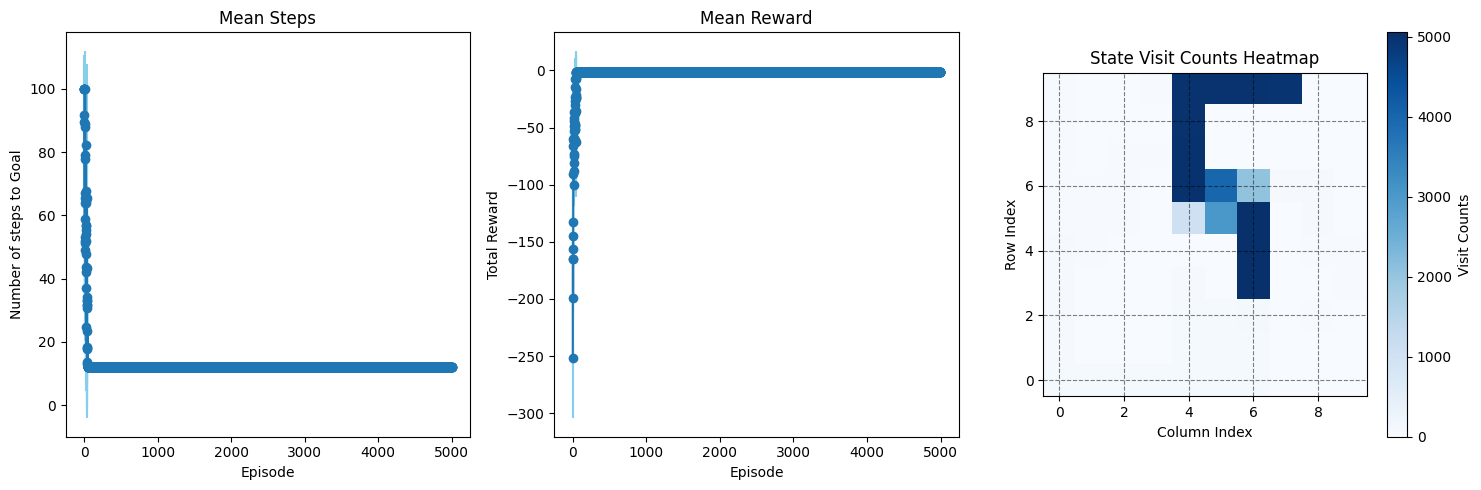

Average reward across all the runs =  -1.59556
Average steps across all the runs =  12.43128


In [124]:
alpha0=0.49481171976814026
gamma= 0.934295881175601
epsilon0= 0.1323501630111592
plot_all(sarsa_e,env2)

Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 789.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 728.22it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 647.11it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 660.10it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:06<00:00, 732.57it/s]


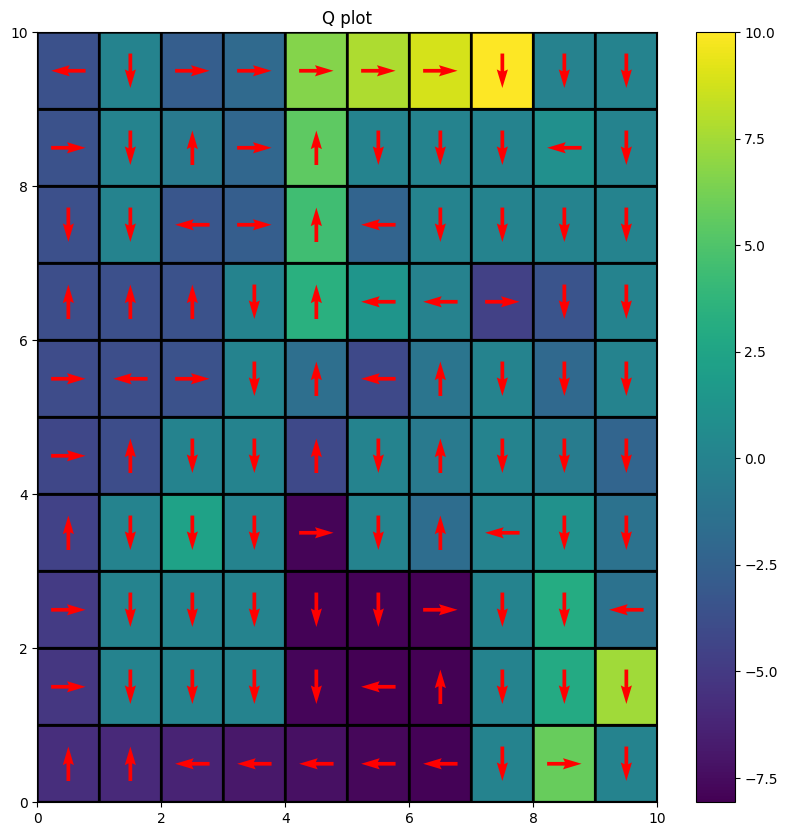

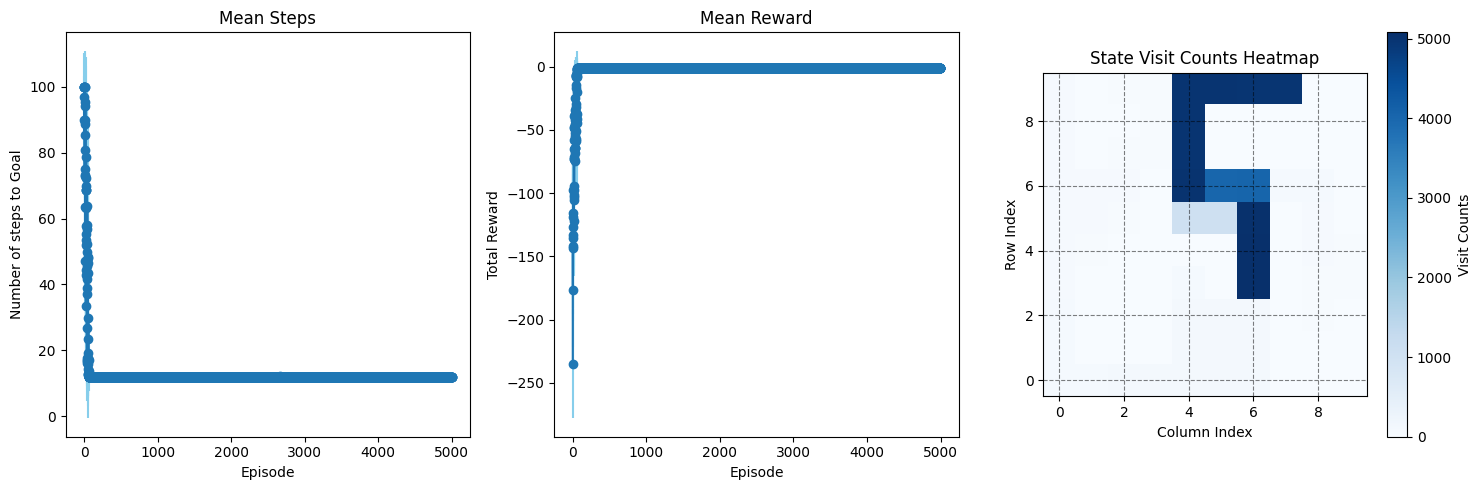

Average reward across all the runs =  -1.73552
Average steps across all the runs =  12.54816


In [125]:
alpha0=0.4637912979494751
gamma= 0.9863977094610662
tau= 0.5029099460650285
plot_all(qlearning_s,env2)

Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 784.23it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 657.70it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 658.49it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:10<00:00, 483.43it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:11<00:00, 433.19it/s]


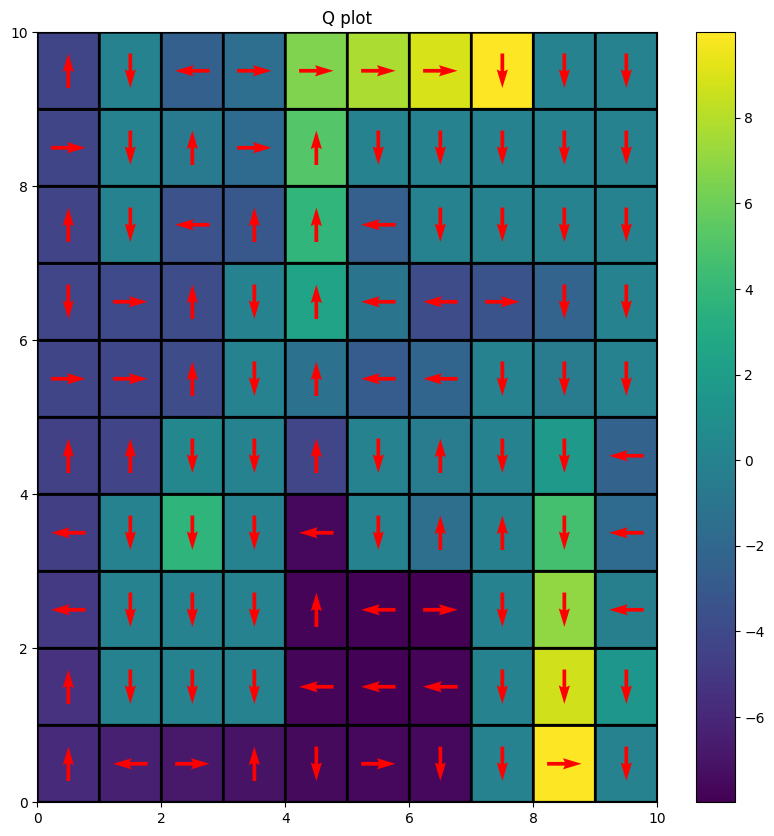

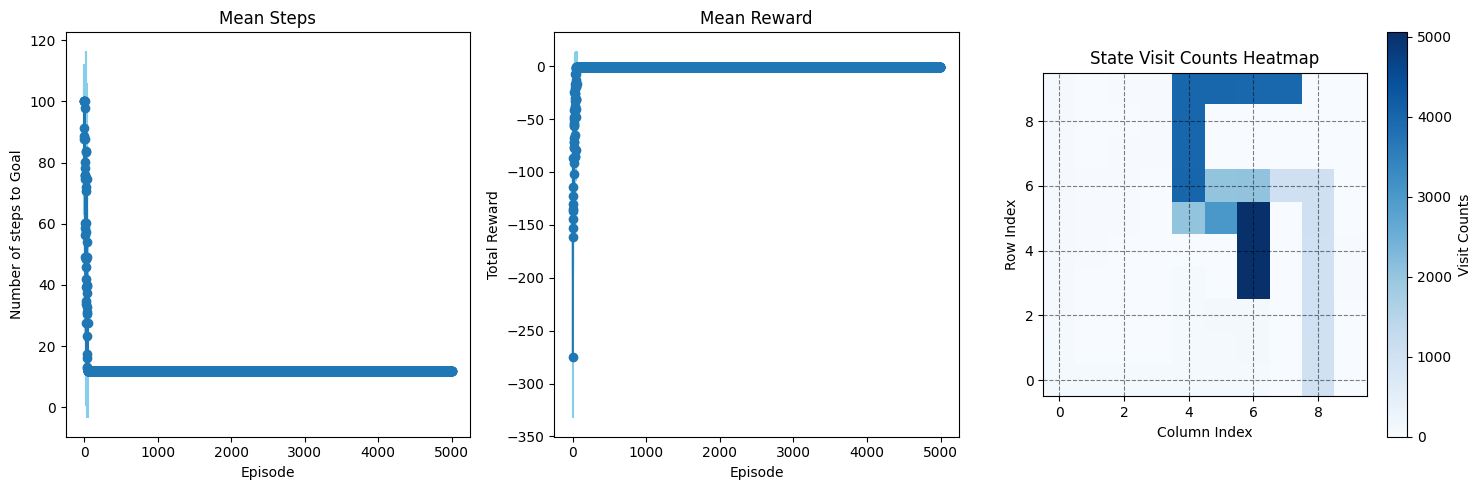

Average reward across all the runs =  -1.6274800000000003
Average steps across all the runs =  12.4596


In [126]:
alpha0= 0.4973930775523683
gamma=  0.9902045351146334
epsilon0= 0.2488316328672338
plot_all(qlearning_e,env2)

In [127]:
# visualizing_env(env6)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env6)
# plot_all(sarsa_e,env6)
# plot_all(qlearning_s,env6)
# plot_all(qlearning_e,env6)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


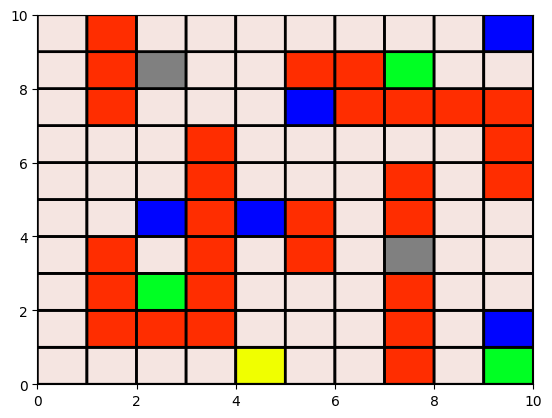

In [128]:
visualizing_env(env3)

In [186]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env3,qlearning_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")



Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:33<00:00, 148.46it/s]


67.4382
Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 309.62it/s]


21.6422
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 333.43it/s]


22.0676
Experiment: 1


100%|██████████| 5000/5000 [00:34<00:00, 143.75it/s]


62.6072
Experiment: 1


100%|██████████| 5000/5000 [00:38<00:00, 130.06it/s]


59.4888
Experiment: 1


100%|██████████| 5000/5000 [00:44<00:00, 111.61it/s]


66.106
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 352.08it/s]


21.1762
Experiment: 1


100%|██████████| 5000/5000 [00:48<00:00, 103.87it/s]


71.2988
Experiment: 1


100%|██████████| 5000/5000 [00:41<00:00, 120.17it/s]


59.939
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 339.47it/s]


21.8492
[{'alpha': 0.2733343550986964, 'gamma': 0.9793065728477717, 'epsilon_tau': 0.28196427862740897, 'mean_rewards': -17.7026, 'mean_steps': 21.1762}, {'alpha': 0.37354691255795136, 'gamma': 0.9991477415454114, 'epsilon_tau': 0.26208744826994657, 'mean_rewards': -18.1658, 'mean_steps': 21.6422}, {'alpha': 0.49259689203638657, 'gamma': 0.9859871988878566, 'epsilon_tau': 0.11558985692187713, 'mean_rewards': -18.3742, 'mean_steps': 21.8492}, {'alpha': 0.37753867747048214, 'gamma': 0.9753431461482535, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -18.7814, 'mean_steps': 22.0676}]
{'alpha': 0.2733343550986964, 'gamma': 0.9793065728477717, 'epsilon_tau': 0.28196427862740897, 'mean_rewards': -17.7026, 'mean_steps': 21.1762}

Best Hyperparameters: {'alpha': 0.2733343550986964, 'gamma': 0.9793065728477717, 'epsilon_tau': 0.28196427862740897}
Best Mean Rewards: -17.7026
Best Mean Steps: 21.1762

Generation 2
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 364.08it/s]


21.3326
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 365.42it/s]


20.9768
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 419.79it/s]


21.1562
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 314.81it/s]


20.6042
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 345.93it/s]


20.651
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 411.56it/s]


21.3408
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 477.33it/s]


20.7006
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 428.07it/s]


23.6306
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 420.86it/s]


23.303
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 425.04it/s]


20.886
[{'alpha': 0.37753867747048214, 'gamma': 0.9753431461482535, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -17.2164, 'mean_steps': 20.6042}, {'alpha': 0.37354691255795136, 'gamma': 0.97997986752414, 'epsilon_tau': 0.28196427862740897, 'mean_rewards': -17.213, 'mean_steps': 20.651}, {'alpha': 0.37354691255795136, 'gamma': 0.9991477415454114, 'epsilon_tau': 0.19954973658756275, 'mean_rewards': -17.2352, 'mean_steps': 20.7006}, {'alpha': 0.2733343550986964, 'gamma': 0.9793065728477717, 'epsilon_tau': 0.14985984180502648, 'mean_rewards': -17.5502, 'mean_steps': 20.886}]
{'alpha': 0.37753867747048214, 'gamma': 0.9753431461482535, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -17.2164, 'mean_steps': 20.6042}

Best Hyperparameters: {'alpha': 0.37753867747048214, 'gamma': 0.9753431461482535, 'epsilon_tau': 0.11690233610096469}
Best Mean Rewards: -17.2164
Best Mean Steps: 20.6042

Generation 3
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 505.03it/s]


20.22
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 401.62it/s]


20.7436
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 504.38it/s]


20.2822
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 494.60it/s]


20.5856
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 423.87it/s]


21.3846
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 333.02it/s]


20.801
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 337.96it/s]


24.381
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 448.92it/s]


22.2124
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 373.57it/s]


21.6164
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 448.15it/s]


20.8336
[{'alpha': 0.37753867747048214, 'gamma': 0.9753431461482535, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -16.737, 'mean_steps': 20.22}, {'alpha': 0.37354691255795136, 'gamma': 0.9991477415454114, 'epsilon_tau': 0.19954973658756275, 'mean_rewards': -16.8048, 'mean_steps': 20.2822}, {'alpha': 0.2733343550986964, 'gamma': 0.9793065728477717, 'epsilon_tau': 0.14985984180502648, 'mean_rewards': -17.2304, 'mean_steps': 20.5856}, {'alpha': 0.37354691255795136, 'gamma': 0.97997986752414, 'epsilon_tau': 0.28196427862740897, 'mean_rewards': -17.2718, 'mean_steps': 20.7436}]
{'alpha': 0.37753867747048214, 'gamma': 0.9753431461482535, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -16.737, 'mean_steps': 20.22}

Best Hyperparameters: {'alpha': 0.37753867747048214, 'gamma': 0.9753431461482535, 'epsilon_tau': 0.11690233610096469}
Best Mean Rewards: -16.737
Best Mean Steps: 20.22

Generation 4
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 439.64it/s]


21.4112
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 402.89it/s]


20.3434
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 440.50it/s]


20.705
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 391.93it/s]


22.1624
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 449.05it/s]


20.3756
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 431.65it/s]


21.4432
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 461.02it/s]


20.47
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 469.08it/s]


20.579
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 478.82it/s]


20.489
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 314.54it/s]


20.5
[{'alpha': 0.37354691255795136, 'gamma': 0.9991477415454114, 'epsilon_tau': 0.19954973658756275, 'mean_rewards': -16.9428, 'mean_steps': 20.3434}, {'alpha': 0.37753867747048214, 'gamma': 0.9753431461482535, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -16.9346, 'mean_steps': 20.3756}, {'alpha': 0.37753867747048214, 'gamma': 0.9577241644188017, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -17.038, 'mean_steps': 20.489}, {'alpha': 0.2733343550986964, 'gamma': 0.9845664842697557, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -17.0538, 'mean_steps': 20.5}]
{'alpha': 0.37354691255795136, 'gamma': 0.9991477415454114, 'epsilon_tau': 0.19954973658756275, 'mean_rewards': -16.9428, 'mean_steps': 20.3434}

Best Hyperparameters: {'alpha': 0.37354691255795136, 'gamma': 0.9991477415454114, 'epsilon_tau': 0.19954973658756275}
Best Mean Rewards: -16.9428
Best Mean Steps: 20.3434

Generation 5
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 286.93it/s]


21.8328
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 325.58it/s]


21.2534
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 422.76it/s]


25.079
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 470.26it/s]


20.5846
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 525.36it/s]


20.6134
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 421.26it/s]


24.1502
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 514.36it/s]


20.276
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 425.16it/s]


20.3812
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 393.20it/s]


20.563
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 520.02it/s]

20.759
[{'alpha': 0.37354691255795136, 'gamma': 0.9845664842697557, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -16.7546, 'mean_steps': 20.276}, {'alpha': 0.37753867747048214, 'gamma': 0.9577241644188017, 'epsilon_tau': 0.10959926591222283, 'mean_rewards': -16.782, 'mean_steps': 20.3812}, {'alpha': 0.2453273432603636, 'gamma': 0.9991477415454114, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -17.0926, 'mean_steps': 20.563}, {'alpha': 0.2733343550986964, 'gamma': 0.9845664842697557, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -17.1806, 'mean_steps': 20.5846}]
{'alpha': 0.37354691255795136, 'gamma': 0.9845664842697557, 'epsilon_tau': 0.11690233610096469, 'mean_rewards': -16.7546, 'mean_steps': 20.276}

Best Hyperparameters: {'alpha': 0.37354691255795136, 'gamma': 0.9845664842697557, 'epsilon_tau': 0.11690233610096469}
Best Mean Rewards: -16.7546
Best Mean Steps: 20.276

Best Hyperparameters: {'alpha': 0.37354691255795136, 'gamma': 0.9845664842697557, 'epsilon_tau': 

In [187]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env3,qlearning_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")



Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:31<00:00, 157.01it/s]


83.5556
Experiment: 1


100%|██████████| 5000/5000 [00:30<00:00, 166.39it/s]


61.2284
Experiment: 1


100%|██████████| 5000/5000 [00:40<00:00, 123.91it/s]


86.9352
Experiment: 1


100%|██████████| 5000/5000 [00:29<00:00, 170.45it/s]


82.4032
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 239.67it/s]


57.8472
Experiment: 1


100%|██████████| 5000/5000 [00:38<00:00, 129.14it/s]


85.4854
Experiment: 1


100%|██████████| 5000/5000 [00:34<00:00, 144.07it/s]


81.7092
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 224.59it/s]


55.2204
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 289.87it/s]


40.8644
Experiment: 1


100%|██████████| 5000/5000 [00:25<00:00, 198.46it/s]


56.7224
[{'alpha': 0.4174669261093975, 'gamma': 0.9254392027703824, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -36.9214, 'mean_steps': 40.8644}, {'alpha': 0.4880009474812045, 'gamma': 0.9439007668258071, 'epsilon_tau': 0.9788894143567959, 'mean_rewards': -52.0276, 'mean_steps': 55.2204}, {'alpha': 0.3453976371729722, 'gamma': 0.9130839674722141, 'epsilon_tau': 0.6429126836562873, 'mean_rewards': -53.0838, 'mean_steps': 56.7224}, {'alpha': 0.37191227707807945, 'gamma': 0.932210790690873, 'epsilon_tau': 0.8675852685277416, 'mean_rewards': -54.466, 'mean_steps': 57.8472}]
{'alpha': 0.4174669261093975, 'gamma': 0.9254392027703824, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -36.9214, 'mean_steps': 40.8644}

Best Hyperparameters: {'alpha': 0.4174669261093975, 'gamma': 0.9254392027703824, 'epsilon_tau': 0.5187596717828884}
Best Mean Rewards: -36.9214
Best Mean Steps: 40.8644

Generation 2
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 278.08it/s]


39.9654
Experiment: 1


100%|██████████| 5000/5000 [00:24<00:00, 205.21it/s]


53.9178
Experiment: 1


100%|██████████| 5000/5000 [00:28<00:00, 176.90it/s]


58.9992
Experiment: 1


100%|██████████| 5000/5000 [00:24<00:00, 204.97it/s]


57.0528
Experiment: 1


100%|██████████| 5000/5000 [00:27<00:00, 182.88it/s]


66.8158
Experiment: 1


100%|██████████| 5000/5000 [00:25<00:00, 198.73it/s]


58.9658
Experiment: 1


100%|██████████| 5000/5000 [00:40<00:00, 123.50it/s]


68.4188
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 447.28it/s]


24.5592
Experiment: 1


100%|██████████| 5000/5000 [00:23<00:00, 216.19it/s]


52.533
Experiment: 1


100%|██████████| 5000/5000 [00:28<00:00, 177.11it/s]


70.716
[{'alpha': 0.37191227707807945, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5882800875270796, 'mean_rewards': -21.0168, 'mean_steps': 24.5592}, {'alpha': 0.4174669261093975, 'gamma': 0.9254392027703824, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -36.1778, 'mean_steps': 39.9654}, {'alpha': 0.4880009474812045, 'gamma': 0.9439007668258071, 'epsilon_tau': 0.8675852685277416, 'mean_rewards': -48.9094, 'mean_steps': 52.533}, {'alpha': 0.4880009474812045, 'gamma': 0.9439007668258071, 'epsilon_tau': 0.9788894143567959, 'mean_rewards': -50.4302, 'mean_steps': 53.9178}]
{'alpha': 0.37191227707807945, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5882800875270796, 'mean_rewards': -21.0168, 'mean_steps': 24.5592}

Best Hyperparameters: {'alpha': 0.37191227707807945, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5882800875270796}
Best Mean Rewards: -21.0168
Best Mean Steps: 24.5592

Generation 3
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 461.59it/s]


23.7386
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 288.03it/s]


36.578
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 250.08it/s]


49.364
Experiment: 1


100%|██████████| 5000/5000 [00:26<00:00, 186.45it/s]


59.8708
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 520.60it/s]


21.1736
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 502.71it/s]


22.7754
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 373.16it/s]


29.9594
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 224.27it/s]


44.8988
Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 305.69it/s]


38.2044
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 253.71it/s]


44.2892
[{'alpha': 0.4174669261093975, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -17.7462, 'mean_steps': 21.1736}, {'alpha': 0.4174669261093975, 'gamma': 0.9645624971213448, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -19.3172, 'mean_steps': 22.7754}, {'alpha': 0.37191227707807945, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5882800875270796, 'mean_rewards': -20.273, 'mean_steps': 23.7386}, {'alpha': 0.3373844154869432, 'gamma': 0.9527551135415733, 'epsilon_tau': 0.5755579100714131, 'mean_rewards': -26.4502, 'mean_steps': 29.9594}]
{'alpha': 0.4174669261093975, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -17.7462, 'mean_steps': 21.1736}

Best Hyperparameters: {'alpha': 0.4174669261093975, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884}
Best Mean Rewards: -17.7462
Best Mean Steps: 21.1736

Generation 4
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 461.86it/s]


23.9594
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 464.83it/s]


24.448
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 468.72it/s]


22.7124
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 346.17it/s]


30.3756
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 504.98it/s]


22.2956
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 498.13it/s]


22.9896
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 272.09it/s]


33.6898
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 450.96it/s]


23.766
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 507.65it/s]


22.5954
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 520.51it/s]


21.373
[{'alpha': 0.4174669261093975, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5252480252061089, 'mean_rewards': -17.9374, 'mean_steps': 21.373}, {'alpha': 0.34516659816601203, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -18.9506, 'mean_steps': 22.2956}, {'alpha': 0.4174669261093975, 'gamma': 0.9645624971213448, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -19.2666, 'mean_steps': 22.5954}, {'alpha': 0.37191227707807945, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5882800875270796, 'mean_rewards': -19.3376, 'mean_steps': 22.7124}]
{'alpha': 0.4174669261093975, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5252480252061089, 'mean_rewards': -17.9374, 'mean_steps': 21.373}

Best Hyperparameters: {'alpha': 0.4174669261093975, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5252480252061089}
Best Mean Rewards: -17.9374
Best Mean Steps: 21.373

Generation 5
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 505.94it/s]


21.9906
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 496.74it/s]


21.8582
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 326.59it/s]


24.5672
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 346.39it/s]


23.0694
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 285.80it/s]


28.6382
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 318.06it/s]


23.838
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 371.79it/s]


22.4514
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 452.67it/s]


22.5806
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 530.04it/s]


21.1774
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 532.03it/s]

21.0386
[{'alpha': 0.34516659816601203, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -17.585, 'mean_steps': 21.0386}, {'alpha': 0.34516659816601203, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -17.7506, 'mean_steps': 21.1774}, {'alpha': 0.34516659816601203, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -18.568, 'mean_steps': 21.8582}, {'alpha': 0.4174669261093975, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5252480252061089, 'mean_rewards': -18.5618, 'mean_steps': 21.9906}]
{'alpha': 0.34516659816601203, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884, 'mean_rewards': -17.585, 'mean_steps': 21.0386}

Best Hyperparameters: {'alpha': 0.34516659816601203, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5187596717828884}
Best Mean Rewards: -17.585
Best Mean Steps: 21.0386

Best Hyperparameters: {'alpha': 0.34516659816601203, 'gamma': 0.9768633742136507, 'epsilon_tau': 0.5

In [188]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env3,sarsa_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")



Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:41<00:00, 121.74it/s]


91.8578
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 387.37it/s]


22.2836
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 262.40it/s]


39.5196
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 402.52it/s]


27.318
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 406.21it/s]


26.93
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 362.72it/s]


23.2374
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 405.20it/s]


24.1324
Experiment: 1


100%|██████████| 5000/5000 [00:44<00:00, 113.06it/s]


92.5738
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 220.36it/s]


47.054
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 539.62it/s]


20.8648
[{'alpha': 0.3710819987219522, 'gamma': 0.9799146684042701, 'epsilon_tau': 0.6790988147556384, 'mean_rewards': -17.5938, 'mean_steps': 20.8648}, {'alpha': 0.20312926333338116, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -19.0712, 'mean_steps': 22.2836}, {'alpha': 0.3059794475646882, 'gamma': 0.9516628659676821, 'epsilon_tau': 0.5928782365538496, 'mean_rewards': -19.8454, 'mean_steps': 23.2374}, {'alpha': 0.2921872709161253, 'gamma': 0.9894958784747447, 'epsilon_tau': 0.9449582212612422, 'mean_rewards': -20.8712, 'mean_steps': 24.1324}]
{'alpha': 0.3710819987219522, 'gamma': 0.9799146684042701, 'epsilon_tau': 0.6790988147556384, 'mean_rewards': -17.5938, 'mean_steps': 20.8648}

Best Hyperparameters: {'alpha': 0.3710819987219522, 'gamma': 0.9799146684042701, 'epsilon_tau': 0.6790988147556384}
Best Mean Rewards: -17.5938
Best Mean Steps: 20.8648

Generation 2
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 474.35it/s]


22.2218
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 497.30it/s]


21.9622
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 462.75it/s]


23.883
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 451.70it/s]


23.7172
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 473.09it/s]


23.604
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 453.50it/s]


22.9276
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 430.14it/s]


21.9298
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.42it/s]


23.682
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 450.41it/s]


23.143
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 522.96it/s]


21.3328
[{'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.9872, 'mean_steps': 21.3328}, {'alpha': 0.3710819987219522, 'gamma': 0.9894958784747447, 'epsilon_tau': 0.9449582212612422, 'mean_rewards': -18.6198, 'mean_steps': 21.9298}, {'alpha': 0.20312926333338116, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -18.684, 'mean_steps': 21.9622}, {'alpha': 0.3710819987219522, 'gamma': 0.9799146684042701, 'epsilon_tau': 0.6790988147556384, 'mean_rewards': -18.8938, 'mean_steps': 22.2218}]
{'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.9872, 'mean_steps': 21.3328}

Best Hyperparameters: {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494}
Best Mean Rewards: -17.9872
Best Mean Steps: 21.3328

Generation 3
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 539.75it/s]


20.9508
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 390.09it/s]


22.5912
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 462.22it/s]


21.9976
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 507.06it/s]


21.7294
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 535.59it/s]


20.9362
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 527.36it/s]


21.2632
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 529.37it/s]


21.3742
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 470.54it/s]


23.3634
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 522.55it/s]


20.608
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 498.18it/s]


21.8866
[{'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.288, 'mean_steps': 20.608}, {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.5798, 'mean_steps': 20.9508}, {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.6096, 'mean_steps': 20.9362}, {'alpha': 0.3710819987219522, 'gamma': 0.9799146684042701, 'epsilon_tau': 0.6790988147556384, 'mean_rewards': -17.9176, 'mean_steps': 21.2632}]
{'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.288, 'mean_steps': 20.608}

Best Hyperparameters: {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494}
Best Mean Rewards: -17.288
Best Mean Steps: 20.608

Generation 4
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 519.50it/s]


21.2502
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 502.77it/s]


21.1718
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 518.62it/s]


21.1064
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 527.84it/s]


21.1688
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 463.46it/s]


24.1624
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 498.57it/s]


20.9944
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 502.36it/s]


21.2686
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 495.95it/s]


21.4798
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 393.13it/s]


21.1374
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 498.57it/s]


21.1632
[{'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.6528, 'mean_steps': 20.9944}, {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.763, 'mean_steps': 21.1064}, {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.8042, 'mean_steps': 21.1374}, {'alpha': 0.3710819987219522, 'gamma': 0.9799146684042701, 'epsilon_tau': 0.6790988147556384, 'mean_rewards': -17.7964, 'mean_steps': 21.1688}]
{'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.6528, 'mean_steps': 20.9944}

Best Hyperparameters: {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494}
Best Mean Rewards: -17.6528
Best Mean Steps: 20.9944

Generation 5
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 445.06it/s]


21.2264
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.53it/s]


20.9482
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 370.18it/s]


20.8412
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 407.71it/s]


20.9226
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 342.14it/s]


21.762
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 395.78it/s]


21.2026
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 387.87it/s]


21.7864
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 383.35it/s]


21.5344
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 387.51it/s]


21.532
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 376.68it/s]

22.3772
[{'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.454, 'mean_steps': 20.8412}, {'alpha': 0.3710819987219522, 'gamma': 0.9799146684042701, 'epsilon_tau': 0.6790988147556384, 'mean_rewards': -17.4938, 'mean_steps': 20.9226}, {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.5734, 'mean_steps': 20.9482}, {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.5689742565235931, 'mean_rewards': -17.933, 'mean_steps': 21.2026}]
{'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494, 'mean_rewards': -17.454, 'mean_steps': 20.8412}

Best Hyperparameters: {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623708420494}
Best Mean Rewards: -17.454
Best Mean Steps: 20.8412

Best Hyperparameters: {'alpha': 0.3059794475646882, 'gamma': 0.9981959018141768, 'epsilon_tau': 0.6783623

In [189]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env3,sarsa_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:38<00:00, 130.97it/s]


80.2466
Experiment: 1


100%|██████████| 5000/5000 [00:39<00:00, 127.29it/s]


83.6894
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 573.07it/s]


20.143
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 434.45it/s]


24.338
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 479.58it/s]


20.8844
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 511.74it/s]


21.4228
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 225.00it/s]


40.6502
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 343.66it/s]


22.4976
Experiment: 1


100%|██████████| 5000/5000 [00:57<00:00, 86.54it/s] 


87.2204
Experiment: 1


100%|██████████| 5000/5000 [00:38<00:00, 129.00it/s]


86.4722
[{'alpha': 0.44021429956827507, 'gamma': 0.995480923165589, 'epsilon_tau': 0.2502836324810845, 'mean_rewards': -16.752, 'mean_steps': 20.143}, {'alpha': 0.20980571257860112, 'gamma': 0.9845861772408995, 'epsilon_tau': 0.12033478231247878, 'mean_rewards': -17.515, 'mean_steps': 20.8844}, {'alpha': 0.20083103839986705, 'gamma': 0.9234683261525372, 'epsilon_tau': 0.0870432900770929, 'mean_rewards': -17.9786, 'mean_steps': 21.4228}, {'alpha': 0.39295126077037756, 'gamma': 0.9782967221434098, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -19.0992, 'mean_steps': 22.4976}]
{'alpha': 0.44021429956827507, 'gamma': 0.995480923165589, 'epsilon_tau': 0.2502836324810845, 'mean_rewards': -16.752, 'mean_steps': 20.143}

Best Hyperparameters: {'alpha': 0.44021429956827507, 'gamma': 0.995480923165589, 'epsilon_tau': 0.2502836324810845}
Best Mean Rewards: -16.752
Best Mean Steps: 20.143

Generation 2
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 504.28it/s]


22.0644
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 513.17it/s]


20.9426
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 529.20it/s]


20.9934
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 487.66it/s]


20.341
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 537.29it/s]


20.3798
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 465.07it/s]


20.8262
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 386.51it/s]


20.7428
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 438.22it/s]


20.5658
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 636.54it/s]


21.0084
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 333.85it/s]


31.7694
[{'alpha': 0.39295126077037756, 'gamma': 0.9782967221434098, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -16.8996, 'mean_steps': 20.341}, {'alpha': 0.44021429956827507, 'gamma': 0.9580669502394479, 'epsilon_tau': 0.2502836324810845, 'mean_rewards': -16.8736, 'mean_steps': 20.3798}, {'alpha': 0.3529465532319913, 'gamma': 0.991407821090669, 'epsilon_tau': 0.2502836324810845, 'mean_rewards': -17.1008, 'mean_steps': 20.5658}, {'alpha': 0.2983617350530174, 'gamma': 0.9234683261525372, 'epsilon_tau': 0.10177441862398089, 'mean_rewards': -17.2336, 'mean_steps': 20.7428}]
{'alpha': 0.39295126077037756, 'gamma': 0.9782967221434098, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -16.8996, 'mean_steps': 20.341}

Best Hyperparameters: {'alpha': 0.39295126077037756, 'gamma': 0.9782967221434098, 'epsilon_tau': 0.0959903816946573}
Best Mean Rewards: -16.8996
Best Mean Steps: 20.341

Generation 3
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 483.32it/s]


21.8878
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 401.06it/s]


22.4464
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 446.06it/s]


22.099
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 459.97it/s]


22.851
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 545.89it/s]


20.9392
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 429.26it/s]


25.1394
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 556.96it/s]


22.4618
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 616.89it/s]


20.4002
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 522.90it/s]


22.188
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 533.79it/s]


20.4774
[{'alpha': 0.30329976904717926, 'gamma': 0.9580669502394479, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -16.9488, 'mean_steps': 20.4002}, {'alpha': 0.3529465532319913, 'gamma': 0.991407821090669, 'epsilon_tau': 0.2502836324810845, 'mean_rewards': -16.9742, 'mean_steps': 20.4774}, {'alpha': 0.2262546123826216, 'gamma': 0.9580669502394479, 'epsilon_tau': 0.2502836324810845, 'mean_rewards': -17.4738, 'mean_steps': 20.9392}, {'alpha': 0.39295126077037756, 'gamma': 0.9782967221434098, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -18.3744, 'mean_steps': 21.8878}]
{'alpha': 0.30329976904717926, 'gamma': 0.9580669502394479, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -16.9488, 'mean_steps': 20.4002}

Best Hyperparameters: {'alpha': 0.30329976904717926, 'gamma': 0.9580669502394479, 'epsilon_tau': 0.0959903816946573}
Best Mean Rewards: -16.9488
Best Mean Steps: 20.4002

Generation 4
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 460.91it/s]


22.587
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 425.09it/s]


20.6544
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 455.73it/s]


20.916
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 530.77it/s]


20.9184
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 442.80it/s]


21.934
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 401.35it/s]


21.0482
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 397.39it/s]


21.3634
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 388.31it/s]


20.9606
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 412.50it/s]


21.0214
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 411.95it/s]


20.5744
[{'alpha': 0.39295126077037756, 'gamma': 0.9744325650804949, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -17.1172, 'mean_steps': 20.5744}, {'alpha': 0.3529465532319913, 'gamma': 0.991407821090669, 'epsilon_tau': 0.2502836324810845, 'mean_rewards': -17.2826, 'mean_steps': 20.6544}, {'alpha': 0.39295126077037756, 'gamma': 0.9782967221434098, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -17.4732, 'mean_steps': 20.9184}, {'alpha': 0.2262546123826216, 'gamma': 0.9580669502394479, 'epsilon_tau': 0.2502836324810845, 'mean_rewards': -17.5718, 'mean_steps': 20.916}]
{'alpha': 0.39295126077037756, 'gamma': 0.9744325650804949, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -17.1172, 'mean_steps': 20.5744}

Best Hyperparameters: {'alpha': 0.39295126077037756, 'gamma': 0.9744325650804949, 'epsilon_tau': 0.0959903816946573}
Best Mean Rewards: -17.1172
Best Mean Steps: 20.5744

Generation 5
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 369.63it/s]


20.6174
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 390.20it/s]


20.7252
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 476.39it/s]


21.015
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 399.10it/s]


21.131
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 514.45it/s]


23.6596
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 591.01it/s]


21.4012
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 627.49it/s]


20.2316
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 617.52it/s]


20.3204
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 609.54it/s]


20.6112
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 568.65it/s]

21.268
[{'alpha': 0.39295126077037756, 'gamma': 0.991407821090669, 'epsilon_tau': 0.15378531000487097, 'mean_rewards': -16.7468, 'mean_steps': 20.2316}, {'alpha': 0.3529465532319913, 'gamma': 0.991407821090669, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -16.835, 'mean_steps': 20.3204}, {'alpha': 0.39295126077037756, 'gamma': 0.9744325650804949, 'epsilon_tau': 0.0959903816946573, 'mean_rewards': -17.1112, 'mean_steps': 20.6174}, {'alpha': 0.2262546123826216, 'gamma': 0.9807845560865218, 'epsilon_tau': 0.13483297932992622, 'mean_rewards': -17.2316, 'mean_steps': 20.6112}]
{'alpha': 0.39295126077037756, 'gamma': 0.991407821090669, 'epsilon_tau': 0.15378531000487097, 'mean_rewards': -16.7468, 'mean_steps': 20.2316}

Best Hyperparameters: {'alpha': 0.39295126077037756, 'gamma': 0.991407821090669, 'epsilon_tau': 0.15378531000487097}
Best Mean Rewards: -16.7468
Best Mean Steps: 20.2316

Best Hyperparameters: {'alpha': 0.39295126077037756, 'gamma': 0.991407821090669, 'epsilon_tau': 0.1

Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 547.11it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 538.82it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 567.16it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:12<00:00, 415.45it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:09<00:00, 510.36it/s]


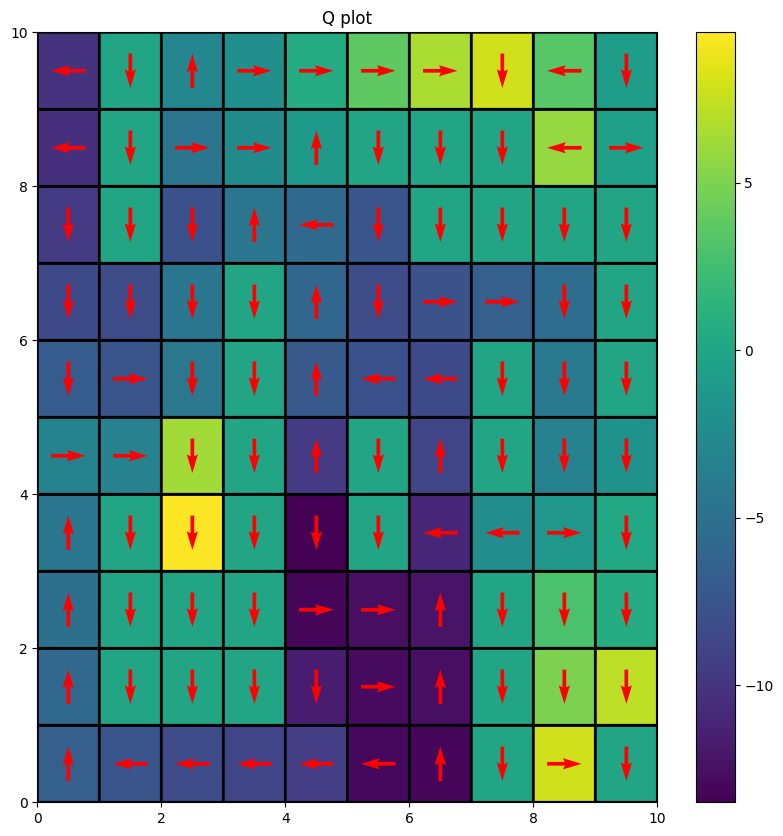

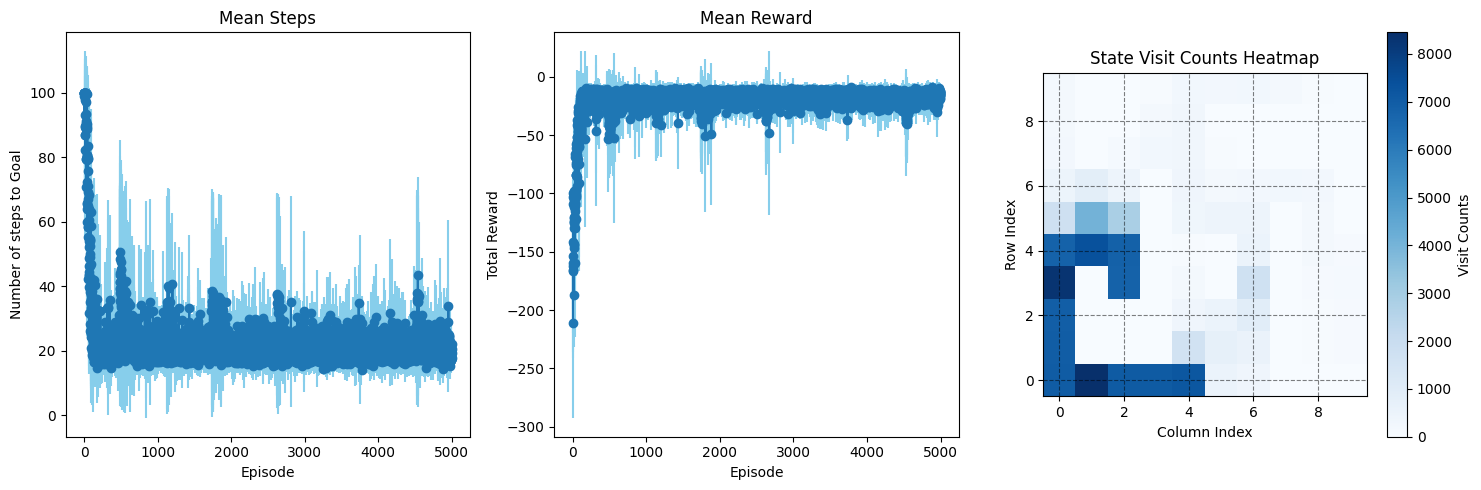

Average reward across all the runs =  -18.61824
Average steps across all the runs =  22.21432


In [194]:
alpha0=0.39295126077037756
gamma=0.941407821090669
epsilon0=0.15378531000487097
plot_all(sarsa_e,env3)

In [190]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env4,qlearning_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")



Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 435.02it/s]


25.7456
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 498.19it/s]


26.3982
Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 312.35it/s]


39.2902
Experiment: 1


100%|██████████| 5000/5000 [00:27<00:00, 184.12it/s]


63.67
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 424.47it/s]


30.8096
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 475.22it/s]


27.2662
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 371.50it/s]


34.9424
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 399.72it/s]


30.7434
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 408.68it/s]


27.2856
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 460.19it/s]


27.2986
[{'alpha': 0.39821729426747976, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.612, 'mean_steps': 25.7456}, {'alpha': 0.2581906963281141, 'gamma': 0.8977947941901209, 'epsilon_tau': 0.06374713331098629, 'mean_rewards': -20.5672, 'mean_steps': 26.3982}, {'alpha': 0.36475004995724025, 'gamma': 0.9451942800403371, 'epsilon_tau': 0.19453650241810821, 'mean_rewards': -20.9024, 'mean_steps': 27.2662}, {'alpha': 0.2040783416184236, 'gamma': 0.9522041037119837, 'epsilon_tau': 0.19680964073954416, 'mean_rewards': -21.3896, 'mean_steps': 27.2856}]
{'alpha': 0.39821729426747976, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.612, 'mean_steps': 25.7456}

Best Hyperparameters: {'alpha': 0.39821729426747976, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.1450219034655273}
Best Mean Rewards: -20.612
Best Mean Steps: 25.7456

Generation 2
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 492.41it/s]


27.376
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 492.48it/s]


27.3756
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 501.21it/s]


26.1908
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 513.80it/s]


26.548
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 496.27it/s]


27.3954
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 412.17it/s]


33.8194
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 509.19it/s]


26.3864
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 480.52it/s]


27.0548
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 511.46it/s]


26.8292
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 504.42it/s]


27.1748
[{'alpha': 0.36475004995724025, 'gamma': 0.9451942800403371, 'epsilon_tau': 0.19453650241810821, 'mean_rewards': -20.9666, 'mean_steps': 26.1908}, {'alpha': 0.2040783416184236, 'gamma': 0.9522041037119837, 'epsilon_tau': 0.19680964073954416, 'mean_rewards': -21.0196, 'mean_steps': 26.548}, {'alpha': 0.2040783416184236, 'gamma': 0.9780648686864066, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -21.2758, 'mean_steps': 26.3864}, {'alpha': 0.39821729426747976, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.9664, 'mean_steps': 26.8292}]
{'alpha': 0.36475004995724025, 'gamma': 0.9451942800403371, 'epsilon_tau': 0.19453650241810821, 'mean_rewards': -20.9666, 'mean_steps': 26.1908}

Best Hyperparameters: {'alpha': 0.36475004995724025, 'gamma': 0.9451942800403371, 'epsilon_tau': 0.19453650241810821}
Best Mean Rewards: -20.9666
Best Mean Steps: 26.1908

Generation 3
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 477.62it/s]


27.6098
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 477.42it/s]


28.9516
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 492.13it/s]


26.3516
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 488.90it/s]


27.122
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 494.16it/s]


26.688
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 519.84it/s]


25.9844
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 418.55it/s]


26.6456
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 432.14it/s]


26.8796
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 412.81it/s]


27.7614
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 390.14it/s]


28.569
[{'alpha': 0.2386391748259611, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -21.05, 'mean_steps': 25.9844}, {'alpha': 0.3581452986003303, 'gamma': 0.9977539614124913, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.4426, 'mean_steps': 26.688}, {'alpha': 0.2040783416184236, 'gamma': 0.9780648686864066, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.8276, 'mean_steps': 26.3516}, {'alpha': 0.3860325299387223, 'gamma': 0.9780648686864066, 'epsilon_tau': 0.19680964073954416, 'mean_rewards': -21.2314, 'mean_steps': 26.6456}]
{'alpha': 0.2386391748259611, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -21.05, 'mean_steps': 25.9844}

Best Hyperparameters: {'alpha': 0.2386391748259611, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.1450219034655273}
Best Mean Rewards: -21.05
Best Mean Steps: 25.9844

Generation 4
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 484.37it/s]


26.2648
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 443.30it/s]


26.694
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 468.30it/s]


27.1182
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 453.03it/s]


27.66
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 467.20it/s]


26.2692
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 406.83it/s]


25.3268
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 382.86it/s]


26.7922
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 327.21it/s]


27.4348
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 339.48it/s]


26.078
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 285.79it/s]


26.5792
[{'alpha': 0.2963742088859813, 'gamma': 0.9977539614124913, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.4692, 'mean_steps': 25.3268}, {'alpha': 0.3581452986003303, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.10052553640892303, 'mean_rewards': -20.2224, 'mean_steps': 26.5792}, {'alpha': 0.2719059163873838, 'gamma': 0.9780648686864066, 'epsilon_tau': 0.20480928645969815, 'mean_rewards': -20.785, 'mean_steps': 26.2692}, {'alpha': 0.3581452986003303, 'gamma': 0.9977539614124913, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.5948, 'mean_steps': 26.694}]
{'alpha': 0.2963742088859813, 'gamma': 0.9977539614124913, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.4692, 'mean_steps': 25.3268}

Best Hyperparameters: {'alpha': 0.2963742088859813, 'gamma': 0.9977539614124913, 'epsilon_tau': 0.1450219034655273}
Best Mean Rewards: -20.4692
Best Mean Steps: 25.3268

Generation 5
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 279.41it/s]


26.8216
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 249.00it/s]


26.448
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 286.53it/s]


27.2906
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 268.25it/s]


26.6588
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 292.98it/s]


26.3012
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 281.87it/s]


25.7046
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 271.38it/s]


26.874
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 269.97it/s]


26.357
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 396.81it/s]


25.6514
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 243.85it/s]

26.334
[{'alpha': 0.33206320325380767, 'gamma': 0.9827961681786012, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.6282, 'mean_steps': 25.6514}, {'alpha': 0.3382189040942497, 'gamma': 0.9977539614124913, 'epsilon_tau': 0.17018750475737682, 'mean_rewards': -20.6598, 'mean_steps': 25.7046}, {'alpha': 0.3581452986003303, 'gamma': 0.9720640443166711, 'epsilon_tau': 0.10052553640892303, 'mean_rewards': -20.6872, 'mean_steps': 26.448}, {'alpha': 0.3581452986003303, 'gamma': 0.9977539614124913, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.8816, 'mean_steps': 26.357}]
{'alpha': 0.33206320325380767, 'gamma': 0.9827961681786012, 'epsilon_tau': 0.1450219034655273, 'mean_rewards': -20.6282, 'mean_steps': 25.6514}

Best Hyperparameters: {'alpha': 0.33206320325380767, 'gamma': 0.9827961681786012, 'epsilon_tau': 0.1450219034655273}
Best Mean Rewards: -20.6282
Best Mean Steps: 25.6514

Best Hyperparameters: {'alpha': 0.33206320325380767, 'gamma': 0.9827961681786012, 'epsilon_tau': 0.

Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 393.82it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 430.77it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 411.74it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:11<00:00, 430.61it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:12<00:00, 403.66it/s]


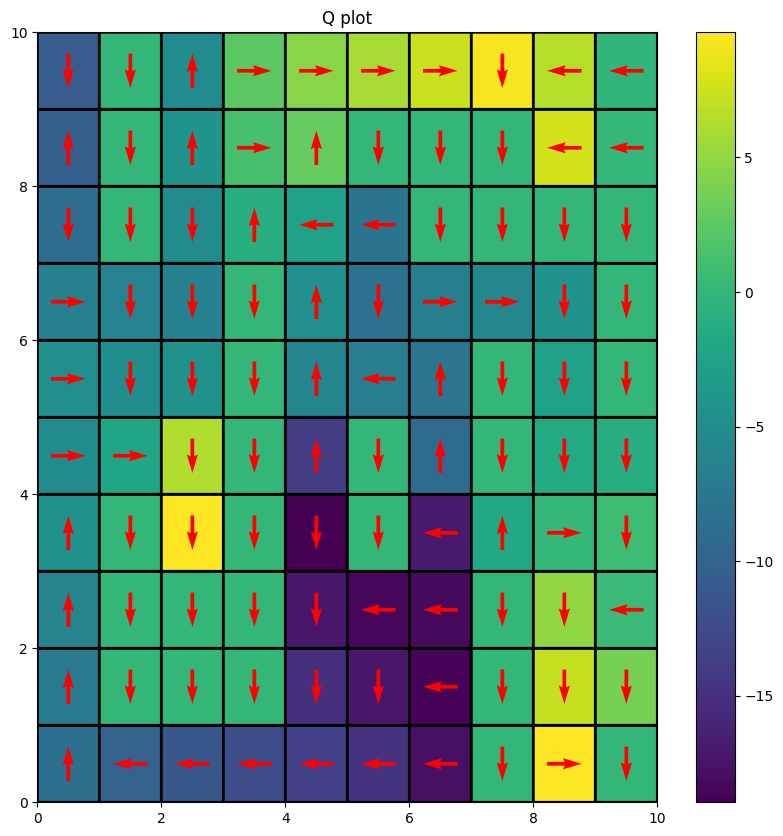

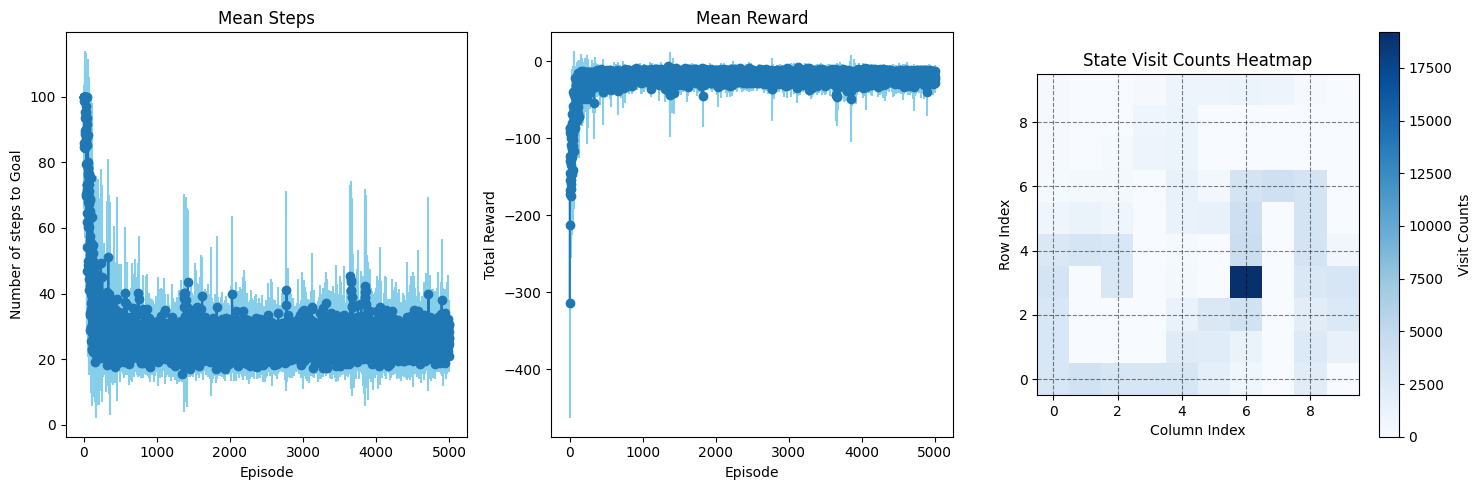

Average reward across all the runs =  -20.82912
Average steps across all the runs =  26.63056


In [197]:
alpha0=0.33206320325380767
gamma=0.9827961681786012
epsilon0=0.1450219034655273
plot_all(qlearning_e,env4)

In [191]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env4,qlearning_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")



Generation 1
Experiment: 1


 13%|█▎        | 635/5000 [00:03<00:20, 211.24it/s]


KeyboardInterrupt: 

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env4,sarsa_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


[{'alpha': 0.44399160812416605, 'gamma': 0.950023926379505, 'epsilon_tau': 0.8790772989649112}, {'alpha': 0.406534655161101, 'gamma': 0.9799329490276092, 'epsilon_tau': 0.9714229128174888}, {'alpha': 0.32977464231129955, 'gamma': 0.8675529220714175, 'epsilon_tau': 0.832161844573235}, {'alpha': 0.23153054355015545, 'gamma': 0.9474022234092847, 'epsilon_tau': 0.6161604912545264}, {'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669}, {'alpha': 0.4720493155769181, 'gamma': 0.819889539546172, 'epsilon_tau': 0.5616811009869238}, {'alpha': 0.23348023949672464, 'gamma': 0.9202284269488403, 'epsilon_tau': 0.7208013461919132}, {'alpha': 0.31330030410601833, 'gamma': 0.8896432832896919, 'epsilon_tau': 0.5688706101801932}, {'alpha': 0.41024356190027, 'gamma': 0.922527891929852, 'epsilon_tau': 0.6931504026189985}, {'alpha': 0.3049604448293037, 'gamma': 0.8735312094984578, 'epsilon_tau': 0.5489205336444754}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 702.88it/s]


13.3986
-2.5948 13.3986
{'alpha': 0.44399160812416605, 'gamma': 0.950023926379505, 'epsilon_tau': 0.8790772989649112, 'mean_rewards': -2.5948} -2.5948
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 742.88it/s]


13.5946
-2.8132 13.5946
{'alpha': 0.406534655161101, 'gamma': 0.9799329490276092, 'epsilon_tau': 0.9714229128174888, 'mean_rewards': -2.8132} -2.8132
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 545.68it/s]


18.2184
-7.5608 18.2184
{'alpha': 0.32977464231129955, 'gamma': 0.8675529220714175, 'epsilon_tau': 0.832161844573235, 'mean_rewards': -7.5608} -7.5608
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 736.92it/s]


13.1208
-2.3824 13.1208
{'alpha': 0.23153054355015545, 'gamma': 0.9474022234092847, 'epsilon_tau': 0.6161604912545264, 'mean_rewards': -2.3824} -2.3824
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 730.93it/s]


12.8352
-2.0668 12.8352
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0668} -2.0668
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 521.17it/s]


18.7238
-8.0314 18.7238
{'alpha': 0.4720493155769181, 'gamma': 0.819889539546172, 'epsilon_tau': 0.5616811009869238, 'mean_rewards': -8.0314} -8.0314
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 697.55it/s]


14.3604
-3.6392 14.3604
{'alpha': 0.23348023949672464, 'gamma': 0.9202284269488403, 'epsilon_tau': 0.7208013461919132, 'mean_rewards': -3.6392} -3.6392
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 680.41it/s]


14.058
-3.303 14.058
{'alpha': 0.31330030410601833, 'gamma': 0.8896432832896919, 'epsilon_tau': 0.5688706101801932, 'mean_rewards': -3.303} -3.303
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 675.75it/s]


13.7894
-2.9976 13.7894
{'alpha': 0.41024356190027, 'gamma': 0.922527891929852, 'epsilon_tau': 0.6931504026189985, 'mean_rewards': -2.9976} -2.9976
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 689.29it/s]


14.4294
-3.6806 14.4294
{'alpha': 0.3049604448293037, 'gamma': 0.8735312094984578, 'epsilon_tau': 0.5489205336444754, 'mean_rewards': -3.6806} -3.6806
[{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0668, 'mean_steps': 12.8352}, {'alpha': 0.23153054355015545, 'gamma': 0.9474022234092847, 'epsilon_tau': 0.6161604912545264, 'mean_rewards': -2.3824, 'mean_steps': 13.1208}, {'alpha': 0.44399160812416605, 'gamma': 0.950023926379505, 'epsilon_tau': 0.8790772989649112, 'mean_rewards': -2.5948, 'mean_steps': 13.3986}, {'alpha': 0.406534655161101, 'gamma': 0.9799329490276092, 'epsilon_tau': 0.9714229128174888, 'mean_rewards': -2.8132, 'mean_steps': 13.5946}]
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0668, 'mean_steps': 12.8352}

Best Hyperparameters: {'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669}
Best Mean Rewa

100%|██████████| 5000/5000 [00:07<00:00, 664.91it/s]


12.8556
-2.079 12.8556
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.079, 'mean_steps': 12.8352} -2.079
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 719.58it/s]


13.096
-2.352 13.096
{'alpha': 0.23153054355015545, 'gamma': 0.9474022234092847, 'epsilon_tau': 0.6161604912545264, 'mean_rewards': -2.352, 'mean_steps': 13.1208} -2.352
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 683.30it/s]


14.0222
-3.2258 14.0222
{'alpha': 0.44399160812416605, 'gamma': 0.950023926379505, 'epsilon_tau': 0.8790772989649112, 'mean_rewards': -3.2258, 'mean_steps': 13.3986} -3.2258
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 725.95it/s]


13.3884
-2.5976 13.3884
{'alpha': 0.406534655161101, 'gamma': 0.9799329490276092, 'epsilon_tau': 0.9714229128174888, 'mean_rewards': -2.5976, 'mean_steps': 13.5946} -2.5976
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 738.26it/s]


12.8396
-2.0734 12.8396
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0734, 'mean_steps': 12.8352} -2.0734
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 779.30it/s]


12.5984
-1.7902 12.5984
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.7902, 'mean_steps': 13.3986} -1.7902
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 739.65it/s]


12.9374
-2.1876 12.9374
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.1876, 'mean_steps': 13.3986} -2.1876
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 687.35it/s]


13.189
-2.4802 13.189
{'alpha': 0.23153054355015545, 'gamma': 0.9474022234092847, 'epsilon_tau': 0.5918473941535181, 'mean_rewards': -2.4802, 'mean_steps': 12.8352} -2.4802
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 785.11it/s]


13.5256
-2.746 13.5256
{'alpha': 0.3578541673796952, 'gamma': 0.9474022234092847, 'epsilon_tau': 0.7647662304095146, 'mean_rewards': -2.746, 'mean_steps': 13.1208} -2.746
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 743.19it/s]


13.1774
-2.4658 13.1774
{'alpha': 0.23153054355015545, 'gamma': 0.9765581033604782, 'epsilon_tau': 0.6917733107319325, 'mean_rewards': -2.4658, 'mean_steps': 12.8352} -2.4658
[{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.7902, 'mean_steps': 12.5984}, {'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0734, 'mean_steps': 12.8396}, {'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.079, 'mean_steps': 12.8556}, {'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.1876, 'mean_steps': 12.9374}]
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.7902, 'mean_steps': 12.5984}

Best Hyperparameters: {'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.522761

100%|██████████| 5000/5000 [00:06<00:00, 814.50it/s]


12.6284
-1.8288 12.6284
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.8288, 'mean_steps': 12.5984} -1.8288
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 804.29it/s]


12.83
-2.046 12.83
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.046, 'mean_steps': 12.8396} -2.046
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 804.26it/s]


12.8436
-2.0746 12.8436
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0746, 'mean_steps': 12.8556} -2.0746
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 848.02it/s]


12.941
-2.1842 12.941
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.1842, 'mean_steps': 12.9374} -2.1842
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 764.14it/s]


12.9044
-2.1436 12.9044
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.1436, 'mean_steps': 0.13856313483534} -2.1436
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 754.29it/s]


12.8284
-2.0598 12.8284
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0598, 'mean_steps': 12.5984} -2.0598
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 772.75it/s]


12.677
-1.8738 12.677
{'alpha': 0.3472681902729733, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.8738, 'mean_steps': 0.20502698560344296} -1.8738
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 715.85it/s]


12.7978
-2.0064 12.7978
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0064, 'mean_steps': 12.9374} -2.0064
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 827.66it/s]


12.81
-2.0368 12.81
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0368, 'mean_steps': 12.5984} -2.0368
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 799.15it/s]


12.7846
-1.9992 12.7846
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.9992, 'mean_steps': 12.9374} -1.9992
[{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.8288, 'mean_steps': 12.6284}, {'alpha': 0.3472681902729733, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.8738, 'mean_steps': 12.677}, {'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.9992, 'mean_steps': 12.7846}, {'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0064, 'mean_steps': 12.7978}]
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.8288, 'mean_steps': 12.6284}

Best Hyperparameters: {'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617

100%|██████████| 5000/5000 [00:06<00:00, 741.42it/s]


12.555
-1.728 12.555
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.728, 'mean_steps': 12.6284} -1.728
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 812.06it/s]


12.74
-1.966 12.74
{'alpha': 0.3472681902729733, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.966, 'mean_steps': 12.677} -1.966
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 826.71it/s] 


12.9776
-2.254 12.9776
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.254, 'mean_steps': 12.7846} -2.254
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 772.40it/s]


12.8816
-2.1114 12.8816
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.1114, 'mean_steps': 12.7978} -2.1114
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 756.74it/s]


12.7524
-1.972 12.7524
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.972, 'mean_steps': 12.7978} -1.972
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 800.75it/s]


12.859
-2.0918 12.859
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.0918, 'mean_steps': 12.7978} -2.0918
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 786.38it/s]


12.8898
-2.1296 12.8898
{'alpha': 0.27585846656103896, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -2.1296, 'mean_steps': 12.7978} -2.1296
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 841.06it/s]


12.5456
-1.7238 12.5456
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.7238, 'mean_steps': 12.6284} -1.7238
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 962.97it/s] 


12.7796
-1.9984 12.7796
{'alpha': 0.3472681902729733, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.9984, 'mean_steps': 12.677} -1.9984
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 945.31it/s] 


12.7208
-1.9378 12.7208
{'alpha': 0.3472681902729733, 'gamma': 0.9651522357325679, 'epsilon_tau': 0.6581122021554082, 'mean_rewards': -1.9378, 'mean_steps': 12.7978} -1.9378
[{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.7238, 'mean_steps': 12.5456}, {'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.728, 'mean_steps': 12.555}, {'alpha': 0.3472681902729733, 'gamma': 0.9651522357325679, 'epsilon_tau': 0.6581122021554082, 'mean_rewards': -1.9378, 'mean_steps': 12.7208}, {'alpha': 0.3472681902729733, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.966, 'mean_steps': 12.74}]
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.7238, 'mean_steps': 12.5456}

Best Hyperparameters: {'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458

100%|██████████| 5000/5000 [00:05<00:00, 862.42it/s] 


12.5212
-1.699 12.5212
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.699, 'mean_steps': 12.5456} -1.699
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 800.70it/s]


12.6198
-1.815 12.6198
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.815, 'mean_steps': 12.555} -1.815
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 728.28it/s]


12.7724
-1.9852 12.7724
{'alpha': 0.3472681902729733, 'gamma': 0.9651522357325679, 'epsilon_tau': 0.6581122021554082, 'mean_rewards': -1.9852, 'mean_steps': 12.7208} -1.9852
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 823.07it/s]


12.7528
-1.9648 12.7528
{'alpha': 0.3472681902729733, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.9648, 'mean_steps': 12.74} -1.9648
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 847.45it/s]


13.019
-2.2514 13.019
{'alpha': 0.3472681902729733, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.7544342596154074, 'mean_rewards': -2.2514, 'mean_steps': 12.555} -2.2514
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 875.20it/s] 


12.7522
-1.966 12.7522
{'alpha': 0.3472681902729733, 'gamma': 0.9651522357325679, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.966, 'mean_steps': 12.555} -1.966
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 984.54it/s] 


12.579
-1.7692 12.579
{'alpha': 0.44399160812416605, 'gamma': 0.9761350666593771, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.7692, 'mean_steps': 12.5456} -1.7692
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 900.41it/s]


12.5008
-1.6834 12.5008
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.6834, 'mean_steps': 0.17483632753204556} -1.6834
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 900.09it/s]


12.4908
-1.6646 12.4908
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.6646, 'mean_steps': 12.5456} -1.6646
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 842.65it/s] 

13.2094
-2.5066 13.2094
{'alpha': 0.23018691682226566, 'gamma': 0.9651522357325679, 'epsilon_tau': 0.6581122021554082, 'mean_rewards': -2.5066, 'mean_steps': 12.555} -2.5066
[{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.6646, 'mean_steps': 12.4908}, {'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.6834, 'mean_steps': 12.5008}, {'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.699, 'mean_steps': 12.5212}, {'alpha': 0.44399160812416605, 'gamma': 0.9761350666593771, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.7692, 'mean_steps': 12.579}]
{'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.5227617283458669, 'mean_rewards': -1.6646, 'mean_steps': 12.4908}

Best Hyperparameters: {'alpha': 0.44399160812416605, 'gamma': 0.9656252840035024, 'epsilon_tau': 0.52276172

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env4,sarsa_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.3581149987791286, 'gamma': 0.8857176551629135, 'epsilon_tau': 0.11973792200610299}, {'alpha': 0.20710640178348244, 'gamma': 0.9858978978605757, 'epsilon_tau': 0.20596362237581523}, {'alpha': 0.24135647628321052, 'gamma': 0.9564811560395715, 'epsilon_tau': 0.07419714011470806}, {'alpha': 0.2813365497440369, 'gamma': 0.8124233850463426, 'epsilon_tau': 0.24627870332069707}, {'alpha': 0.34955707517515927, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.12343538664168109}, {'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727}, {'alpha': 0.3925067315987608, 'gamma': 0.9843492458460951, 'epsilon_tau': 0.18394585725345414}, {'alpha': 0.4641561641941485, 'gamma': 0.8643448000387614, 'epsilon_tau': 0.20428309227929903}, {'alpha': 0.32814933452265527, 'gamma': 0.974351005233804, 'epsilon_tau': 0.15072500841402225}, {'alpha': 0.33649128436711284, 'gamma': 0.9383588532606715, 'epsilon_tau': 0.09564311922128961}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 909.24it/s] 


12.597
-1.779 12.597
{'alpha': 0.3581149987791286, 'gamma': 0.8857176551629135, 'epsilon_tau': 0.11973792200610299, 'mean_rewards': -1.779} -1.779
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 915.44it/s] 


12.8544
-2.075 12.8544
{'alpha': 0.20710640178348244, 'gamma': 0.9858978978605757, 'epsilon_tau': 0.20596362237581523, 'mean_rewards': -2.075} -2.075
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 897.80it/s] 


12.758
-1.9582 12.758
{'alpha': 0.24135647628321052, 'gamma': 0.9564811560395715, 'epsilon_tau': 0.07419714011470806, 'mean_rewards': -1.9582} -1.9582
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 857.08it/s]


13.9364
-3.1638 13.9364
{'alpha': 0.2813365497440369, 'gamma': 0.8124233850463426, 'epsilon_tau': 0.24627870332069707, 'mean_rewards': -3.1638} -3.1638
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 930.16it/s] 


12.5582
-1.7256 12.5582
{'alpha': 0.34955707517515927, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.12343538664168109, 'mean_rewards': -1.7256} -1.7256
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 922.23it/s] 


12.4284
-1.5888 12.4284
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5888} -1.5888
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 981.48it/s] 


12.5408
-1.7272 12.5408
{'alpha': 0.3925067315987608, 'gamma': 0.9843492458460951, 'epsilon_tau': 0.18394585725345414, 'mean_rewards': -1.7272} -1.7272
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 832.35it/s]


12.6088
-1.7748 12.6088
{'alpha': 0.4641561641941485, 'gamma': 0.8643448000387614, 'epsilon_tau': 0.20428309227929903, 'mean_rewards': -1.7748} -1.7748
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 697.25it/s]


12.6218
-1.808 12.6218
{'alpha': 0.32814933452265527, 'gamma': 0.974351005233804, 'epsilon_tau': 0.15072500841402225, 'mean_rewards': -1.808} -1.808
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 842.91it/s] 


12.5452
-1.7216 12.5452
{'alpha': 0.33649128436711284, 'gamma': 0.9383588532606715, 'epsilon_tau': 0.09564311922128961, 'mean_rewards': -1.7216} -1.7216
[{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5888, 'mean_steps': 12.4284}, {'alpha': 0.33649128436711284, 'gamma': 0.9383588532606715, 'epsilon_tau': 0.09564311922128961, 'mean_rewards': -1.7216, 'mean_steps': 12.5452}, {'alpha': 0.3925067315987608, 'gamma': 0.9843492458460951, 'epsilon_tau': 0.18394585725345414, 'mean_rewards': -1.7272, 'mean_steps': 12.5408}, {'alpha': 0.34955707517515927, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.12343538664168109, 'mean_rewards': -1.7256, 'mean_steps': 12.5582}]
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5888, 'mean_steps': 12.4284}

Best Hyperparameters: {'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727}
Best

100%|██████████| 5000/5000 [00:05<00:00, 976.11it/s] 


12.4358
-1.6004 12.4358
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6004, 'mean_steps': 12.4284} -1.6004
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 872.69it/s]


12.594
-1.7778 12.594
{'alpha': 0.33649128436711284, 'gamma': 0.9383588532606715, 'epsilon_tau': 0.09564311922128961, 'mean_rewards': -1.7778, 'mean_steps': 12.5452} -1.7778
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 887.72it/s] 


12.5476
-1.7258 12.5476
{'alpha': 0.3925067315987608, 'gamma': 0.9843492458460951, 'epsilon_tau': 0.18394585725345414, 'mean_rewards': -1.7258, 'mean_steps': 12.5408} -1.7258
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 912.63it/s] 


12.5412
-1.7152 12.5412
{'alpha': 0.34955707517515927, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.12343538664168109, 'mean_rewards': -1.7152, 'mean_steps': 12.5582} -1.7152
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 912.37it/s] 


12.584
-1.7824 12.584
{'alpha': 0.33649128436711284, 'gamma': 0.9843492458460951, 'epsilon_tau': 0.09564311922128961, 'mean_rewards': -1.7824, 'mean_steps': 12.5452} -1.7824
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 882.58it/s] 


12.5468
-1.7184 12.5468
{'alpha': 0.36272626605869307, 'gamma': 0.9843492458460951, 'epsilon_tau': 0.09564311922128961, 'mean_rewards': -1.7184, 'mean_steps': 12.5408} -1.7184
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 905.06it/s] 


12.4318
-1.5942 12.4318
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5942, 'mean_steps': 12.5408} -1.5942
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 934.15it/s] 


12.4532
-1.6218 12.4532
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6218, 'mean_steps': 12.4284} -1.6218
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 925.18it/s] 


12.5632
-1.7404 12.5632
{'alpha': 0.34955707517515927, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.12343538664168109, 'mean_rewards': -1.7404, 'mean_steps': 0.12395668186652788} -1.7404
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 925.68it/s] 


12.4044
-1.5646 12.4044
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.18666418045263836, 'mean_rewards': -1.5646, 'mean_steps': 12.4284} -1.5646
[{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.18666418045263836, 'mean_rewards': -1.5646, 'mean_steps': 12.4044}, {'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5942, 'mean_steps': 12.4318}, {'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6004, 'mean_steps': 12.4358}, {'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6218, 'mean_steps': 12.4532}]
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.18666418045263836, 'mean_rewards': -1.5646, 'mean_steps': 12.4044}

Best Hyperparameters: {'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0

100%|██████████| 5000/5000 [00:04<00:00, 1014.74it/s]


12.4904
-1.6602 12.4904
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.18666418045263836, 'mean_rewards': -1.6602, 'mean_steps': 12.4044} -1.6602
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 958.69it/s] 


12.4694
-1.6422 12.4694
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6422, 'mean_steps': 12.4318} -1.6422
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 928.31it/s] 


12.429
-1.5932 12.429
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5932, 'mean_steps': 12.4358} -1.5932
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 902.86it/s] 


12.4112
-1.569 12.4112
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.569, 'mean_steps': 12.4532} -1.569
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 928.57it/s] 


12.4624
-1.6268 12.4624
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.23327998603781425, 'mean_rewards': -1.6268, 'mean_steps': 0.2430263157446708} -1.6268
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1007.85it/s]


12.4874
-1.6562 12.4874
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6562, 'mean_steps': 12.4318} -1.6562
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 896.50it/s] 


12.6
-1.7814 12.6
{'alpha': 0.3216007510416714, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.11373736276747122, 'mean_rewards': -1.7814, 'mean_steps': 12.4318} -1.7814
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 951.17it/s] 


12.4078
-1.5788 12.4078
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5788, 'mean_steps': 12.4318} -1.5788
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 916.85it/s] 


12.448
-1.6182 12.448
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.18666418045263836, 'mean_rewards': -1.6182, 'mean_steps': 0.20234722479313128} -1.6182
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 906.00it/s] 


12.4266
-1.592 12.4266
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.592, 'mean_steps': 12.4532} -1.592
[{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.569, 'mean_steps': 12.4112}, {'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5788, 'mean_steps': 12.4078}, {'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.592, 'mean_steps': 12.4266}, {'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5932, 'mean_steps': 12.429}]
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.569, 'mean_steps': 12.4112}

Best Hyperparameters: {'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.062478

100%|██████████| 5000/5000 [00:05<00:00, 940.24it/s] 


12.465
-1.6306 12.465
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6306, 'mean_steps': 12.4112} -1.6306
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 907.09it/s] 


12.4202
-1.5846 12.4202
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5846, 'mean_steps': 12.4078} -1.5846
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 940.04it/s] 


12.4338
-1.606 12.4338
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.606, 'mean_steps': 12.4266} -1.606
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 905.79it/s] 


12.4374
-1.6082 12.4374
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6082, 'mean_steps': 12.429} -1.6082
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 909.43it/s] 


12.4334
-1.5966 12.4334
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.10280387678012413, 'mean_rewards': -1.5966, 'mean_steps': 12.4112} -1.5966
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 922.60it/s] 


12.437
-1.6068 12.437
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6068, 'mean_steps': 0.13471329660204714} -1.6068
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1025.43it/s]


12.4492
-1.626 12.4492
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.626, 'mean_steps': 12.4266} -1.626
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 936.12it/s] 


12.4386
-1.611 12.4386
{'alpha': 0.48255725966593543, 'gamma': 0.9703385284725764, 'epsilon_tau': 0.2115043526172356, 'mean_rewards': -1.611, 'mean_steps': 12.429} -1.611
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 931.57it/s] 


12.4626
-1.6382 12.4626
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6382, 'mean_steps': 12.4078} -1.6382
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 915.85it/s] 


12.4474
-1.6118 12.4474
{'alpha': 0.48255725966593543, 'gamma': 0.9675328760482833, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6118, 'mean_steps': 12.4266} -1.6118
[{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5846, 'mean_steps': 12.4202}, {'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.10280387678012413, 'mean_rewards': -1.5966, 'mean_steps': 12.4334}, {'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.606, 'mean_steps': 12.4338}, {'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6068, 'mean_steps': 12.437}]
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5846, 'mean_steps': 12.4202}

Best Hyperparameters: {'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.0

100%|██████████| 5000/5000 [00:05<00:00, 900.17it/s] 


12.4326
-1.5948 12.4326
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5948, 'mean_steps': 12.4202} -1.5948
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 905.10it/s] 


12.439
-1.6066 12.439
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.10280387678012413, 'mean_rewards': -1.6066, 'mean_steps': 12.4334} -1.6066
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 907.06it/s] 


12.4036
-1.5616 12.4036
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5616, 'mean_steps': 12.4338} -1.5616
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 938.33it/s] 


12.4084
-1.5612 12.4084
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5612, 'mean_steps': 12.437} -1.5612
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 992.38it/s] 


12.691
-1.8956 12.691
{'alpha': 0.3182291547180376, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.2393828670949084, 'mean_rewards': -1.8956, 'mean_steps': 12.4334} -1.8956
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 892.09it/s] 


12.4524
-1.618 12.4524
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.618, 'mean_steps': 12.437} -1.618
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 934.30it/s] 


12.4322
-1.5922 12.4322
{'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.10280387678012413, 'mean_rewards': -1.5922, 'mean_steps': 12.4334} -1.5922
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 909.80it/s] 


12.4204
-1.5886 12.4204
{'alpha': 0.48255725966593543, 'gamma': 0.9529190088153864, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5886, 'mean_steps': 12.4334} -1.5886
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 989.13it/s] 


12.4552
-1.6176 12.4552
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6176, 'mean_steps': 12.437} -1.6176
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 885.65it/s] 

12.5058
-1.6744 12.5058
{'alpha': 0.365389043898093, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.6744, 'mean_steps': 12.4338} -1.6744
[{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5616, 'mean_steps': 12.4036}, {'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5612, 'mean_steps': 12.4084}, {'alpha': 0.48255725966593543, 'gamma': 0.9529190088153864, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5886, 'mean_steps': 12.4204}, {'alpha': 0.48255725966593543, 'gamma': 0.9754584549637003, 'epsilon_tau': 0.10280387678012413, 'mean_rewards': -1.5922, 'mean_steps': 12.4322}]
{'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.06247836031010727, 'mean_rewards': -1.5616, 'mean_steps': 12.4036}

Best Hyperparameters: {'alpha': 0.48255725966593543, 'gamma': 0.9662092455602258, 'epsilon_tau': 0.0

In [ ]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env5,qlearning_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


[{'alpha': 0.3839210932197328, 'gamma': 0.8706955780602643, 'epsilon_tau': 0.29394023307302247}, {'alpha': 0.3016085671963934, 'gamma': 0.8729172944278556, 'epsilon_tau': 0.2771444387227163}, {'alpha': 0.3926110312237293, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.11939415911169966}, {'alpha': 0.3640244192787655, 'gamma': 0.8936693106063175, 'epsilon_tau': 0.18868375435262397}, {'alpha': 0.27899089127877397, 'gamma': 0.9476769760725628, 'epsilon_tau': 0.29354274614880693}, {'alpha': 0.49130221982313027, 'gamma': 0.9416022624647227, 'epsilon_tau': 0.2871898555938688}, {'alpha': 0.2102114194888199, 'gamma': 0.9325294612193091, 'epsilon_tau': 0.10445220324467676}, {'alpha': 0.3837013458867873, 'gamma': 0.9229620100378024, 'epsilon_tau': 0.21914108395797405}, {'alpha': 0.48294913030961023, 'gamma': 0.8226709742380035, 'epsilon_tau': 0.13899279597523673}, {'alpha': 0.3447254638237819, 'gamma': 0.915671255246641, 'epsilon_tau': 0.09048192572738732}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 729.47it/s]


17.1574
-9.2934 17.1574
{'alpha': 0.3839210932197328, 'gamma': 0.8706955780602643, 'epsilon_tau': 0.29394023307302247, 'mean_rewards': -9.2934} -9.2934
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 736.72it/s]


16.4788
-9.1168 16.4788
{'alpha': 0.3016085671963934, 'gamma': 0.8729172944278556, 'epsilon_tau': 0.2771444387227163, 'mean_rewards': -9.1168} -9.1168
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 634.59it/s]


17.688
-6.8804 17.688
{'alpha': 0.3926110312237293, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.11939415911169966, 'mean_rewards': -6.8804} -6.8804
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 644.70it/s]


18.0
-7.1878 18.0
{'alpha': 0.3640244192787655, 'gamma': 0.8936693106063175, 'epsilon_tau': 0.18868375435262397, 'mean_rewards': -7.1878} -7.1878
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.02it/s]


17.936
-7.1706 17.936
{'alpha': 0.27899089127877397, 'gamma': 0.9476769760725628, 'epsilon_tau': 0.29354274614880693, 'mean_rewards': -7.1706} -7.1706
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 642.23it/s]


17.6298
-6.8308 17.6298
{'alpha': 0.49130221982313027, 'gamma': 0.9416022624647227, 'epsilon_tau': 0.2871898555938688, 'mean_rewards': -6.8308} -6.8308
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 633.70it/s]


18.0744
-7.3282 18.0744
{'alpha': 0.2102114194888199, 'gamma': 0.9325294612193091, 'epsilon_tau': 0.10445220324467676, 'mean_rewards': -7.3282} -7.3282
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 655.83it/s]


17.8148
-7.0188 17.8148
{'alpha': 0.3837013458867873, 'gamma': 0.9229620100378024, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.0188} -7.0188
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 586.50it/s]


20.119
-9.2954 20.119
{'alpha': 0.48294913030961023, 'gamma': 0.8226709742380035, 'epsilon_tau': 0.13899279597523673, 'mean_rewards': -9.2954} -9.2954
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 621.40it/s]


17.679
-6.8694 17.679
{'alpha': 0.3447254638237819, 'gamma': 0.915671255246641, 'epsilon_tau': 0.09048192572738732, 'mean_rewards': -6.8694} -6.8694
[{'alpha': 0.49130221982313027, 'gamma': 0.9416022624647227, 'epsilon_tau': 0.2871898555938688, 'mean_rewards': -6.8308, 'mean_steps': 17.6298}, {'alpha': 0.3447254638237819, 'gamma': 0.915671255246641, 'epsilon_tau': 0.09048192572738732, 'mean_rewards': -6.8694, 'mean_steps': 17.679}, {'alpha': 0.3926110312237293, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.11939415911169966, 'mean_rewards': -6.8804, 'mean_steps': 17.688}, {'alpha': 0.3837013458867873, 'gamma': 0.9229620100378024, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.0188, 'mean_steps': 17.8148}]
{'alpha': 0.49130221982313027, 'gamma': 0.9416022624647227, 'epsilon_tau': 0.2871898555938688, 'mean_rewards': -6.8308, 'mean_steps': 17.6298}

Best Hyperparameters: {'alpha': 0.49130221982313027, 'gamma': 0.9416022624647227, 'epsilon_tau': 0.2871898555938688}
Best Mean Reward

100%|██████████| 5000/5000 [00:07<00:00, 633.02it/s]


17.6378
-6.8198 17.6378
{'alpha': 0.49130221982313027, 'gamma': 0.9416022624647227, 'epsilon_tau': 0.2871898555938688, 'mean_rewards': -6.8198, 'mean_steps': 17.6298} -6.8198
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 650.75it/s]


17.6982
-6.8822 17.6982
{'alpha': 0.3447254638237819, 'gamma': 0.915671255246641, 'epsilon_tau': 0.09048192572738732, 'mean_rewards': -6.8822, 'mean_steps': 17.679} -6.8822
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 679.28it/s]


17.6734
-6.8486 17.6734
{'alpha': 0.3926110312237293, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.11939415911169966, 'mean_rewards': -6.8486, 'mean_steps': 17.688} -6.8486
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 654.17it/s]


17.8556
-7.0548 17.8556
{'alpha': 0.3837013458867873, 'gamma': 0.9229620100378024, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.0548, 'mean_steps': 17.8148} -7.0548
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 656.93it/s]


17.728
-6.9098 17.728
{'alpha': 0.49130221982313027, 'gamma': 0.9416022624647227, 'epsilon_tau': 0.2871898555938688, 'mean_rewards': -6.9098, 'mean_steps': 17.679} -6.9098
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 655.26it/s]


17.7114
-6.903 17.7114
{'alpha': 0.3911466692446671, 'gamma': 0.9229620100378024, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -6.903, 'mean_steps': 0.2041351405436729} -6.903
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 831.56it/s] 


14.927
-7.5268 14.927
{'alpha': 0.20078414350136117, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.5268, 'mean_steps': 17.679} -7.5268
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 662.74it/s]


17.6268
-6.8222 17.6268
{'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.8222, 'mean_steps': 17.688} -6.8222
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 987.86it/s] 


13.0558
-7.191 13.0558
{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.191, 'mean_steps': 17.8148} -7.191
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 945.92it/s] 


13.272
-7.3692 13.272
{'alpha': 0.22402398754632816, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -7.3692, 'mean_steps': 17.688} -7.3692
[{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.191, 'mean_steps': 13.0558}, {'alpha': 0.22402398754632816, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -7.3692, 'mean_steps': 13.272}, {'alpha': 0.20078414350136117, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.5268, 'mean_steps': 14.927}, {'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.8222, 'mean_steps': 17.6268}]
{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.191, 'mean_steps': 13.0558}

Best Hyperparameters: {'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108

100%|██████████| 5000/5000 [00:05<00:00, 964.55it/s] 


13.013
-7.136 13.013
{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.136, 'mean_steps': 13.0558} -7.136
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 634.72it/s]


18.1976
-7.4572 18.1976
{'alpha': 0.22402398754632816, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -7.4572, 'mean_steps': 13.272} -7.4572
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 784.11it/s] 


15.4874
-7.4066 15.4874
{'alpha': 0.20078414350136117, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.4066, 'mean_steps': 14.927} -7.4066
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 643.23it/s]


17.6138
-6.7984 17.6138
{'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.7984, 'mean_steps': 17.6268} -6.7984
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 658.88it/s]


17.6572
-6.8638 17.6572
{'alpha': 0.3926110312237293, 'gamma': 0.9677999363215846, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.8638, 'mean_steps': 17.6268} -6.8638
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 613.34it/s]


18.3666
-7.6446 18.3666
{'alpha': 0.20078414350136117, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -7.6446, 'mean_steps': 14.927} -7.6446
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1015.85it/s]


12.7474
-6.8566 12.7474
{'alpha': 0.3886036078231505, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.8566, 'mean_steps': 17.6268} -6.8566
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 656.63it/s]


17.6232
-6.8154 17.6232
{'alpha': 0.3926110312237293, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -6.8154, 'mean_steps': 0.14033539344453483} -6.8154
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 977.63it/s] 


12.6648
-6.7748 12.6648
{'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.7748, 'mean_steps': 13.272} -6.7748
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 624.78it/s]


18.1236
-7.373 18.1236
{'alpha': 0.2363486817938421, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -7.373, 'mean_steps': 13.272} -7.373
[{'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.7748, 'mean_steps': 12.6648}, {'alpha': 0.3886036078231505, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.8566, 'mean_steps': 12.7474}, {'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.136, 'mean_steps': 13.013}, {'alpha': 0.20078414350136117, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.4066, 'mean_steps': 15.4874}]
{'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.7748, 'mean_steps': 12.6648}

Best Hyperparameters: {'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.2310314661659

100%|██████████| 5000/5000 [00:07<00:00, 660.62it/s]


17.5992
-6.789 17.5992
{'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.789, 'mean_steps': 12.6648} -6.789
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 659.81it/s]


17.7178
-6.9314 17.7178
{'alpha': 0.3886036078231505, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.9314, 'mean_steps': 12.7474} -6.9314
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 983.49it/s] 


13.034
-7.1716 13.034
{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.1716, 'mean_steps': 13.013} -7.1716
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 639.35it/s]


18.2518
-7.531 18.2518
{'alpha': 0.20078414350136117, 'gamma': 0.9075444273218768, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.531, 'mean_steps': 15.4874} -7.531
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.36it/s]


17.6248
-6.8218 17.6248
{'alpha': 0.3886036078231505, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.8218, 'mean_steps': 13.013} -6.8218
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 651.73it/s]


17.5992
-6.789 17.5992
{'alpha': 0.3886036078231505, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -6.789, 'mean_steps': 15.4874} -6.789
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 646.87it/s]


18.0342
-7.3124 18.0342
{'alpha': 0.20078414350136117, 'gamma': 0.9917845023567637, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.3124, 'mean_steps': 12.7474} -7.3124
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 648.22it/s]


17.6788
-6.8822 17.6788
{'alpha': 0.3886036078231505, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.8822, 'mean_steps': 0.10047358643686068} -6.8822
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.80it/s]


17.8188
-7.0496 17.8188
{'alpha': 0.29099077708793586, 'gamma': 0.985246193429608, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.0496, 'mean_steps': 13.013} -7.0496
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 656.78it/s]


17.8354
-7.0756 17.8354
{'alpha': 0.24513203795987823, 'gamma': 0.985246193429608, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.0756, 'mean_steps': 12.6648} -7.0756
[{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.1716, 'mean_steps': 13.034}, {'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.789, 'mean_steps': 17.5992}, {'alpha': 0.3886036078231505, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -6.789, 'mean_steps': 17.5992}, {'alpha': 0.3886036078231505, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.8218, 'mean_steps': 17.6248}]
{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.1716, 'mean_steps': 13.034}

Best Hyperparameters: {'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108

100%|██████████| 5000/5000 [00:07<00:00, 645.59it/s]


17.9258
-7.1688 17.9258
{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.21914108395797405, 'mean_rewards': -7.1688, 'mean_steps': 13.034} -7.1688
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 663.52it/s]


17.6374
-6.8314 17.6374
{'alpha': 0.3926110312237293, 'gamma': 0.985246193429608, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -6.8314, 'mean_steps': 17.5992} -6.8314
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 653.28it/s]


17.6152
-6.8084 17.6152
{'alpha': 0.3886036078231505, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -6.8084, 'mean_steps': 17.5992} -6.8084
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 693.45it/s]


17.6482
-6.8526 17.6482
{'alpha': 0.3886036078231505, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.8526, 'mean_steps': 17.6248} -6.8526
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 650.85it/s]


17.9252
-7.171 17.9252
{'alpha': 0.21592397649510905, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.1024915259956161, 'mean_rewards': -7.171, 'mean_steps': 17.6248} -7.171
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1014.27it/s]


12.6098
-6.716 12.6098
{'alpha': 0.3926110312237293, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.716, 'mean_steps': 17.6248} -6.716
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1028.45it/s]


12.6778
-6.7856 12.6778
{'alpha': 0.3886036078231505, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -6.7856, 'mean_steps': 17.5992} -6.7856
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 660.83it/s]


17.8554
-7.0924 17.8554
{'alpha': 0.2555631427397146, 'gamma': 0.980396483327847, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.0924, 'mean_steps': 0.17129638256870605} -7.0924
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 982.53it/s] 


13.0932
-7.2054 13.0932
{'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -7.2054, 'mean_steps': 13.034} -7.2054
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 654.27it/s]

17.9308
-7.176 17.9308
{'alpha': 0.23662721282909696, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -7.176, 'mean_steps': 0.2355084289694867} -7.176
[{'alpha': 0.3926110312237293, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.716, 'mean_steps': 12.6098}, {'alpha': 0.3886036078231505, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -6.7856, 'mean_steps': 12.6778}, {'alpha': 0.23662721282909696, 'gamma': 0.9966704680286116, 'epsilon_tau': 0.23103146616596473, 'mean_rewards': -7.2054, 'mean_steps': 13.0932}, {'alpha': 0.3886036078231505, 'gamma': 0.9622207439763489, 'epsilon_tau': 0.17251338138730873, 'mean_rewards': -6.8084, 'mean_steps': 17.6152}]
{'alpha': 0.3926110312237293, 'gamma': 0.9927192143987037, 'epsilon_tau': 0.21277572960907365, 'mean_rewards': -6.716, 'mean_steps': 12.6098}

Best Hyperparameters: {'alpha': 0.3926110312237293, 'gamma': 0.9927192143987037, 'epsilon_tau': 

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env5,qlearning_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


[{'alpha': 0.42090906659591143, 'gamma': 0.8355515654575237, 'epsilon_tau': 0.8086352874331291}, {'alpha': 0.36426681037059905, 'gamma': 0.8262385103236592, 'epsilon_tau': 0.9340352645168559}, {'alpha': 0.3378255482490403, 'gamma': 0.8580039093505613, 'epsilon_tau': 0.8435562283278794}, {'alpha': 0.4661292415516068, 'gamma': 0.8194974576110701, 'epsilon_tau': 0.7501342742562087}, {'alpha': 0.3715129757428617, 'gamma': 0.8571517617108644, 'epsilon_tau': 0.888112159458063}, {'alpha': 0.21185613924288543, 'gamma': 0.8859944174211646, 'epsilon_tau': 0.7495060861968614}, {'alpha': 0.3312368261972821, 'gamma': 0.9154292857233658, 'epsilon_tau': 0.6113642958710748}, {'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.879795560777015}, {'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269}, {'alpha': 0.286547540855563, 'gamma': 0.8915425601800058, 'epsilon_tau': 0.7636668670252013}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 292.83it/s]


43.8066
-35.63 43.8066
{'alpha': 0.42090906659591143, 'gamma': 0.8355515654575237, 'epsilon_tau': 0.8086352874331291, 'mean_rewards': -35.63} -35.63
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 243.29it/s]


51.9314
-44.39 51.9314
{'alpha': 0.36426681037059905, 'gamma': 0.8262385103236592, 'epsilon_tau': 0.9340352645168559, 'mean_rewards': -44.39} -44.39
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 334.00it/s]


38.2744
-30.092 38.2744
{'alpha': 0.3378255482490403, 'gamma': 0.8580039093505613, 'epsilon_tau': 0.8435562283278794, 'mean_rewards': -30.092} -30.092
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 280.98it/s]


46.3174
-38.526 46.3174
{'alpha': 0.4661292415516068, 'gamma': 0.8194974576110701, 'epsilon_tau': 0.7501342742562087, 'mean_rewards': -38.526} -38.526
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 319.11it/s]


40.5106
-32.2824 40.5106
{'alpha': 0.3715129757428617, 'gamma': 0.8571517617108644, 'epsilon_tau': 0.888112159458063, 'mean_rewards': -32.2824} -32.2824
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 430.18it/s]


29.3586
-21.406 29.3586
{'alpha': 0.21185613924288543, 'gamma': 0.8859944174211646, 'epsilon_tau': 0.7495060861968614, 'mean_rewards': -21.406} -21.406
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 599.75it/s]


20.5066
-13.0778 20.5066
{'alpha': 0.3312368261972821, 'gamma': 0.9154292857233658, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -13.0778} -13.0778
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 584.16it/s]


19.8334
-9.3418 19.8334
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.879795560777015, 'mean_rewards': -9.3418} -9.3418
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 668.27it/s]


18.2128
-10.172 18.2128
{'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -10.172} -10.172
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 449.52it/s]


28.291
-20.1048 28.291
{'alpha': 0.286547540855563, 'gamma': 0.8915425601800058, 'epsilon_tau': 0.7636668670252013, 'mean_rewards': -20.1048} -20.1048
[{'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -10.172, 'mean_steps': 18.2128}, {'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.879795560777015, 'mean_rewards': -9.3418, 'mean_steps': 19.8334}, {'alpha': 0.3312368261972821, 'gamma': 0.9154292857233658, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -13.0778, 'mean_steps': 20.5066}, {'alpha': 0.286547540855563, 'gamma': 0.8915425601800058, 'epsilon_tau': 0.7636668670252013, 'mean_rewards': -20.1048, 'mean_steps': 28.291}]
{'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -10.172, 'mean_steps': 18.2128}

Best Hyperparameters: {'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269}
Best Mean Rewards:

100%|██████████| 5000/5000 [00:07<00:00, 650.11it/s]


18.88
-10.646 18.88
{'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -10.646, 'mean_steps': 18.2128} -10.646
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 587.75it/s]


19.6066
-8.9046 19.6066
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.879795560777015, 'mean_rewards': -8.9046, 'mean_steps': 19.8334} -8.9046
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 607.72it/s]


20.7762
-12.755 20.7762
{'alpha': 0.3312368261972821, 'gamma': 0.9154292857233658, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -12.755, 'mean_steps': 20.5066} -12.755
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 449.78it/s]


28.3542
-20.3918 28.3542
{'alpha': 0.286547540855563, 'gamma': 0.8915425601800058, 'epsilon_tau': 0.7636668670252013, 'mean_rewards': -20.3918, 'mean_steps': 28.291} -20.3918
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 638.65it/s]


20.4498
-14.5966 20.4498
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.879795560777015, 'mean_rewards': -14.5966, 'mean_steps': 18.2128} -14.5966
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 589.21it/s]


21.2446
-12.547 21.2446
{'alpha': 0.3312368261972821, 'gamma': 0.9154292857233658, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -12.547, 'mean_steps': 28.291} -12.547
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 705.17it/s]


17.2466
-9.2496 17.2466
{'alpha': 0.27489222678520187, 'gamma': 0.9535931412443598, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -9.2496, 'mean_steps': 20.5066} -9.2496
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 462.92it/s]


25.9462
-15.6962 25.9462
{'alpha': 0.3255899604430147, 'gamma': 0.8915425601800058, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -15.6962, 'mean_steps': 28.291} -15.6962
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 596.08it/s]


20.2336
-11.605 20.2336
{'alpha': 0.2846550559275466, 'gamma': 0.9154292857233658, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -11.605, 'mean_steps': 0.18622961643443836} -11.605
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 644.62it/s]


17.9602
-7.215 17.9602
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.215, 'mean_steps': 18.2128} -7.215
[{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.215, 'mean_steps': 17.9602}, {'alpha': 0.27489222678520187, 'gamma': 0.9535931412443598, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -9.2496, 'mean_steps': 17.2466}, {'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.879795560777015, 'mean_rewards': -8.9046, 'mean_steps': 19.6066}, {'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -10.646, 'mean_steps': 18.88}]
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.215, 'mean_steps': 17.9602}

Best Hyperparameters: {'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269}
B

100%|██████████| 5000/5000 [00:05<00:00, 956.69it/s] 


13.1524
-7.2858 13.1524
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2858, 'mean_steps': 17.9602} -7.2858
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 786.28it/s]


15.9482
-9.5828 15.9482
{'alpha': 0.27489222678520187, 'gamma': 0.9535931412443598, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -9.5828, 'mean_steps': 17.2466} -9.5828
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 680.22it/s]


17.1394
-8.0558 17.1394
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.879795560777015, 'mean_rewards': -8.0558, 'mean_steps': 19.6066} -8.0558
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 676.50it/s]


18.759
-11.7546 18.759
{'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -11.7546, 'mean_steps': 18.88} -11.7546
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 626.25it/s]


17.9456
-7.207 17.9456
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.207, 'mean_steps': 19.6066} -7.207
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 963.02it/s] 


13.015
-7.1524 13.015
{'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.1524, 'mean_steps': 0.12974328881114366} -7.1524
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 661.12it/s]


18.4296
-10.8828 18.4296
{'alpha': 0.2846550559275466, 'gamma': 0.9237563492902328, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -10.8828, 'mean_steps': 17.9602} -10.8828
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 874.79it/s] 


14.2516
-8.3962 14.2516
{'alpha': 0.2768437388448612, 'gamma': 0.9775630100944354, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -8.3962, 'mean_steps': 17.2466} -8.3962
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 785.82it/s]


15.6436
-8.5752 15.6436
{'alpha': 0.2846550559275466, 'gamma': 0.9535931412443598, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -8.5752, 'mean_steps': 18.88} -8.5752
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 932.10it/s] 


13.0894
-7.2084 13.0894
{'alpha': 0.2965573595381361, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2084, 'mean_steps': 19.6066} -7.2084
[{'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.1524, 'mean_steps': 13.015}, {'alpha': 0.2965573595381361, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2084, 'mean_steps': 13.0894}, {'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2858, 'mean_steps': 13.1524}, {'alpha': 0.2768437388448612, 'gamma': 0.9775630100944354, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -8.3962, 'mean_steps': 14.2516}]
{'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.1524, 'mean_steps': 13.015}

Best Hyperparameters: {'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.55599672330862

100%|██████████| 5000/5000 [00:05<00:00, 962.77it/s] 


13.1842
-7.331 13.1842
{'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.331, 'mean_steps': 13.015} -7.331
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 961.31it/s] 


13.2448
-7.3762 13.2448
{'alpha': 0.2965573595381361, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.3762, 'mean_steps': 13.0894} -7.3762
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 980.48it/s] 


13.0658
-7.2146 13.0658
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2146, 'mean_steps': 13.1524} -7.2146
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 843.67it/s] 


14.4032
-7.4784 14.4032
{'alpha': 0.2768437388448612, 'gamma': 0.9775630100944354, 'epsilon_tau': 0.6113642958710748, 'mean_rewards': -7.4784, 'mean_steps': 14.2516} -7.4784
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 969.11it/s] 


13.2862
-7.4032 13.2862
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.4032, 'mean_steps': 13.015} -7.4032
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 896.09it/s] 


13.3084
-7.4356 13.3084
{'alpha': 0.24143898664883423, 'gamma': 0.987846695835555, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.4356, 'mean_steps': 14.2516} -7.4356
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 863.96it/s] 


14.3528
-8.491 14.3528
{'alpha': 0.2965573595381361, 'gamma': 0.9775630100944354, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -8.491, 'mean_steps': 13.0894} -8.491
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 671.95it/s]


17.9448
-7.2044 17.9448
{'alpha': 0.2965573595381361, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5135218719120271, 'mean_rewards': -7.2044, 'mean_steps': 13.015} -7.2044
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 959.86it/s] 


13.2708
-7.4142 13.2708
{'alpha': 0.2846550559275466, 'gamma': 0.9775630100944354, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.4142, 'mean_steps': 14.2516} -7.4142
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 965.42it/s] 


12.9476
-7.0824 12.9476
{'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.0824, 'mean_steps': 14.2516} -7.0824
[{'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.0824, 'mean_steps': 12.9476}, {'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2146, 'mean_steps': 13.0658}, {'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.331, 'mean_steps': 13.1842}, {'alpha': 0.2965573595381361, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.3762, 'mean_steps': 13.2448}]
{'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.0824, 'mean_steps': 12.9476}

Best Hyperparameters: {'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086

100%|██████████| 5000/5000 [00:07<00:00, 640.16it/s]


17.8462
-7.0998 17.8462
{'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.0998, 'mean_steps': 12.9476} -7.0998
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 939.26it/s] 


13.1626
-7.295 13.1626
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.295, 'mean_steps': 13.0658} -7.295
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 625.84it/s]


17.9914
-7.2474 17.9914
{'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2474, 'mean_steps': 13.1842} -7.2474
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 961.53it/s] 


13.0456
-7.2014 13.0456
{'alpha': 0.2965573595381361, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2014, 'mean_steps': 13.2448} -7.2014
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 946.95it/s] 


13.1606
-7.3168 13.1606
{'alpha': 0.2768437388448612, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.3168, 'mean_steps': 13.1842} -7.3168
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 936.58it/s] 


13.0224
-7.169 13.0224
{'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.169, 'mean_steps': 12.9476} -7.169
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 953.15it/s] 


13.006
-7.1286 13.006
{'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.1286, 'mean_steps': 13.0658} -7.1286
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 883.89it/s] 


14.22
-7.7942 14.22
{'alpha': 0.3279779877286422, 'gamma': 0.9607436489599248, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.7942, 'mean_steps': 13.2448} -7.7942
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 977.23it/s] 


13.0634
-7.1932 13.0634
{'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.1932, 'mean_steps': 13.0658} -7.1932
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 931.09it/s] 

13.57
-7.7208 13.57
{'alpha': 0.2553385696732736, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.7208, 'mean_steps': 13.0658} -7.7208
[{'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.1286, 'mean_steps': 13.006}, {'alpha': 0.2846550559275466, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.169, 'mean_steps': 13.0224}, {'alpha': 0.2965573595381361, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.2014, 'mean_steps': 13.0456}, {'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.1932, 'mean_steps': 13.0634}]
{'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269, 'mean_rewards': -7.1286, 'mean_steps': 13.006}

Best Hyperparameters: {'alpha': 0.3279779877286422, 'gamma': 0.9941954436304445, 'epsilon_tau': 0.5559967233086269}
B

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env5,sarsa_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


[{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248}, {'alpha': 0.40811276132488106, 'gamma': 0.9684852385848624, 'epsilon_tau': 0.7572747863938006}, {'alpha': 0.45384662374398205, 'gamma': 0.8913342049915749, 'epsilon_tau': 0.93848941318829}, {'alpha': 0.3780714794229272, 'gamma': 0.8233177857191899, 'epsilon_tau': 0.9887523152578032}, {'alpha': 0.21431566093254262, 'gamma': 0.9487316412079455, 'epsilon_tau': 0.9594057917434797}, {'alpha': 0.259974653968951, 'gamma': 0.859737010114725, 'epsilon_tau': 0.9254473743286377}, {'alpha': 0.3827567633344492, 'gamma': 0.8161908519348122, 'epsilon_tau': 0.9196041978502856}, {'alpha': 0.38167876803364975, 'gamma': 0.9302307604355631, 'epsilon_tau': 0.9574478915654985}, {'alpha': 0.39578238395907683, 'gamma': 0.8696250462563757, 'epsilon_tau': 0.8614754936794013}, {'alpha': 0.22377624871987184, 'gamma': 0.8511366543411404, 'epsilon_tau': 0.8586352230981601}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1012.26it/s]


13.1826
-7.3298 13.1826
{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.3298} -7.3298
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 675.72it/s]


17.9796
-7.2268 17.9796
{'alpha': 0.40811276132488106, 'gamma': 0.9684852385848624, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -7.2268} -7.2268
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 518.51it/s]


26.2606
-17.9458 26.2606
{'alpha': 0.45384662374398205, 'gamma': 0.8913342049915749, 'epsilon_tau': 0.93848941318829, 'mean_rewards': -17.9458} -17.9458
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 221.30it/s]


63.1962
-56.7838 63.1962
{'alpha': 0.3780714794229272, 'gamma': 0.8233177857191899, 'epsilon_tau': 0.9887523152578032, 'mean_rewards': -56.7838} -56.7838
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 695.40it/s]


19.1358
-12.1794 19.1358
{'alpha': 0.21431566093254262, 'gamma': 0.9487316412079455, 'epsilon_tau': 0.9594057917434797, 'mean_rewards': -12.1794} -12.1794
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 341.55it/s]


39.8294
-31.494 39.8294
{'alpha': 0.259974653968951, 'gamma': 0.859737010114725, 'epsilon_tau': 0.9254473743286377, 'mean_rewards': -31.494} -31.494
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 220.86it/s]


63.1026
-56.638 63.1026
{'alpha': 0.3827567633344492, 'gamma': 0.8161908519348122, 'epsilon_tau': 0.9196041978502856, 'mean_rewards': -56.638} -56.638
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 595.41it/s]


21.4614
-12.8018 21.4614
{'alpha': 0.38167876803364975, 'gamma': 0.9302307604355631, 'epsilon_tau': 0.9574478915654985, 'mean_rewards': -12.8018} -12.8018
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 446.16it/s]


30.8446
-22.222 30.8446
{'alpha': 0.39578238395907683, 'gamma': 0.8696250462563757, 'epsilon_tau': 0.8614754936794013, 'mean_rewards': -22.222} -22.222
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 342.09it/s]


40.5768
-32.3398 40.5768
{'alpha': 0.22377624871987184, 'gamma': 0.8511366543411404, 'epsilon_tau': 0.8586352230981601, 'mean_rewards': -32.3398} -32.3398
[{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.3298, 'mean_steps': 13.1826}, {'alpha': 0.40811276132488106, 'gamma': 0.9684852385848624, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -7.2268, 'mean_steps': 17.9796}, {'alpha': 0.21431566093254262, 'gamma': 0.9487316412079455, 'epsilon_tau': 0.9594057917434797, 'mean_rewards': -12.1794, 'mean_steps': 19.1358}, {'alpha': 0.38167876803364975, 'gamma': 0.9302307604355631, 'epsilon_tau': 0.9574478915654985, 'mean_rewards': -12.8018, 'mean_steps': 21.4614}]
{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.3298, 'mean_steps': 13.1826}

Best Hyperparameters: {'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248}
Best 

100%|██████████| 5000/5000 [00:05<00:00, 991.97it/s] 


13.6674
-7.831 13.6674
{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.831, 'mean_steps': 13.1826} -7.831
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 652.57it/s]


18.3966
-7.6052 18.3966
{'alpha': 0.40811276132488106, 'gamma': 0.9684852385848624, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -7.6052, 'mean_steps': 17.9796} -7.6052
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 688.34it/s]


18.689
-10.5516 18.689
{'alpha': 0.21431566093254262, 'gamma': 0.9487316412079455, 'epsilon_tau': 0.9594057917434797, 'mean_rewards': -10.5516, 'mean_steps': 19.1358} -10.5516
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 622.82it/s]


21.0096
-12.0228 21.0096
{'alpha': 0.38167876803364975, 'gamma': 0.9302307604355631, 'epsilon_tau': 0.9574478915654985, 'mean_rewards': -12.0228, 'mean_steps': 21.4614} -12.0228
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 673.76it/s]


17.5816
-7.5728 17.5816
{'alpha': 0.38307278401141476, 'gamma': 0.9684852385848624, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -7.5728, 'mean_steps': 0.2108429204681711} -7.5728
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 904.07it/s] 


15.206
-9.2754 15.206
{'alpha': 0.40811276132488106, 'gamma': 0.9684852385848624, 'epsilon_tau': 0.7927526515201, 'mean_rewards': -9.2754, 'mean_steps': 0.19455578663129816} -9.2754
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 838.97it/s]


13.8662
-7.993 13.8662
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.7012813055118463, 'mean_rewards': -7.993, 'mean_steps': 13.1826} -7.993
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 910.66it/s] 


15.1828
-9.0362 15.1828
{'alpha': 0.40811276132488106, 'gamma': 0.9593327329224005, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -9.0362, 'mean_steps': 19.1358} -9.0362
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 608.12it/s]


21.6502
-13.0348 21.6502
{'alpha': 0.21431566093254262, 'gamma': 0.9302307604355631, 'epsilon_tau': 0.9574478915654985, 'mean_rewards': -13.0348, 'mean_steps': 0.18409169267975903} -13.0348
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 851.41it/s]


13.944
-8.0846 13.944
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -8.0846, 'mean_steps': 13.1826} -8.0846
[{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.831, 'mean_steps': 13.6674}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.7012813055118463, 'mean_rewards': -7.993, 'mean_steps': 13.8662}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -8.0846, 'mean_steps': 13.944}, {'alpha': 0.40811276132488106, 'gamma': 0.9593327329224005, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -9.0362, 'mean_steps': 15.1828}]
{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.831, 'mean_steps': 13.6674}

Best Hyperparameters: {'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.67672772335

100%|██████████| 5000/5000 [00:04<00:00, 1021.86it/s]


12.9098
-7.04 12.9098
{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.04, 'mean_steps': 13.6674} -7.04
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1037.42it/s]


12.8736
-7.0058 12.8736
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.7012813055118463, 'mean_rewards': -7.0058, 'mean_steps': 13.8662} -7.0058
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1019.62it/s]


12.8584
-7.0008 12.8584
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.0008, 'mean_steps': 13.944} -7.0008
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 990.10it/s] 


13.6168
-7.7612 13.6168
{'alpha': 0.40811276132488106, 'gamma': 0.9593327329224005, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -7.7612, 'mean_steps': 15.1828} -7.7612
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 741.89it/s]


15.9942
-7.5736 15.9942
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.5736, 'mean_steps': 13.8662} -7.5736
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 933.34it/s] 


13.7624
-7.9158 13.7624
{'alpha': 0.40811276132488106, 'gamma': 0.9593327329224005, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -7.9158, 'mean_steps': 13.6674} -7.9158
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 654.69it/s]


18.3376
-7.5808 18.3376
{'alpha': 0.3971102296776916, 'gamma': 0.9593327329224005, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -7.5808, 'mean_steps': 13.6674} -7.5808
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 668.77it/s]


18.0418
-7.318 18.0418
{'alpha': 0.2631626438372723, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.318, 'mean_steps': 13.6674} -7.318
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1036.31it/s]


12.8876
-7.0364 12.8876
{'alpha': 0.3532783595565694, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.0364, 'mean_steps': 0.13023924724479646} -7.0364
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 682.32it/s]


17.7342
-8.082 17.7342
{'alpha': 0.40811276132488106, 'gamma': 0.9635508911867736, 'epsilon_tau': 0.7572747863938006, 'mean_rewards': -8.082, 'mean_steps': 13.944} -8.082
[{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.0008, 'mean_steps': 12.8584}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.7012813055118463, 'mean_rewards': -7.0058, 'mean_steps': 12.8736}, {'alpha': 0.3532783595565694, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.0364, 'mean_steps': 12.8876}, {'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.04, 'mean_steps': 12.9098}]
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.0008, 'mean_steps': 12.8584}

Best Hyperparameters: {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.676727723357

100%|██████████| 5000/5000 [00:04<00:00, 1030.44it/s]


12.9826
-7.1314 12.9826
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.1314, 'mean_steps': 12.8584} -7.1314
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1024.93it/s]


12.9746
-7.1172 12.9746
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.7012813055118463, 'mean_rewards': -7.1172, 'mean_steps': 12.8736} -7.1172
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 874.64it/s] 


13.9548
-8.0918 13.9548
{'alpha': 0.3532783595565694, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -8.0918, 'mean_steps': 12.8876} -8.0918
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1019.18it/s]


13.019
-7.1702 13.019
{'alpha': 0.34892292326368535, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.1702, 'mean_steps': 12.9098} -7.1702
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1020.35it/s]


13.0558
-7.2032 13.0558
{'alpha': 0.3532783595565694, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.2032, 'mean_steps': 12.8876} -7.2032
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 687.03it/s]


17.7506
-6.968 17.7506
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -6.968, 'mean_steps': 0.21231199245657} -6.968
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 654.45it/s]


18.0444
-7.2976 18.0444
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.7656653236907758, 'mean_rewards': -7.2976, 'mean_steps': 12.8584} -7.2976
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 675.07it/s]


17.8702
-7.1186 17.8702
{'alpha': 0.3532783595565694, 'gamma': 0.9756282530532886, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.1186, 'mean_steps': 12.8584} -7.1186
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1046.64it/s]


12.891
-7.0244 12.891
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.0244, 'mean_steps': 12.9098} -7.0244
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1035.14it/s]


12.747
-6.8772 12.747
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.5044011804127048, 'mean_rewards': -6.8772, 'mean_steps': 12.8736} -6.8772
[{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.5044011804127048, 'mean_rewards': -6.8772, 'mean_steps': 12.747}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.0244, 'mean_steps': 12.891}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.7012813055118463, 'mean_rewards': -7.1172, 'mean_steps': 12.9746}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.1314, 'mean_steps': 12.9826}]
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.5044011804127048, 'mean_rewards': -6.8772, 'mean_steps': 12.747}

Best Hyperparameters: {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.5044011804

100%|██████████| 5000/5000 [00:04<00:00, 1035.42it/s]


12.8322
-6.9728 12.8322
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.5044011804127048, 'mean_rewards': -6.9728, 'mean_steps': 12.747} -6.9728
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 688.29it/s]


17.7306
-6.9556 17.7306
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -6.9556, 'mean_steps': 12.891} -6.9556
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 698.59it/s]


17.785
-7.0144 17.785
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.7012813055118463, 'mean_rewards': -7.0144, 'mean_steps': 12.9746} -7.0144
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1022.50it/s]


13.192
-7.3284 13.192
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.3284, 'mean_steps': 12.9826} -7.3284
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1081.27it/s]


12.9788
-7.1074 12.9788
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.1074, 'mean_steps': 12.9826} -7.1074
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 683.61it/s]


17.7732
-7.0074 17.7732
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.0074, 'mean_steps': 0.2388059307512698} -7.0074
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 988.17it/s] 


13.9182
-8.0514 13.9182
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -8.0514, 'mean_steps': 12.9746} -8.0514
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 885.12it/s] 


15.242
-9.408 15.242
{'alpha': 0.38167876803364975, 'gamma': 0.9882223829497955, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -9.408, 'mean_steps': 12.9826} -9.408
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 684.73it/s]


17.7486
-6.9684 17.7486
{'alpha': 0.3563712091091672, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.5044011804127048, 'mean_rewards': -6.9684, 'mean_steps': 12.891} -6.9684
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 852.97it/s] 

15.7378
-9.9056 15.7378
{'alpha': 0.3616036534549416, 'gamma': 0.96245258910549, 'epsilon_tau': 0.6666151156264578, 'mean_rewards': -9.9056, 'mean_steps': 12.9746} -9.9056
[{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.5044011804127048, 'mean_rewards': -6.9728, 'mean_steps': 12.8322}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.1074, 'mean_steps': 12.9788}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -7.3284, 'mean_steps': 13.192}, {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.6767277233575248, 'mean_rewards': -8.0514, 'mean_steps': 13.9182}]
{'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.5044011804127048, 'mean_rewards': -6.9728, 'mean_steps': 12.8322}

Best Hyperparameters: {'alpha': 0.38167876803364975, 'gamma': 0.9781354260205166, 'epsilon_tau': 0.504401180

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env5,sarsa_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.39927096584581556, 'gamma': 0.9437844934813215, 'epsilon_tau': 0.2381087343320757}, {'alpha': 0.46171023782275794, 'gamma': 0.8756834805665032, 'epsilon_tau': 0.27473881608388573}, {'alpha': 0.4988338297420166, 'gamma': 0.9430467122929893, 'epsilon_tau': 0.2804500934852693}, {'alpha': 0.30326090086337987, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.07078283966423292}, {'alpha': 0.4802198392444234, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610723379}, {'alpha': 0.20545415699321312, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2822312196492016}, {'alpha': 0.35207627113687434, 'gamma': 0.8013436106294102, 'epsilon_tau': 0.1879983201559573}, {'alpha': 0.39744037960116474, 'gamma': 0.9890881035229269, 'epsilon_tau': 0.21816797134639715}, {'alpha': 0.2677577640524398, 'gamma': 0.9528649129042422, 'epsilon_tau': 0.10766287689750471}, {'alpha': 0.36172128385917746, 'gamma': 0.8736400376281677, 'epsilon_tau': 0.23118562441743318}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 678.92it/s]


17.6308
-6.8258 17.6308
{'alpha': 0.39927096584581556, 'gamma': 0.9437844934813215, 'epsilon_tau': 0.2381087343320757, 'mean_rewards': -6.8258} -6.8258
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 651.27it/s]


18.7058
-7.9092 18.7058
{'alpha': 0.46171023782275794, 'gamma': 0.8756834805665032, 'epsilon_tau': 0.27473881608388573, 'mean_rewards': -7.9092} -7.9092
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 701.63it/s]


17.5758
-6.7594 17.5758
{'alpha': 0.4988338297420166, 'gamma': 0.9430467122929893, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.7594} -6.7594
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1033.42it/s]


12.8164
-6.9134 12.8164
{'alpha': 0.30326090086337987, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.07078283966423292, 'mean_rewards': -6.9134} -6.9134
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 698.30it/s]


17.543
-6.7328 17.543
{'alpha': 0.4802198392444234, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -6.7328} -6.7328
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1011.88it/s]


13.2272
-7.3548 13.2272
{'alpha': 0.20545415699321312, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2822312196492016, 'mean_rewards': -7.3548} -7.3548
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 513.95it/s]


24.5128
-13.7166 24.5128
{'alpha': 0.35207627113687434, 'gamma': 0.8013436106294102, 'epsilon_tau': 0.1879983201559573, 'mean_rewards': -13.7166} -13.7166
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 682.86it/s]


17.5832
-6.774 17.5832
{'alpha': 0.39744037960116474, 'gamma': 0.9890881035229269, 'epsilon_tau': 0.21816797134639715, 'mean_rewards': -6.774} -6.774
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 687.51it/s]


17.732
-6.9476 17.732
{'alpha': 0.2677577640524398, 'gamma': 0.9528649129042422, 'epsilon_tau': 0.10766287689750471, 'mean_rewards': -6.9476} -6.9476
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 676.42it/s]


18.358
-7.5598 18.358
{'alpha': 0.36172128385917746, 'gamma': 0.8736400376281677, 'epsilon_tau': 0.23118562441743318, 'mean_rewards': -7.5598} -7.5598
[{'alpha': 0.30326090086337987, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.07078283966423292, 'mean_rewards': -6.9134, 'mean_steps': 12.8164}, {'alpha': 0.20545415699321312, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2822312196492016, 'mean_rewards': -7.3548, 'mean_steps': 13.2272}, {'alpha': 0.4802198392444234, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -6.7328, 'mean_steps': 17.543}, {'alpha': 0.4988338297420166, 'gamma': 0.9430467122929893, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.7594, 'mean_steps': 17.5758}]
{'alpha': 0.30326090086337987, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.07078283966423292, 'mean_rewards': -6.9134, 'mean_steps': 12.8164}

Best Hyperparameters: {'alpha': 0.30326090086337987, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.07078283966423292}
Best Mean R

100%|██████████| 5000/5000 [00:07<00:00, 705.13it/s]


17.7472
-6.945 17.7472
{'alpha': 0.30326090086337987, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.07078283966423292, 'mean_rewards': -6.945, 'mean_steps': 12.8164} -6.945
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1032.18it/s]


13.2694
-7.391 13.2694
{'alpha': 0.20545415699321312, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2822312196492016, 'mean_rewards': -7.391, 'mean_steps': 13.2272} -7.391
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1129.70it/s]


12.595
-6.7094 12.595
{'alpha': 0.4802198392444234, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -6.7094, 'mean_steps': 17.543} -6.7094
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 713.03it/s]


17.561
-6.7556 17.561
{'alpha': 0.4988338297420166, 'gamma': 0.9430467122929893, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.7556, 'mean_steps': 17.5758} -6.7556
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1063.59it/s]


12.9334
-7.0494 12.9334
{'alpha': 0.30326090086337987, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -7.0494, 'mean_steps': 12.8164} -7.0494
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1049.40it/s]


12.9836
-7.0954 12.9836
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0954, 'mean_steps': 17.5758} -7.0954
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 726.03it/s]


17.5244
-6.6964 17.5244
{'alpha': 0.4802198392444234, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.07078283966423292, 'mean_rewards': -6.6964, 'mean_steps': 12.8164} -6.6964
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 668.98it/s]


17.9544
-7.1824 17.9544
{'alpha': 0.30326090086337987, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.23218801510110976, 'mean_rewards': -7.1824, 'mean_steps': 17.543} -7.1824
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 691.16it/s]


17.8134
-7.0406 17.8134
{'alpha': 0.28663456322855, 'gamma': 0.9892734488962316, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -7.0406, 'mean_steps': 17.543} -7.0406
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 692.83it/s]


17.9072
-7.1132 17.9072
{'alpha': 0.30326090086337987, 'gamma': 0.9144096227942922, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.1132, 'mean_steps': 12.8164} -7.1132
[{'alpha': 0.4802198392444234, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -6.7094, 'mean_steps': 12.595}, {'alpha': 0.30326090086337987, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -7.0494, 'mean_steps': 12.9334}, {'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0954, 'mean_steps': 12.9836}, {'alpha': 0.20545415699321312, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2822312196492016, 'mean_rewards': -7.391, 'mean_steps': 13.2694}]
{'alpha': 0.4802198392444234, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -6.7094, 'mean_steps': 12.595}

Best Hyperparameters: {'alpha': 0.4802198392444234, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610

100%|██████████| 5000/5000 [00:07<00:00, 709.02it/s]


17.5476
-6.7352 17.5476
{'alpha': 0.4802198392444234, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -6.7352, 'mean_steps': 12.595} -6.7352
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1090.56it/s]


12.889
-6.9994 12.889
{'alpha': 0.30326090086337987, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -6.9994, 'mean_steps': 12.9334} -6.9994
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1003.83it/s]


12.895
-7.0142 12.895
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0142, 'mean_steps': 12.9836} -7.0142
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 988.97it/s] 


13.3568
-7.4574 13.3568
{'alpha': 0.20545415699321312, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2822312196492016, 'mean_rewards': -7.4574, 'mean_steps': 13.2694} -7.4574
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1056.31it/s]


12.8972
-7.0154 12.8972
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2822312196492016, 'mean_rewards': -7.0154, 'mean_steps': 12.9836} -7.0154
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1067.13it/s]


12.8328
-6.9456 12.8328
{'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9456, 'mean_steps': 12.9836} -6.9456
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 693.97it/s]


17.8072
-7.0354 17.8072
{'alpha': 0.26072690030451273, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.1557738703014362, 'mean_rewards': -7.0354, 'mean_steps': 12.595} -7.0354
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 707.46it/s]


17.579
-6.767 17.579
{'alpha': 0.4802198392444234, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -6.767, 'mean_steps': 12.595} -6.767
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1041.82it/s]


12.84
-6.971 12.84
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.971, 'mean_steps': 12.9836} -6.971
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 667.62it/s]


18.0574
-7.3234 18.0574
{'alpha': 0.21973906789324213, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2572417610723379, 'mean_rewards': -7.3234, 'mean_steps': 12.9836} -7.3234
[{'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9456, 'mean_steps': 12.8328}, {'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.971, 'mean_steps': 12.84}, {'alpha': 0.30326090086337987, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -6.9994, 'mean_steps': 12.889}, {'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0142, 'mean_steps': 12.895}]
{'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9456, 'mean_steps': 12.8328}

Best Hyperparameters: {'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.280450093

100%|██████████| 5000/5000 [00:04<00:00, 1087.20it/s]


12.854
-6.972 12.854
{'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.972, 'mean_steps': 12.8328} -6.972
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1076.54it/s]


12.8666
-6.9814 12.8666
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9814, 'mean_steps': 12.84} -6.9814
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 678.44it/s]


17.7738
-6.9828 17.7738
{'alpha': 0.30326090086337987, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -6.9828, 'mean_steps': 12.889} -6.9828
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 711.01it/s]


17.76
-6.9796 17.76
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9796, 'mean_steps': 12.895} -6.9796
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1070.73it/s]


12.9546
-7.0638 12.9546
{'alpha': 0.26318734693016205, 'gamma': 0.9909820422384947, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0638, 'mean_steps': 12.895} -7.0638
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1064.12it/s]


12.7208
-6.8382 12.7208
{'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -6.8382, 'mean_steps': 0.15613746038394244} -6.8382
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 700.28it/s]


17.7306
-6.9374 17.7306
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.1759511441013179, 'mean_rewards': -6.9374, 'mean_steps': 12.84} -6.9374
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 714.75it/s]


17.7628
-6.9902 17.7628
{'alpha': 0.30326090086337987, 'gamma': 0.9559141494957194, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -6.9902, 'mean_steps': 12.84} -6.9902
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1085.33it/s]


12.9216
-7.0438 12.9216
{'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0438, 'mean_steps': 12.8328} -7.0438
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 696.30it/s]


17.8068
-7.0292 17.8068
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -7.0292, 'mean_steps': 12.8328} -7.0292
[{'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -6.8382, 'mean_steps': 12.7208}, {'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.972, 'mean_steps': 12.854}, {'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9814, 'mean_steps': 12.8666}, {'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0438, 'mean_steps': 12.9216}]
{'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -6.8382, 'mean_steps': 12.7208}

Best Hyperparameters: {'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2269

100%|██████████| 5000/5000 [00:07<00:00, 682.38it/s]


17.6458
-6.8412 17.6458
{'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -6.8412, 'mean_steps': 12.7208} -6.8412
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 699.30it/s]


17.7398
-6.9516 17.7398
{'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9516, 'mean_steps': 12.854} -6.9516
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 683.52it/s]


17.7432
-6.9658 17.7432
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9658, 'mean_steps': 12.8666} -6.9658
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1026.65it/s]


12.916
-7.0424 12.916
{'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0424, 'mean_steps': 12.9216} -7.0424
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1033.21it/s]


13.0288
-7.1452 13.0288
{'alpha': 0.23108181819433346, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.23179216784913986, 'mean_rewards': -7.1452, 'mean_steps': 12.854} -7.1452
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 691.81it/s]


17.752
-6.9706 17.752
{'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9706, 'mean_steps': 12.9216} -6.9706
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 703.07it/s]


17.6054
-6.7994 17.6054
{'alpha': 0.36877855943919907, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.1384480205841444, 'mean_rewards': -6.7994, 'mean_steps': 0.18387586658469368} -6.7994
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 704.96it/s]


17.9634
-7.2106 17.9634
{'alpha': 0.24958998161646467, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.22699210353291302, 'mean_rewards': -7.2106, 'mean_steps': 12.7208} -7.2106
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 696.08it/s]


17.7738
-6.9994 17.7738
{'alpha': 0.31888008814815344, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -6.9994, 'mean_steps': 12.9216} -6.9994
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1058.80it/s]

12.7436
-6.856 12.7436
{'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2187368170328562, 'mean_rewards': -6.856, 'mean_steps': 12.8666} -6.856
[{'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2187368170328562, 'mean_rewards': -6.856, 'mean_steps': 12.7436}, {'alpha': 0.31888008814815344, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.2804500934852693, 'mean_rewards': -7.0424, 'mean_steps': 12.916}, {'alpha': 0.23108181819433346, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.23179216784913986, 'mean_rewards': -7.1452, 'mean_steps': 13.0288}, {'alpha': 0.36877855943919907, 'gamma': 0.9732926680035732, 'epsilon_tau': 0.1384480205841444, 'mean_rewards': -6.7994, 'mean_steps': 17.6054}]
{'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2187368170328562, 'mean_rewards': -6.856, 'mean_steps': 12.7436}

Best Hyperparameters: {'alpha': 0.37704181910884643, 'gamma': 0.9466996212445942, 'epsilon_tau': 0.2187368170

In [ ]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env6,qlearning_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


[{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649}, {'alpha': 0.3633713031909892, 'gamma': 0.9570436275044719, 'epsilon_tau': 0.2253267969587041}, {'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412}, {'alpha': 0.47975077908685265, 'gamma': 0.8876968724257317, 'epsilon_tau': 0.17176872171030683}, {'alpha': 0.2778116944477858, 'gamma': 0.8871310844602646, 'epsilon_tau': 0.09909974028463649}, {'alpha': 0.3137860436191507, 'gamma': 0.9416098795241032, 'epsilon_tau': 0.2532725275277032}, {'alpha': 0.2873852739825701, 'gamma': 0.973411840139919, 'epsilon_tau': 0.05433980334137238}, {'alpha': 0.2568408075926111, 'gamma': 0.9506320649906187, 'epsilon_tau': 0.1562846209975538}, {'alpha': 0.2516211310295209, 'gamma': 0.8483792774781734, 'epsilon_tau': 0.05613137065344263}, {'alpha': 0.3540379033991531, 'gamma': 0.9324360746129031, 'epsilon_tau': 0.05721412821013448}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 881.15it/s]


12.4866
-1.6608 12.4866
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6608} -1.6608
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 896.09it/s]


12.5804
-1.7666 12.5804
{'alpha': 0.3633713031909892, 'gamma': 0.9570436275044719, 'epsilon_tau': 0.2253267969587041, 'mean_rewards': -1.7666} -1.7666
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 896.86it/s]


12.4348
-1.592 12.4348
{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.592} -1.592
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 889.01it/s] 


12.531
-1.7012 12.531
{'alpha': 0.47975077908685265, 'gamma': 0.8876968724257317, 'epsilon_tau': 0.17176872171030683, 'mean_rewards': -1.7012} -1.7012
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 894.48it/s] 


12.6904
-1.8778 12.6904
{'alpha': 0.2778116944477858, 'gamma': 0.8871310844602646, 'epsilon_tau': 0.09909974028463649, 'mean_rewards': -1.8778} -1.8778
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 888.36it/s]


12.6782
-1.8706 12.6782
{'alpha': 0.3137860436191507, 'gamma': 0.9416098795241032, 'epsilon_tau': 0.2532725275277032, 'mean_rewards': -1.8706} -1.8706
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 896.71it/s] 


12.6258
-1.8198 12.6258
{'alpha': 0.2873852739825701, 'gamma': 0.973411840139919, 'epsilon_tau': 0.05433980334137238, 'mean_rewards': -1.8198} -1.8198
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 912.83it/s] 


12.761
-1.9606 12.761
{'alpha': 0.2568408075926111, 'gamma': 0.9506320649906187, 'epsilon_tau': 0.1562846209975538, 'mean_rewards': -1.9606} -1.9606
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 886.18it/s] 


12.7424
-1.9386 12.7424
{'alpha': 0.2516211310295209, 'gamma': 0.8483792774781734, 'epsilon_tau': 0.05613137065344263, 'mean_rewards': -1.9386} -1.9386
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 892.45it/s]


12.5108
-1.6882 12.5108
{'alpha': 0.3540379033991531, 'gamma': 0.9324360746129031, 'epsilon_tau': 0.05721412821013448, 'mean_rewards': -1.6882} -1.6882
[{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.592, 'mean_steps': 12.4348}, {'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6608, 'mean_steps': 12.4866}, {'alpha': 0.3540379033991531, 'gamma': 0.9324360746129031, 'epsilon_tau': 0.05721412821013448, 'mean_rewards': -1.6882, 'mean_steps': 12.5108}, {'alpha': 0.47975077908685265, 'gamma': 0.8876968724257317, 'epsilon_tau': 0.17176872171030683, 'mean_rewards': -1.7012, 'mean_steps': 12.531}]
{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.592, 'mean_steps': 12.4348}

Best Hyperparameters: {'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412}
Best Mean

100%|██████████| 5000/5000 [00:05<00:00, 891.31it/s] 


12.4468
-1.6124 12.4468
{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.6124, 'mean_steps': 12.4348} -1.6124
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 807.39it/s]


12.5516
-1.726 12.5516
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.726, 'mean_steps': 12.4866} -1.726
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 880.18it/s] 


12.5766
-1.755 12.5766
{'alpha': 0.3540379033991531, 'gamma': 0.9324360746129031, 'epsilon_tau': 0.05721412821013448, 'mean_rewards': -1.755, 'mean_steps': 12.5108} -1.755
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 929.50it/s] 


12.479
-1.6406 12.479
{'alpha': 0.47975077908685265, 'gamma': 0.8876968724257317, 'epsilon_tau': 0.17176872171030683, 'mean_rewards': -1.6406, 'mean_steps': 12.531} -1.6406
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 951.56it/s] 


12.5032
-1.6762 12.5032
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6762, 'mean_steps': 12.5108} -1.6762
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 909.13it/s] 


12.5436
-1.723 12.5436
{'alpha': 0.3540379033991531, 'gamma': 0.9324360746129031, 'epsilon_tau': 0.05721412821013448, 'mean_rewards': -1.723, 'mean_steps': 12.531} -1.723
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 907.69it/s] 


12.4846
-1.6502 12.4846
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6502, 'mean_steps': 12.4866} -1.6502
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 936.24it/s] 


12.6238
-1.8034 12.6238
{'alpha': 0.3540379033991531, 'gamma': 0.8876968724257317, 'epsilon_tau': 0.17176872171030683, 'mean_rewards': -1.8034, 'mean_steps': 0.19805184581983876} -1.8034
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 868.43it/s]


12.7088
-1.9032 12.7088
{'alpha': 0.25663294100461076, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.9032, 'mean_steps': 0.1458485996460848} -1.9032
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 928.61it/s] 


12.9192
-2.1426 12.9192
{'alpha': 0.2026986297146332, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -2.1426, 'mean_steps': 12.4866} -2.1426
[{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.6124, 'mean_steps': 12.4468}, {'alpha': 0.47975077908685265, 'gamma': 0.8876968724257317, 'epsilon_tau': 0.17176872171030683, 'mean_rewards': -1.6406, 'mean_steps': 12.479}, {'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6502, 'mean_steps': 12.4846}, {'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6762, 'mean_steps': 12.5032}]
{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.6124, 'mean_steps': 12.4468}

Best Hyperparameters: {'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.083

100%|██████████| 5000/5000 [00:05<00:00, 969.06it/s] 


12.473
-1.641 12.473
{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.641, 'mean_steps': 12.4468} -1.641
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 942.73it/s] 


12.5212
-1.6974 12.5212
{'alpha': 0.47975077908685265, 'gamma': 0.8876968724257317, 'epsilon_tau': 0.17176872171030683, 'mean_rewards': -1.6974, 'mean_steps': 12.479} -1.6974
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 953.90it/s] 


12.534
-1.7092 12.534
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.7092, 'mean_steps': 12.4846} -1.7092
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 984.56it/s] 


12.5082
-1.6886 12.5082
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6886, 'mean_steps': 12.5032} -1.6886
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 947.01it/s] 


12.5378
-1.7132 12.5378
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.12141876489070921, 'mean_rewards': -1.7132, 'mean_steps': 12.5032} -1.7132
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 937.55it/s] 


12.6112
-1.793 12.6112
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.17176872171030683, 'mean_rewards': -1.793, 'mean_steps': 0.11237633195086048} -1.793
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 790.68it/s]


12.4908
-1.6566 12.4908
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6566, 'mean_steps': 12.5032} -1.6566
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 547.49it/s]


12.7868
-1.9918 12.7868
{'alpha': 0.23877257348635905, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.9918, 'mean_steps': 12.5032} -1.9918
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 550.86it/s]


12.5164
-1.6852 12.5164
{'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6852, 'mean_steps': 12.4846} -1.6852
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 660.23it/s]


12.5194
-1.6916 12.5194
{'alpha': 0.3955562421828534, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.6916, 'mean_steps': 12.4846} -1.6916
[{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.641, 'mean_steps': 12.473}, {'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6566, 'mean_steps': 12.4908}, {'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6886, 'mean_steps': 12.5082}, {'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6852, 'mean_steps': 12.5164}]
{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.641, 'mean_steps': 12.473}

Best Hyperparameters: {'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.0835292

100%|██████████| 5000/5000 [00:08<00:00, 579.33it/s]


12.4772
-1.641 12.4772
{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.641, 'mean_steps': 12.473} -1.641
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 602.61it/s]


12.493
-1.6576 12.493
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6576, 'mean_steps': 12.4908} -1.6576
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 545.13it/s]


12.529
-1.7032 12.529
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.7032, 'mean_steps': 12.5082} -1.7032
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 503.75it/s]


12.5098
-1.6764 12.5098
{'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6764, 'mean_steps': 12.5164} -1.6764
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 561.05it/s]


12.7466
-1.9444 12.7466
{'alpha': 0.24593850615566976, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.9444, 'mean_steps': 12.4908} -1.9444
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 507.24it/s]


12.507
-1.6778 12.507
{'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6778, 'mean_steps': 12.4908} -1.6778
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 488.01it/s]


12.5384
-1.7176 12.5384
{'alpha': 0.3955562421828534, 'gamma': 0.9543546575180982, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.7176, 'mean_steps': 12.5164} -1.7176
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 424.88it/s]


12.8004
-2.009 12.8004
{'alpha': 0.24050791846516603, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.18350275557857987, 'mean_rewards': -2.009, 'mean_steps': 12.473} -2.009
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 651.50it/s]


12.7728
-1.9796 12.7728
{'alpha': 0.23607434591287169, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.9796, 'mean_steps': 12.4908} -1.9796
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 732.18it/s]


12.4396
-1.5934 12.4396
{'alpha': 0.47930616093240924, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.5934, 'mean_steps': 12.4908} -1.5934
[{'alpha': 0.47930616093240924, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.5934, 'mean_steps': 12.4396}, {'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.641, 'mean_steps': 12.4772}, {'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6576, 'mean_steps': 12.493}, {'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6778, 'mean_steps': 12.507}]
{'alpha': 0.47930616093240924, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.5934, 'mean_steps': 12.4396}

Best Hyperparameters: {'alpha': 0.47930616093240924, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.0805

100%|██████████| 5000/5000 [00:07<00:00, 703.74it/s]


12.4474
-1.6142 12.4474
{'alpha': 0.47930616093240924, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6142, 'mean_steps': 12.4396} -1.6142
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 657.96it/s]


12.479
-1.6448 12.479
{'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.6448, 'mean_steps': 12.4772} -1.6448
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 528.10it/s]


12.4926
-1.663 12.4926
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.663, 'mean_steps': 12.493} -1.663
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 475.96it/s]


12.5276
-1.7056 12.5276
{'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.7056, 'mean_steps': 12.507} -1.7056
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 475.51it/s]


12.4368
-1.6042 12.4368
{'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6042, 'mean_steps': 12.4772} -1.6042
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 542.96it/s]


12.5506
-1.7214 12.5506
{'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.7214, 'mean_steps': 12.4396} -1.7214
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 406.57it/s]


12.5002
-1.6682 12.5002
{'alpha': 0.3918305992404105, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6682, 'mean_steps': 12.4396} -1.6682
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 424.99it/s]


12.5098
-1.6826 12.5098
{'alpha': 0.3955562421828534, 'gamma': 0.9699520645497308, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6826, 'mean_steps': 12.4772} -1.6826
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 402.94it/s]


12.6334
-1.8184 12.6334
{'alpha': 0.3955562421828534, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.21355067234870714, 'mean_rewards': -1.8184, 'mean_steps': 12.4772} -1.8184
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 367.98it/s]

12.5008
-1.659 12.5008
{'alpha': 0.3955562421828534, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.659, 'mean_steps': 12.4772} -1.659
[{'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6042, 'mean_steps': 12.4368}, {'alpha': 0.47930616093240924, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6142, 'mean_steps': 12.4474}, {'alpha': 0.47930616093240924, 'gamma': 0.9149044041421632, 'epsilon_tau': 0.08352928285291412, 'mean_rewards': -1.6448, 'mean_steps': 12.479}, {'alpha': 0.3955562421828534, 'gamma': 0.9330402074068421, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.663, 'mean_steps': 12.4926}]
{'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.08058392792269649, 'mean_rewards': -1.6042, 'mean_steps': 12.4368}

Best Hyperparameters: {'alpha': 0.3955562421828534, 'gamma': 0.9707314488295206, 'epsilon_tau': 0.080583927

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env6,qlearning_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


[{'alpha': 0.4041830505777706, 'gamma': 0.8195144673728035, 'epsilon_tau': 0.6929503460752493}, {'alpha': 0.4422657200817167, 'gamma': 0.9704934371764204, 'epsilon_tau': 0.9479093478788916}, {'alpha': 0.4589109729356594, 'gamma': 0.8596077653923784, 'epsilon_tau': 0.6593275391927573}, {'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985}, {'alpha': 0.2959514085305783, 'gamma': 0.9045414708370123, 'epsilon_tau': 0.8384535705083866}, {'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.8657394514415175}, {'alpha': 0.3102355661250499, 'gamma': 0.8276842428843381, 'epsilon_tau': 0.9324649059633158}, {'alpha': 0.32689216473512633, 'gamma': 0.9096400007549624, 'epsilon_tau': 0.8245543295411044}, {'alpha': 0.27939854099989647, 'gamma': 0.8929480869726266, 'epsilon_tau': 0.5442641881617138}, {'alpha': 0.3713579792613213, 'gamma': 0.9685286202907084, 'epsilon_tau': 0.9235274465019365}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 219.08it/s]


25.9182
-15.4004 25.9182
{'alpha': 0.4041830505777706, 'gamma': 0.8195144673728035, 'epsilon_tau': 0.6929503460752493, 'mean_rewards': -15.4004} -15.4004
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 379.12it/s]


16.2494
-5.4672 16.2494
{'alpha': 0.4422657200817167, 'gamma': 0.9704934371764204, 'epsilon_tau': 0.9479093478788916, 'mean_rewards': -5.4672} -5.4672
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 515.90it/s]


19.0838
-8.3096 19.0838
{'alpha': 0.4589109729356594, 'gamma': 0.8596077653923784, 'epsilon_tau': 0.6593275391927573, 'mean_rewards': -8.3096} -8.3096
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 472.07it/s]


12.572
-1.7524 12.572
{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.7524} -1.7524
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 292.43it/s]


18.2966
-7.5688 18.2966
{'alpha': 0.2959514085305783, 'gamma': 0.9045414708370123, 'epsilon_tau': 0.8384535705083866, 'mean_rewards': -7.5688} -7.5688
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 395.27it/s]


14.1714
-3.375 14.1714
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.8657394514415175, 'mean_rewards': -3.375} -3.375
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 266.92it/s]


31.9222
-21.7406 31.9222
{'alpha': 0.3102355661250499, 'gamma': 0.8276842428843381, 'epsilon_tau': 0.9324649059633158, 'mean_rewards': -21.7406} -21.7406
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 348.63it/s]


17.587
-6.8412 17.587
{'alpha': 0.32689216473512633, 'gamma': 0.9096400007549624, 'epsilon_tau': 0.8245543295411044, 'mean_rewards': -6.8412} -6.8412
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 438.86it/s]


14.963
-4.2228 14.963
{'alpha': 0.27939854099989647, 'gamma': 0.8929480869726266, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -4.2228} -4.2228
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 356.44it/s]


16.394
-5.6066 16.394
{'alpha': 0.3713579792613213, 'gamma': 0.9685286202907084, 'epsilon_tau': 0.9235274465019365, 'mean_rewards': -5.6066} -5.6066
[{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.7524, 'mean_steps': 12.572}, {'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.8657394514415175, 'mean_rewards': -3.375, 'mean_steps': 14.1714}, {'alpha': 0.27939854099989647, 'gamma': 0.8929480869726266, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -4.2228, 'mean_steps': 14.963}, {'alpha': 0.4422657200817167, 'gamma': 0.9704934371764204, 'epsilon_tau': 0.9479093478788916, 'mean_rewards': -5.4672, 'mean_steps': 16.2494}]
{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.7524, 'mean_steps': 12.572}

Best Hyperparameters: {'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985}
Best Mean Rewards: -1

100%|██████████| 5000/5000 [00:11<00:00, 433.57it/s]


12.6534
-1.8462 12.6534
{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.8462, 'mean_steps': 12.572} -1.8462
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 446.21it/s]


14.5138
-3.7192 14.5138
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.8657394514415175, 'mean_rewards': -3.7192, 'mean_steps': 14.1714} -3.7192
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 629.07it/s]


15.003
-4.2596 15.003
{'alpha': 0.27939854099989647, 'gamma': 0.8929480869726266, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -4.2596, 'mean_steps': 14.963} -4.2596
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 406.34it/s]


16.435
-5.6366 16.435
{'alpha': 0.4422657200817167, 'gamma': 0.9704934371764204, 'epsilon_tau': 0.9479093478788916, 'mean_rewards': -5.6366, 'mean_steps': 16.2494} -5.6366
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 543.94it/s]


12.6334
-1.8316 12.6334
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8316, 'mean_steps': 14.963} -1.8316
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 382.88it/s]


14.0012
-3.2064 14.0012
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.8657394514415175, 'mean_rewards': -3.2064, 'mean_steps': 14.1714} -3.2064
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 514.29it/s]


15.0464
-4.2964 15.0464
{'alpha': 0.27939854099989647, 'gamma': 0.9704934371764204, 'epsilon_tau': 0.9479093478788916, 'mean_rewards': -4.2964, 'mean_steps': 0.12414562409219222} -4.2964
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 372.78it/s]


16.01
-5.2466 16.01
{'alpha': 0.27939854099989647, 'gamma': 0.9704934371764204, 'epsilon_tau': 0.9479093478788916, 'mean_rewards': -5.2466, 'mean_steps': 14.963} -5.2466
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 414.03it/s]


13.3126
-2.5858 13.3126
{'alpha': 0.22937332789757967, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.5858, 'mean_steps': 12.572} -2.5858
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 421.71it/s]


13.1996
-2.3728 13.1996
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.3728, 'mean_steps': 14.963} -2.3728
[{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8316, 'mean_steps': 12.6334}, {'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.8462, 'mean_steps': 12.6534}, {'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.3728, 'mean_steps': 13.1996}, {'alpha': 0.22937332789757967, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.5858, 'mean_steps': 13.3126}]
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8316, 'mean_steps': 12.6334}

Best Hyperparameters: {'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.544264188

100%|██████████| 5000/5000 [00:10<00:00, 467.24it/s]


12.6228
-1.8146 12.6228
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8146, 'mean_steps': 12.6334} -1.8146
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 874.73it/s] 


12.6564
-1.8544 12.6564
{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.8544, 'mean_steps': 12.6534} -1.8544
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 485.18it/s]


13.5068
-2.6978 13.5068
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.6978, 'mean_steps': 13.1996} -2.6978
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 398.85it/s]


13.235
-2.483 13.235
{'alpha': 0.22937332789757967, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.483, 'mean_steps': 13.3126} -2.483
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 485.52it/s]


12.7582
-1.9462 12.7582
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9462, 'mean_steps': 12.6334} -1.9462
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 436.18it/s]


13.2064
-2.4036 13.2064
{'alpha': 0.40720848071052207, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.4036, 'mean_steps': 13.1996} -2.4036
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 458.65it/s]


12.7642
-1.9488 12.7642
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9488, 'mean_steps': 12.6334} -1.9488
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 485.59it/s]


12.5914
-1.778 12.5914
{'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.778, 'mean_steps': 12.6534} -1.778
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 396.77it/s]


12.868
-2.074 12.868
{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6906496960040501, 'mean_rewards': -2.074, 'mean_steps': 0.22966013093732096} -2.074
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 398.01it/s]


13.0822
-2.2902 13.0822
{'alpha': 0.3180797768900872, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.2902, 'mean_steps': 12.6334} -2.2902
[{'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.778, 'mean_steps': 12.5914}, {'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8146, 'mean_steps': 12.6228}, {'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.8544, 'mean_steps': 12.6564}, {'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9462, 'mean_steps': 12.7582}]
{'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.778, 'mean_steps': 12.5914}

Best Hyperparameters: {'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617

100%|██████████| 5000/5000 [00:13<00:00, 380.50it/s]


12.5274
-1.7062 12.5274
{'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.7062, 'mean_steps': 12.5914} -1.7062
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 605.26it/s]


12.713
-1.9188 12.713
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9188, 'mean_steps': 12.6228} -1.9188
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 455.69it/s]


12.685
-1.8832 12.685
{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.8832, 'mean_steps': 12.6564} -1.8832
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 426.01it/s]


12.8614
-2.0528 12.8614
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -2.0528, 'mean_steps': 12.7582} -2.0528
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 472.80it/s]


12.7048
-1.8794 12.7048
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8794, 'mean_steps': 12.6228} -1.8794
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 482.04it/s]


12.932
-2.1368 12.932
{'alpha': 0.40720848071052207, 'gamma': 0.9504106139510157, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -2.1368, 'mean_steps': 12.6228} -2.1368
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 434.66it/s]


14.249
-3.4488 14.249
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.7699525809583425, 'mean_rewards': -3.4488, 'mean_steps': 12.7582} -3.4488
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 451.11it/s]


12.9058
-2.0856 12.9058
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -2.0856, 'mean_steps': 12.6564} -2.0856
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 473.45it/s]


12.7254
-1.9296 12.7254
{'alpha': 0.34227196039158747, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9296, 'mean_steps': 12.6564} -1.9296
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 419.31it/s]


14.658
-3.8424 14.658
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.7919522539213363, 'mean_rewards': -3.8424, 'mean_steps': 12.7582} -3.8424
[{'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.7062, 'mean_steps': 12.5274}, {'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.8832, 'mean_steps': 12.685}, {'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8794, 'mean_steps': 12.7048}, {'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9188, 'mean_steps': 12.713}]
{'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.7062, 'mean_steps': 12.5274}

Best Hyperparameters: {'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.544264188161713

100%|██████████| 5000/5000 [00:10<00:00, 492.62it/s]


12.624
-1.8094 12.624
{'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8094, 'mean_steps': 12.5274} -1.8094
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 463.04it/s]


12.7522
-1.9262 12.7522
{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -1.9262, 'mean_steps': 12.685} -1.9262
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 474.93it/s]


12.8072
-1.9886 12.8072
{'alpha': 0.4587326166972636, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9886, 'mean_steps': 12.7048} -1.9886
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 460.44it/s]


12.6146
-1.8016 12.6146
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8016, 'mean_steps': 12.713} -1.8016
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 496.36it/s]


12.6424
-1.8164 12.6424
{'alpha': 0.4587326166972636, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8164, 'mean_steps': 12.713} -1.8164
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 464.32it/s]


13.0642
-2.2966 13.0642
{'alpha': 0.24704201141753868, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -2.2966, 'mean_steps': 0.17204163724133795} -2.2966
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 449.92it/s]


12.6952
-1.8932 12.6952
{'alpha': 0.40720848071052207, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5447912287271266, 'mean_rewards': -1.8932, 'mean_steps': 12.7048} -1.8932
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 443.49it/s]


12.7206
-1.9242 12.7206
{'alpha': 0.40720848071052207, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9242, 'mean_steps': 12.713} -1.9242
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 468.28it/s]


13.0414
-2.2188 13.0414
{'alpha': 0.4587326166972636, 'gamma': 0.9722820193174897, 'epsilon_tau': 0.6691023492842985, 'mean_rewards': -2.2188, 'mean_steps': 0.1356565202056081} -2.2188
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 466.79it/s]

12.7742
-1.9858 12.7742
{'alpha': 0.3138446357161638, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.9858, 'mean_steps': 12.5274} -1.9858
[{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8016, 'mean_steps': 12.6146}, {'alpha': 0.4587326166972636, 'gamma': 0.9887751614971794, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8094, 'mean_steps': 12.624}, {'alpha': 0.4587326166972636, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8164, 'mean_steps': 12.6424}, {'alpha': 0.40720848071052207, 'gamma': 0.9564899718250812, 'epsilon_tau': 0.5447912287271266, 'mean_rewards': -1.8932, 'mean_steps': 12.6952}]
{'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.5442641881617138, 'mean_rewards': -1.8016, 'mean_steps': 12.6146}

Best Hyperparameters: {'alpha': 0.40720848071052207, 'gamma': 0.9729176643529042, 'epsilon_tau': 0.544264188

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env6,sarsa_s,e_s=1)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


[{'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663}, {'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208}, {'alpha': 0.4298423073987714, 'gamma': 0.9268546060691953, 'epsilon_tau': 0.7288693962696814}, {'alpha': 0.36632421453118347, 'gamma': 0.8047316316858648, 'epsilon_tau': 0.6187324298263613}, {'alpha': 0.4900643593746247, 'gamma': 0.9690014592467828, 'epsilon_tau': 0.8136916914460524}, {'alpha': 0.4596305808196251, 'gamma': 0.8633822096038117, 'epsilon_tau': 0.8503806618767505}, {'alpha': 0.22465966611745114, 'gamma': 0.8483601254586929, 'epsilon_tau': 0.5260499845698332}, {'alpha': 0.40888927709113065, 'gamma': 0.8042901851605413, 'epsilon_tau': 0.6839761550774516}, {'alpha': 0.24372182534161813, 'gamma': 0.9099109714236816, 'epsilon_tau': 0.8404167211014322}, {'alpha': 0.26396483880262755, 'gamma': 0.959423212333385, 'epsilon_tau': 0.8213005275068721}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 540.73it/s]


12.6234
-1.8206 12.6234
{'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -1.8206} -1.8206
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 589.74it/s]


12.7192
-1.9356 12.7192
{'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.9356} -1.9356
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 671.35it/s]


13.841
-3.0362 13.841
{'alpha': 0.4298423073987714, 'gamma': 0.9268546060691953, 'epsilon_tau': 0.7288693962696814, 'mean_rewards': -3.0362} -3.0362
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 375.50it/s]


26.3694
-16.3128 26.3694
{'alpha': 0.36632421453118347, 'gamma': 0.8047316316858648, 'epsilon_tau': 0.6187324298263613, 'mean_rewards': -16.3128} -16.3128
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 715.69it/s]


12.732
-1.9252 12.732
{'alpha': 0.4900643593746247, 'gamma': 0.9690014592467828, 'epsilon_tau': 0.8136916914460524, 'mean_rewards': -1.9252} -1.9252
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 511.45it/s]


19.4764
-8.9008 19.4764
{'alpha': 0.4596305808196251, 'gamma': 0.8633822096038117, 'epsilon_tau': 0.8503806618767505, 'mean_rewards': -8.9008} -8.9008
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 631.67it/s]


15.492
-4.7826 15.492
{'alpha': 0.22465966611745114, 'gamma': 0.8483601254586929, 'epsilon_tau': 0.5260499845698332, 'mean_rewards': -4.7826} -4.7826
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 350.72it/s]


29.6516
-19.7084 29.6516
{'alpha': 0.40888927709113065, 'gamma': 0.8042901851605413, 'epsilon_tau': 0.6839761550774516, 'mean_rewards': -19.7084} -19.7084
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 632.19it/s]


15.0376
-4.373 15.0376
{'alpha': 0.24372182534161813, 'gamma': 0.9099109714236816, 'epsilon_tau': 0.8404167211014322, 'mean_rewards': -4.373} -4.373
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 633.51it/s]


13.161
-2.4312 13.161
{'alpha': 0.26396483880262755, 'gamma': 0.959423212333385, 'epsilon_tau': 0.8213005275068721, 'mean_rewards': -2.4312} -2.4312
[{'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -1.8206, 'mean_steps': 12.6234}, {'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.9356, 'mean_steps': 12.7192}, {'alpha': 0.4900643593746247, 'gamma': 0.9690014592467828, 'epsilon_tau': 0.8136916914460524, 'mean_rewards': -1.9252, 'mean_steps': 12.732}, {'alpha': 0.26396483880262755, 'gamma': 0.959423212333385, 'epsilon_tau': 0.8213005275068721, 'mean_rewards': -2.4312, 'mean_steps': 13.161}]
{'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -1.8206, 'mean_steps': 12.6234}

Best Hyperparameters: {'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663}
Best Mean Rewards: -1.

100%|██████████| 5000/5000 [00:06<00:00, 782.09it/s]


12.673
-1.8744 12.673
{'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -1.8744, 'mean_steps': 12.6234} -1.8744
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 704.88it/s]


12.7012
-1.9146 12.7012
{'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.9146, 'mean_steps': 12.7192} -1.9146
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 724.93it/s]


12.799
-1.9908 12.799
{'alpha': 0.4900643593746247, 'gamma': 0.9690014592467828, 'epsilon_tau': 0.8136916914460524, 'mean_rewards': -1.9908, 'mean_steps': 12.732} -1.9908
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 682.37it/s]


13.5582
-2.835 13.5582
{'alpha': 0.26396483880262755, 'gamma': 0.959423212333385, 'epsilon_tau': 0.8213005275068721, 'mean_rewards': -2.835, 'mean_steps': 13.161} -2.835
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 735.51it/s]


13.0132
-2.2662 13.0132
{'alpha': 0.26396483880262755, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.7331748525488149, 'mean_rewards': -2.2662, 'mean_steps': 13.161} -2.2662
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 744.27it/s]


12.5406
-1.722 12.5406
{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.722, 'mean_steps': 12.7192} -1.722
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 511.71it/s]


12.9008
-2.1116 12.9008
{'alpha': 0.3848156064941052, 'gamma': 0.959423212333385, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -2.1116, 'mean_steps': 12.6234} -2.1116
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 367.98it/s]


13.9686
-3.1656 13.9686
{'alpha': 0.3848156064941052, 'gamma': 0.9502540986416743, 'epsilon_tau': 0.8213005275068721, 'mean_rewards': -3.1656, 'mean_steps': 12.6234} -3.1656
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 408.70it/s]


12.8808
-2.0872 12.8808
{'alpha': 0.3848156064941052, 'gamma': 0.9870991060598867, 'epsilon_tau': 0.8213005275068721, 'mean_rewards': -2.0872, 'mean_steps': 12.6234} -2.0872
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 518.80it/s]


12.9666
-2.211 12.9666
{'alpha': 0.26396483880262755, 'gamma': 0.9592604290832799, 'epsilon_tau': 0.6527055345904164, 'mean_rewards': -2.211, 'mean_steps': 13.161} -2.211
[{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.722, 'mean_steps': 12.5406}, {'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -1.8744, 'mean_steps': 12.673}, {'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.9146, 'mean_steps': 12.7012}, {'alpha': 0.4900643593746247, 'gamma': 0.9690014592467828, 'epsilon_tau': 0.8136916914460524, 'mean_rewards': -1.9908, 'mean_steps': 12.799}]
{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.722, 'mean_steps': 12.5406}

Best Hyperparameters: {'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208}
Best 

100%|██████████| 5000/5000 [00:10<00:00, 497.98it/s]


12.58
-1.7698 12.58
{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.7698, 'mean_steps': 12.5406} -1.7698
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 485.30it/s]


12.7134
-1.9186 12.7134
{'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -1.9186, 'mean_steps': 12.673} -1.9186
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 488.29it/s]


12.6222
-1.8182 12.6222
{'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.8182, 'mean_steps': 12.7012} -1.8182
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 513.25it/s]


13.5572
-2.749 13.5572
{'alpha': 0.4900643593746247, 'gamma': 0.9690014592467828, 'epsilon_tau': 0.8136916914460524, 'mean_rewards': -2.749, 'mean_steps': 12.799} -2.749
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 479.06it/s]


12.4926
-1.667 12.4926
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.667, 'mean_steps': 12.5406} -1.667
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 440.11it/s]


12.7654
-1.9814 12.7654
{'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.8136916914460524, 'mean_rewards': -1.9814, 'mean_steps': 12.7012} -1.9814
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 496.40it/s]


12.7082
-1.9274 12.7082
{'alpha': 0.3848156064941052, 'gamma': 0.9761015938320512, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -1.9274, 'mean_steps': 0.19726003250149812} -1.9274
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 465.35it/s]


12.8904
-2.1078 12.8904
{'alpha': 0.3848156064941052, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.8136916914460524, 'mean_rewards': -2.1078, 'mean_steps': 0.24465484178601002} -2.1078
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 388.65it/s]


12.8664
-2.0982 12.8664
{'alpha': 0.3008456005781025, 'gamma': 0.9642167233719005, 'epsilon_tau': 0.6473667557794663, 'mean_rewards': -2.0982, 'mean_steps': 12.5406} -2.0982
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 494.83it/s]


12.6452
-1.848 12.6452
{'alpha': 0.3791925225772981, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.848, 'mean_steps': 0.18306378569548504} -1.848
[{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.667, 'mean_steps': 12.4926}, {'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.7698, 'mean_steps': 12.58}, {'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.8182, 'mean_steps': 12.6222}, {'alpha': 0.3791925225772981, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.848, 'mean_steps': 12.6452}]
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.667, 'mean_steps': 12.4926}

Best Hyperparameters: {'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.61222502049720

100%|██████████| 5000/5000 [00:11<00:00, 439.81it/s]


12.4666
-1.637 12.4666
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.637, 'mean_steps': 12.4926} -1.637
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 500.02it/s]


12.5384
-1.7344 12.5384
{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.7344, 'mean_steps': 12.58} -1.7344
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 507.17it/s]


12.6582
-1.8646 12.6582
{'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.8646, 'mean_steps': 12.6222} -1.8646
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 475.37it/s]


12.6112
-1.8004 12.6112
{'alpha': 0.3791925225772981, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.8004, 'mean_steps': 12.6452} -1.8004
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 481.61it/s]


12.6702
-1.895 12.6702
{'alpha': 0.3549916126829661, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.895, 'mean_steps': 12.6222} -1.895
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 494.42it/s]


12.5744
-1.759 12.5744
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.759, 'mean_steps': 12.6222} -1.759
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 512.03it/s]


12.4486
-1.6146 12.4486
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6146, 'mean_steps': 12.58} -1.6146
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 531.02it/s]


12.6214
-1.8174 12.6214
{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.8174, 'mean_steps': 12.6452} -1.8174
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 509.75it/s]


12.481
-1.6616 12.481
{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6616, 'mean_steps': 12.4926} -1.6616
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 486.74it/s]


12.5054
-1.6882 12.5054
{'alpha': 0.4900643593746247, 'gamma': 0.9885731683378939, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6882, 'mean_steps': 12.4926} -1.6882
[{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6146, 'mean_steps': 12.4486}, {'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.637, 'mean_steps': 12.4666}, {'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6616, 'mean_steps': 12.481}, {'alpha': 0.4900643593746247, 'gamma': 0.9885731683378939, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6882, 'mean_steps': 12.5054}]
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6146, 'mean_steps': 12.4486}

Best Hyperparameters: {'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208}
Bes

100%|██████████| 5000/5000 [00:10<00:00, 490.59it/s]


12.5436
-1.7274 12.5436
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.7274, 'mean_steps': 12.4486} -1.7274
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 535.02it/s]


12.5642
-1.7534 12.5642
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.7534, 'mean_steps': 12.4666} -1.7534
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 533.92it/s]


12.4626
-1.6322 12.4626
{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6322, 'mean_steps': 12.481} -1.6322
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 498.36it/s]


12.5292
-1.7098 12.5292
{'alpha': 0.4900643593746247, 'gamma': 0.9885731683378939, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.7098, 'mean_steps': 12.5054} -1.7098
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 515.21it/s]


12.4924
-1.6686 12.4924
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.5317652982243236, 'mean_rewards': -1.6686, 'mean_steps': 12.481} -1.6686
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 499.31it/s]


12.8808
-2.1116 12.8808
{'alpha': 0.2766494446874922, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -2.1116, 'mean_steps': 12.4666} -2.1116
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 527.45it/s]


12.5364
-1.724 12.5364
{'alpha': 0.4900643593746247, 'gamma': 0.9667399353479202, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.724, 'mean_steps': 12.4666} -1.724
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 450.73it/s]


12.4926
-1.6716 12.4926
{'alpha': 0.4900643593746247, 'gamma': 0.9996728483644014, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6716, 'mean_steps': 12.4666} -1.6716
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 422.36it/s]


12.493
-1.6518 12.493
{'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6518, 'mean_steps': 12.4486} -1.6518
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 451.66it/s]

13.0536
-2.3154 13.0536
{'alpha': 0.2514242031356701, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -2.3154, 'mean_steps': 12.4486} -2.3154
[{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6322, 'mean_steps': 12.4626}, {'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6518, 'mean_steps': 12.493}, {'alpha': 0.4900643593746247, 'gamma': 0.9724273198126572, 'epsilon_tau': 0.5317652982243236, 'mean_rewards': -1.6686, 'mean_steps': 12.4924}, {'alpha': 0.4900643593746247, 'gamma': 0.9996728483644014, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6716, 'mean_steps': 12.4926}]
{'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208, 'mean_rewards': -1.6322, 'mean_steps': 12.4626}

Best Hyperparameters: {'alpha': 0.4900643593746247, 'gamma': 0.9729403362428741, 'epsilon_tau': 0.612225020497208}
B

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env6,sarsa_e,e_s=0)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

[{'alpha': 0.3639440464710721, 'gamma': 0.8092937651681272, 'epsilon_tau': 0.17001615348900984}, {'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681}, {'alpha': 0.34722094578564033, 'gamma': 0.8559773150135318, 'epsilon_tau': 0.21552514739787915}, {'alpha': 0.29988990121821746, 'gamma': 0.8293983888266284, 'epsilon_tau': 0.2984797913120307}, {'alpha': 0.2510765145461429, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506}, {'alpha': 0.4537863718953877, 'gamma': 0.8497914474087496, 'epsilon_tau': 0.27958861678500113}, {'alpha': 0.2386955008258368, 'gamma': 0.950411107901297, 'epsilon_tau': 0.275590481120187}, {'alpha': 0.22073176386756554, 'gamma': 0.882559410011385, 'epsilon_tau': 0.1463238846687096}, {'alpha': 0.23847140906065958, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137}, {'alpha': 0.24866276417411032, 'gamma': 0.8854962139943848, 'epsilon_tau': 0.06691957518728074}]

Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 512.38it/s]


13.0628
-2.2588 13.0628
{'alpha': 0.3639440464710721, 'gamma': 0.8092937651681272, 'epsilon_tau': 0.17001615348900984, 'mean_rewards': -2.2588} -2.2588
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 477.41it/s]


12.5742
-1.7596 12.5742
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7596} -1.7596
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 702.57it/s]


12.8926
-2.0964 12.8926
{'alpha': 0.34722094578564033, 'gamma': 0.8559773150135318, 'epsilon_tau': 0.21552514739787915, 'mean_rewards': -2.0964} -2.0964
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.26it/s]


13.711
-2.92 13.711
{'alpha': 0.29988990121821746, 'gamma': 0.8293983888266284, 'epsilon_tau': 0.2984797913120307, 'mean_rewards': -2.92} -2.92
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 641.54it/s]


12.843
-2.053 12.843
{'alpha': 0.2510765145461429, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -2.053} -2.053
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 607.50it/s]


13.0802
-2.2714 13.0802
{'alpha': 0.4537863718953877, 'gamma': 0.8497914474087496, 'epsilon_tau': 0.27958861678500113, 'mean_rewards': -2.2714} -2.2714
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 444.52it/s]


12.9538
-2.1886 12.9538
{'alpha': 0.2386955008258368, 'gamma': 0.950411107901297, 'epsilon_tau': 0.275590481120187, 'mean_rewards': -2.1886} -2.1886
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 451.83it/s]


12.9348
-2.1532 12.9348
{'alpha': 0.22073176386756554, 'gamma': 0.882559410011385, 'epsilon_tau': 0.1463238846687096, 'mean_rewards': -2.1532} -2.1532
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 426.61it/s]


12.8324
-2.0412 12.8324
{'alpha': 0.23847140906065958, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -2.0412} -2.0412
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 487.14it/s]


12.8082
-2.0124 12.8082
{'alpha': 0.24866276417411032, 'gamma': 0.8854962139943848, 'epsilon_tau': 0.06691957518728074, 'mean_rewards': -2.0124} -2.0124
[{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7596, 'mean_steps': 12.5742}, {'alpha': 0.24866276417411032, 'gamma': 0.8854962139943848, 'epsilon_tau': 0.06691957518728074, 'mean_rewards': -2.0124, 'mean_steps': 12.8082}, {'alpha': 0.23847140906065958, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -2.0412, 'mean_steps': 12.8324}, {'alpha': 0.2510765145461429, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -2.053, 'mean_steps': 12.843}]
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7596, 'mean_steps': 12.5742}

Best Hyperparameters: {'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681}
Best Me

100%|██████████| 5000/5000 [00:09<00:00, 505.09it/s]


12.5686
-1.7442 12.5686
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7442, 'mean_steps': 12.5742} -1.7442
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 483.19it/s]


12.7446
-1.9394 12.7446
{'alpha': 0.24866276417411032, 'gamma': 0.8854962139943848, 'epsilon_tau': 0.06691957518728074, 'mean_rewards': -1.9394, 'mean_steps': 12.8082} -1.9394
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 529.47it/s]


12.82
-2.0294 12.82
{'alpha': 0.23847140906065958, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -2.0294, 'mean_steps': 12.8324} -2.0294
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 494.03it/s]


12.7808
-1.9792 12.7808
{'alpha': 0.2510765145461429, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.9792, 'mean_steps': 12.843} -1.9792
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 451.28it/s]


12.8664
-2.0804 12.8664
{'alpha': 0.23847140906065958, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -2.0804, 'mean_steps': 12.5742} -2.0804
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 513.41it/s]


12.7568
-1.961 12.7568
{'alpha': 0.23847140906065958, 'gamma': 0.8854962139943848, 'epsilon_tau': 0.06691957518728074, 'mean_rewards': -1.961, 'mean_steps': 12.8082} -1.961
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 523.76it/s]


12.7656
-1.9706 12.7656
{'alpha': 0.23847140906065958, 'gamma': 0.8854962139943848, 'epsilon_tau': 0.06691957518728074, 'mean_rewards': -1.9706, 'mean_steps': 12.8324} -1.9706
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 527.42it/s]


12.5784
-1.758 12.5784
{'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.758, 'mean_steps': 12.5742} -1.758
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 510.90it/s]


12.6134
-1.7856 12.6134
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7856, 'mean_steps': 0.18828693853386985} -1.7856
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 485.26it/s]


12.5682
-1.7354 12.5682
{'alpha': 0.37989761397056715, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.7354, 'mean_steps': 12.843} -1.7354
[{'alpha': 0.37989761397056715, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.7354, 'mean_steps': 12.5682}, {'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7442, 'mean_steps': 12.5686}, {'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.758, 'mean_steps': 12.5784}, {'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7856, 'mean_steps': 12.6134}]
{'alpha': 0.37989761397056715, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.7354, 'mean_steps': 12.5682}

Best Hyperparameters: {'alpha': 0.37989761397056715, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07

100%|██████████| 5000/5000 [00:10<00:00, 485.41it/s]


12.5484
-1.724 12.5484
{'alpha': 0.37989761397056715, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.724, 'mean_steps': 12.5682} -1.724
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 506.17it/s]


12.5596
-1.7328 12.5596
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7328, 'mean_steps': 12.5686} -1.7328
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 507.62it/s]


12.611
-1.7884 12.611
{'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7884, 'mean_steps': 12.5784} -1.7884
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 519.64it/s]


12.562
-1.7334 12.562
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7334, 'mean_steps': 12.6134} -1.7334
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 517.95it/s]


12.5086
-1.6786 12.5086
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.6786, 'mean_steps': 12.6134} -1.6786
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 509.74it/s]


12.7394
-1.9332 12.7394
{'alpha': 0.2952705857555821, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.9332, 'mean_steps': 12.6134} -1.9332
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 531.56it/s]


12.5476
-1.721 12.5476
{'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.721, 'mean_steps': 12.5784} -1.721
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 517.22it/s]


12.7218
-1.9144 12.7218
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.22364225568850624, 'mean_rewards': -1.9144, 'mean_steps': 0.23183203990615958} -1.9144
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 500.89it/s]


12.5718
-1.7464 12.5718
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7464, 'mean_steps': 0.19440162436437014} -1.7464
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 513.15it/s]


12.637
-1.819 12.637
{'alpha': 0.37989761397056715, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.819, 'mean_steps': 12.5682} -1.819
[{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.6786, 'mean_steps': 12.5086}, {'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.721, 'mean_steps': 12.5476}, {'alpha': 0.37989761397056715, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.724, 'mean_steps': 12.5484}, {'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.7328, 'mean_steps': 12.5596}]
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.6786, 'mean_steps': 12.5086}

Best Hyperparameters: {'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.0766737

100%|██████████| 5000/5000 [00:09<00:00, 513.26it/s]


12.5514
-1.7252 12.5514
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.7252, 'mean_steps': 12.5086} -1.7252
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 523.39it/s]


12.5486
-1.7166 12.5486
{'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7166, 'mean_steps': 12.5476} -1.7166
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 509.87it/s]


12.6246
-1.798 12.6246
{'alpha': 0.37989761397056715, 'gamma': 0.8244103283890704, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.798, 'mean_steps': 12.5484} -1.798
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 567.25it/s]


12.624
-1.8102 12.624
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13015356653257681, 'mean_rewards': -1.8102, 'mean_steps': 12.5596} -1.8102
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 516.59it/s]


12.5382
-1.7218 12.5382
{'alpha': 0.34979356758848423, 'gamma': 0.9694614161278735, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7218, 'mean_steps': 0.16383727321879915} -1.7218
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 516.56it/s]


12.532
-1.7054 12.532
{'alpha': 0.37989761397056715, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7054, 'mean_steps': 12.5476} -1.7054
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 519.47it/s]


12.7112
-1.8964 12.7112
{'alpha': 0.2704743239409358, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.8964, 'mean_steps': 12.5476} -1.8964
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 496.15it/s]


12.5544
-1.7312 12.5544
{'alpha': 0.37989761397056715, 'gamma': 0.8578818217328597, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7312, 'mean_steps': 12.5476} -1.7312
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 515.71it/s]


12.5742
-1.753 12.5742
{'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.07667376608703506, 'mean_rewards': -1.753, 'mean_steps': 12.5476} -1.753
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 517.33it/s]


12.54
-1.7264 12.54
{'alpha': 0.37989761397056715, 'gamma': 0.9855276515774711, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7264, 'mean_steps': 12.5476} -1.7264
[{'alpha': 0.37989761397056715, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7054, 'mean_steps': 12.532}, {'alpha': 0.34979356758848423, 'gamma': 0.9694614161278735, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7218, 'mean_steps': 12.5382}, {'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7166, 'mean_steps': 12.5486}, {'alpha': 0.37989761397056715, 'gamma': 0.9855276515774711, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7264, 'mean_steps': 12.54}]
{'alpha': 0.37989761397056715, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7054, 'mean_steps': 12.532}

Best Hyperparameters: {'alpha': 0.37989761397056715, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807

100%|██████████| 5000/5000 [00:09<00:00, 520.95it/s]


12.515
-1.6862 12.515
{'alpha': 0.37989761397056715, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6862, 'mean_steps': 12.532} -1.6862
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 513.95it/s]


12.5078
-1.6784 12.5078
{'alpha': 0.34979356758848423, 'gamma': 0.9694614161278735, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6784, 'mean_steps': 12.5382} -1.6784
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 466.23it/s]


12.5934
-1.7698 12.5934
{'alpha': 0.34979356758848423, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7698, 'mean_steps': 12.5486} -1.7698
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 623.37it/s]


12.4538
-1.6236 12.4538
{'alpha': 0.37989761397056715, 'gamma': 0.9855276515774711, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6236, 'mean_steps': 12.54} -1.6236
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 683.67it/s]


12.562
-1.743 12.562
{'alpha': 0.34979356758848423, 'gamma': 0.9694614161278735, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.743, 'mean_steps': 12.5382} -1.743
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 566.21it/s]


12.5164
-1.6924 12.5164
{'alpha': 0.37989761397056715, 'gamma': 0.9903991704636536, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6924, 'mean_steps': 12.54} -1.6924
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 435.95it/s]


12.6044
-1.7838 12.6044
{'alpha': 0.37989761397056715, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7838, 'mean_steps': 12.54} -1.7838
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 502.12it/s]


12.5554
-1.7336 12.5554
{'alpha': 0.34979356758848423, 'gamma': 0.987663950856851, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7336, 'mean_steps': 12.5486} -1.7336
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 455.48it/s]


12.5932
-1.7772 12.5932
{'alpha': 0.37989761397056715, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.7772, 'mean_steps': 12.5486} -1.7772
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 492.39it/s]

12.5192
-1.69 12.5192
{'alpha': 0.34979356758848423, 'gamma': 0.9694614161278735, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.69, 'mean_steps': 12.5382} -1.69
[{'alpha': 0.37989761397056715, 'gamma': 0.9855276515774711, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6236, 'mean_steps': 12.4538}, {'alpha': 0.34979356758848423, 'gamma': 0.9694614161278735, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6784, 'mean_steps': 12.5078}, {'alpha': 0.37989761397056715, 'gamma': 0.895008419026909, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6862, 'mean_steps': 12.515}, {'alpha': 0.37989761397056715, 'gamma': 0.9903991704636536, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6924, 'mean_steps': 12.5164}]
{'alpha': 0.37989761397056715, 'gamma': 0.9855276515774711, 'epsilon_tau': 0.13351881807542137, 'mean_rewards': -1.6236, 'mean_steps': 12.4538}

Best Hyperparameters: {'alpha': 0.37989761397056715, 'gamma': 0.9855276515774711, 'epsilon_tau': 0.1335188

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


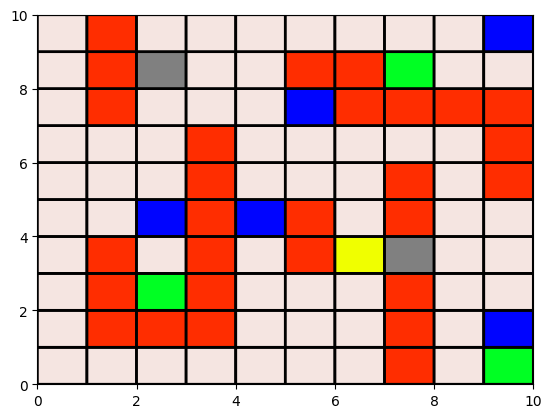

In [ ]:
visualizing_env(env6)


sarsa_s
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 669.47it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 693.91it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 534.58it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 697.52it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:06<00:00, 761.11it/s]


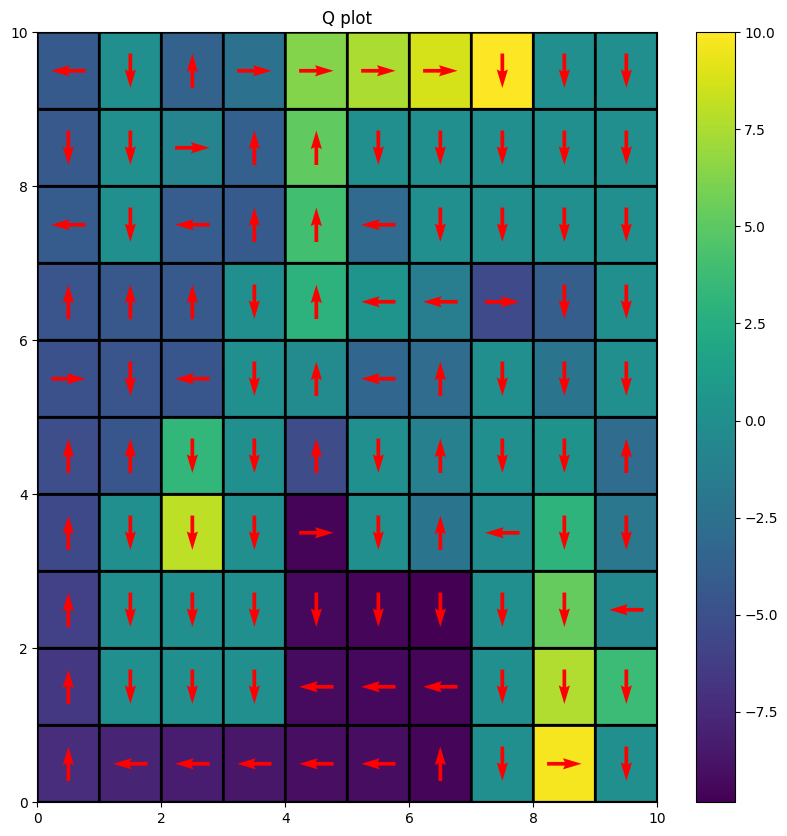

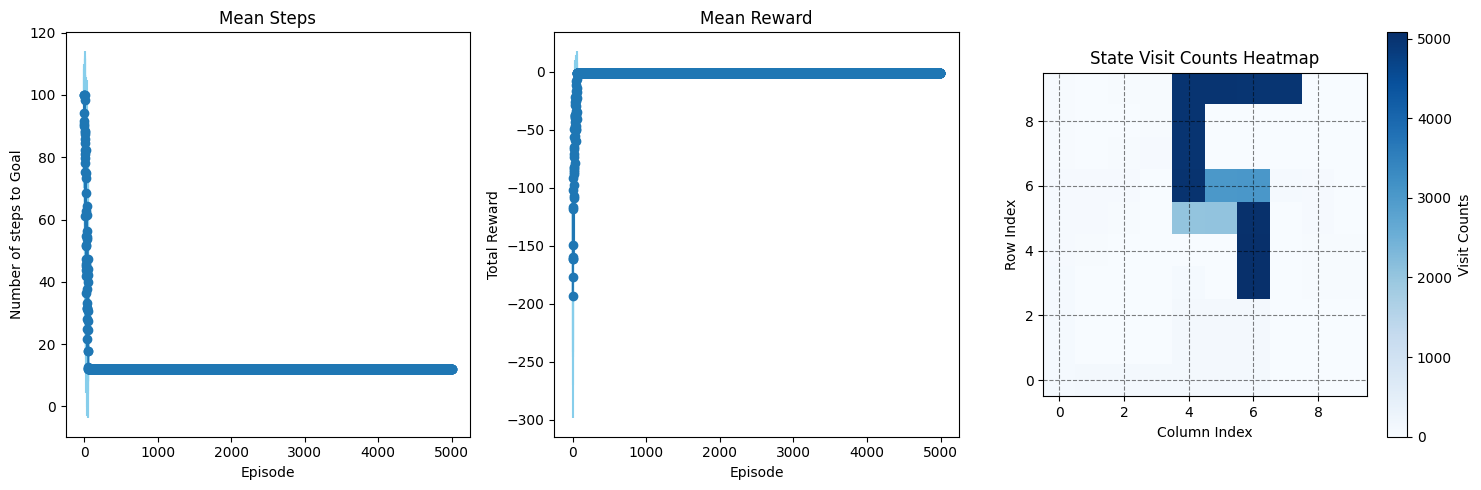

Average reward across all the runs =  -1.7274
Average steps across all the runs =  12.54384
sarsa_e
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 717.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 707.63it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 748.49it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 707.66it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:06<00:00, 716.01it/s]


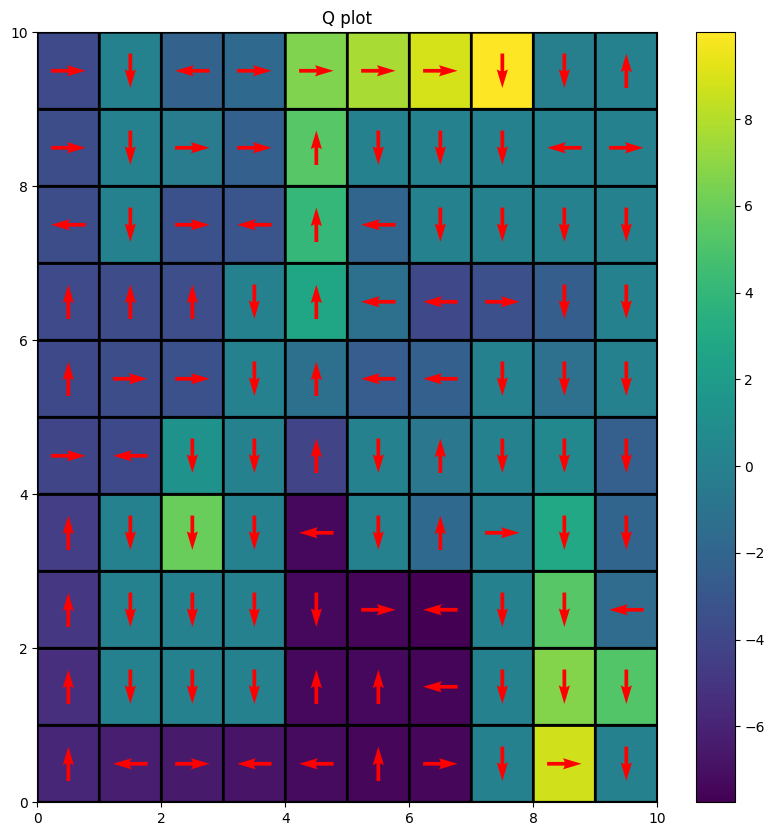

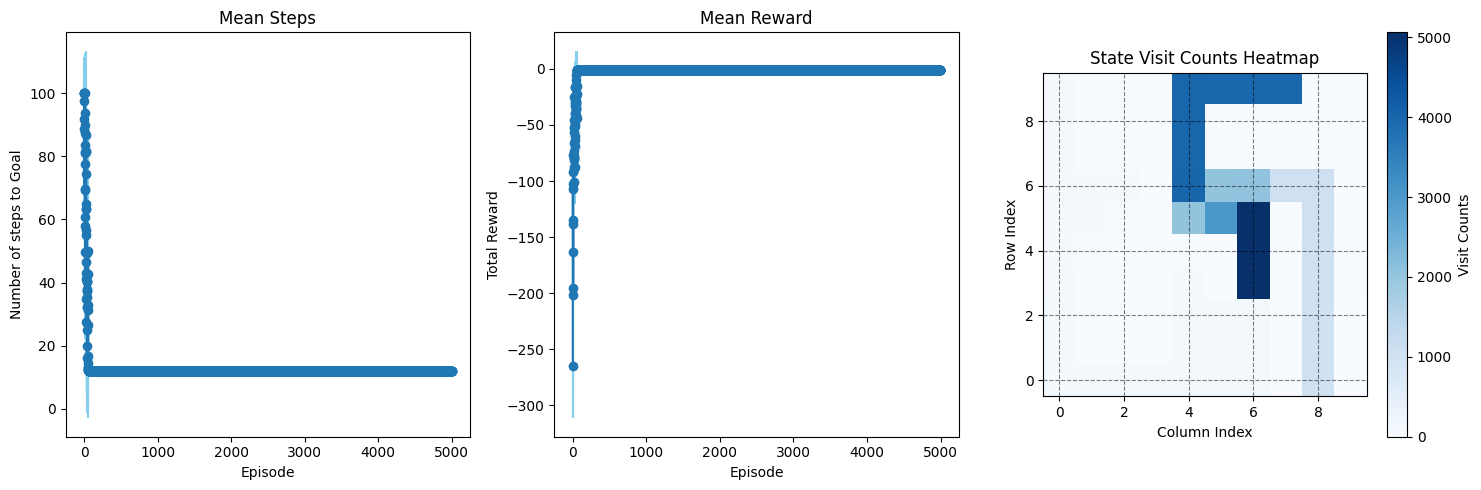

Average reward across all the runs =  -1.6864000000000001
Average steps across all the runs =  12.509
qlearning_s
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 664.67it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 709.59it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 659.94it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 642.43it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:08<00:00, 611.01it/s]


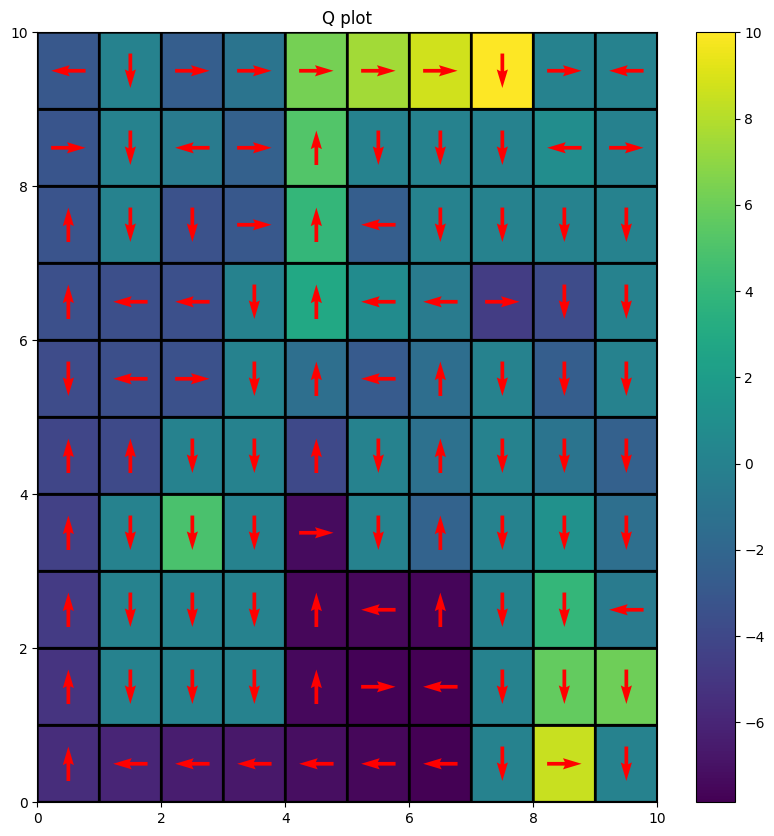

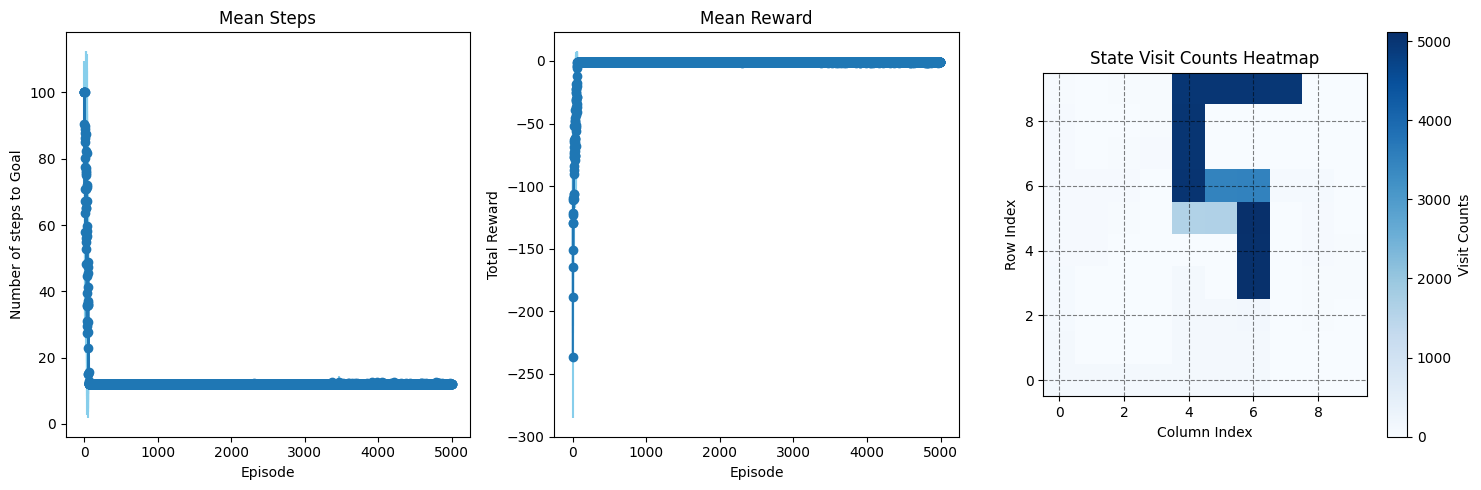

Average reward across all the runs =  -1.8305600000000002
Average steps across all the runs =  12.6362
qlearning_e
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 669.78it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 640.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 663.59it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:06<00:00, 739.36it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:07<00:00, 695.20it/s]


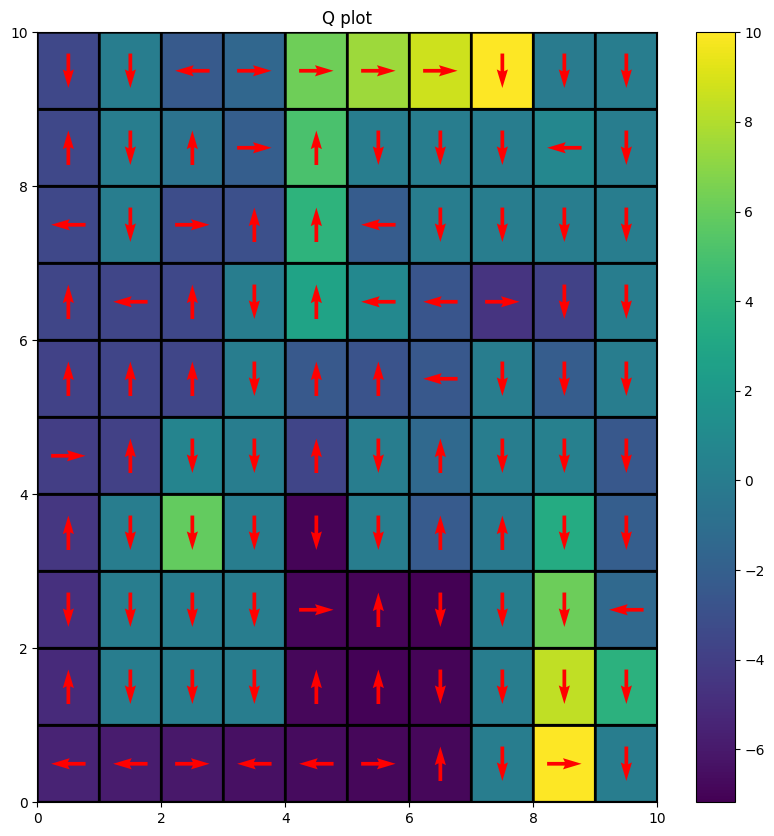

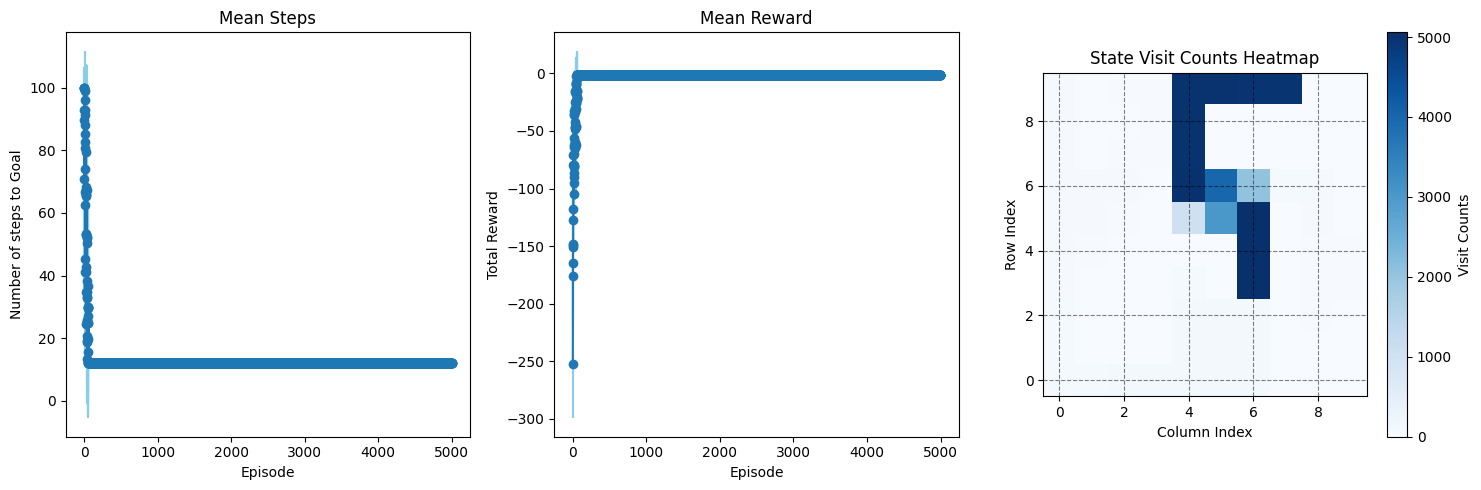

Average reward across all the runs =  -1.6711199999999997
Average steps across all the runs =  12.49948


In [ ]:
# alpha0= 0.4900643593746247
# gamma=0.9729403362428741
# tau= 0.612225020497208
# print("sarsa_s")
# plot_all(sarsa_s,env6)


# alpha0= 0.37989761397056715
# gamma= 0.9855276515774711
# epsilon0= 0.13351881807542137
# print("sarsa_e")
# plot_all(sarsa_e,env6)


# alpha0=0.40720848071052207
# gamma= 0.9729176643529042
# tau= 0.5442641881617138
# print("qlearning_s")
# plot_all(qlearning_s,env6)


# alpha0= 0.3955562421828534
# gamma=  0.9707314488295206
# epsilon0=  0.08058392792269649
# print("qlearning_e")
# plot_all(qlearning_e,env6)